# Geometric Deep Learning
*Hilary Term 2023*

---
This notebook conducts a number of experiments to assess the performance of the scalable version of the Gradient Flow Framework (GRAFF).

Run the cell below to install the necessary dependencies for this notebook.

In [1]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 904.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account 

Run the cell below to import the necessary libraries and provided external code.

In [2]:
import torch
import numpy as np

from typing import List, Callable

from utils import train
from models import MLP, ScalableGRAFF, get_device

from ogb.nodeproppred import PygNodePropPredDataset

from torch_geometric.data.dataset import Dataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import Reddit, Flickr

from google.colab import drive
drive.mount('/content/drive')

device = get_device()

Mounted at /content/drive


---
### Experimental Setup
The cell below defines the experimental setup to be run for each model type and dataset.

In [3]:
def get_diffusion_ops(dataset: Dataset) -> List[torch.Tensor]:
    # Load the pre-computed diffusion operators from Google Drive.
    file_name = dataset.__class__.__name__.lower()
    if hasattr(dataset, 'name'):
        file_name += '_' + dataset.name.lower()

    return torch.load(
         f'/content/drive/MyDrive/diffusion_ops/{file_name}.pt',
         map_location=device
    )

def run_experiment(
    dataset: Dataset, 
    learning_rate: float, 
    model_func: Callable, 
    diffusion_ops: List[torch.Tensor], 
    num_runs: int = 10) -> None:

    # Get the graph from the dataset.
    data = dataset[0].to(device)

    # Use the given train/validation/test splits provided.
    if type(dataset) == PygNodePropPredDataset:
        split_idx = dataset.get_idx_split()
        train_mask = split_idx['train']
        val_mask = split_idx['valid']
        test_mask = split_idx['test']
        data.y = torch.squeeze(data.y, -1)
    else:
        train_mask = data.train_mask
        val_mask = data.val_mask
        test_mask = data.test_mask

    # Iterate for the given number of runs.
    test_accs = []
    for _ in range(num_runs):
        # Get a new model.
        model = model_func(diffusion_ops)

        # Train the model and record the test accuracy.
        test_acc = train(
            model,
            data.x,
            data.y,
            data.edge_index,
            train_mask,
            val_mask,
            test_mask,
            learning_rate,
            verbose=True
        )
        test_accs.append(test_acc)

    name = dataset.__class__.__name__
    if hasattr(dataset, 'name'):
        name += '-' + dataset.name

    print(f'{name}: test_accuracy={np.mean(test_accs):.3f}±{np.std(test_accs):.3f}')

The cell below defines the functions that generate the models to be trained.

In [4]:
# Create a new MLP model.
def model_func_mlp(_):
    return MLP(
        num_features,
        hidden_dim,
        num_classes
    )

# Create a new scalable GRAFF model.
def model_func_graff(diffusion_ops):
    return ScalableGRAFF(
        num_features,
        num_classes,
        diffusion_ops,
        num_graff_layers=num_graff_layers,
        num_decoder_layers=num_decoder_layers
    )

---
## Reddit
Define the hyperparameters for this section.

In [ ]:
hidden_dim = 128
learning_rate = 0.01
num_decoder_layers = 1

Download the Reddit dataset and get the corresponding diffusion operators.

In [ ]:
dataset = Reddit(root='/tmp', transform=ToUndirected())
print('Loading diffusion operators...')
diffusion_ops = get_diffusion_ops(dataset)
print('Done!')

num_features = dataset.num_features
num_classes = dataset.num_classes

Extracting /tmp/raw/reddit.zip
Processing...
Done!


Loading diffusion operators...
Done!


### Multi-layer Perceptron

Epoch 0:   train_loss=4.0429 | train_acc=0.0169 | val_acc=0.0179
Epoch 10:  train_loss=1.6736 | train_acc=0.5504 | val_acc=0.5464
Epoch 20:  train_loss=1.3024 | train_acc=0.6423 | val_acc=0.6328
Epoch 30:  train_loss=1.1208 | train_acc=0.6868 | val_acc=0.6689
Epoch 40:  train_loss=1.0021 | train_acc=0.7170 | val_acc=0.6885
Epoch 50:  train_loss=0.9133 | train_acc=0.7397 | val_acc=0.6992
Epoch 60:  train_loss=0.8685 | train_acc=0.7488 | val_acc=0.6999
Epoch 70:  train_loss=0.7989 | train_acc=0.7700 | val_acc=0.7091
Epoch 80:  train_loss=0.7462 | train_acc=0.7832 | val_acc=0.7116
Epoch 90:  train_loss=0.7032 | train_acc=0.7962 | val_acc=0.7135
Epoch 100: train_loss=0.6642 | train_acc=0.8067 | val_acc=0.7117
Early stopping after 110 epochs
Test accuracy: 0.7074


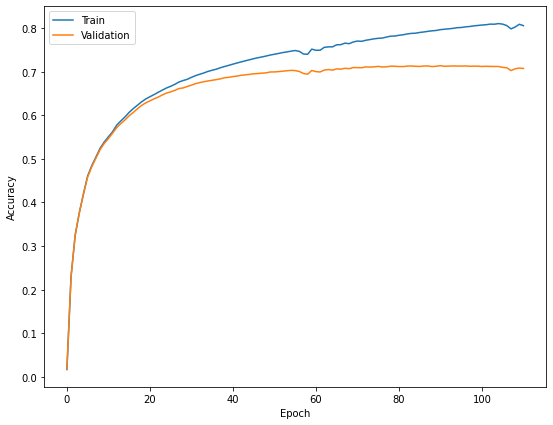

Epoch 0:   train_loss=4.0876 | train_acc=0.0144 | val_acc=0.0155
Epoch 10:  train_loss=1.7791 | train_acc=0.5339 | val_acc=0.5325
Epoch 20:  train_loss=1.3780 | train_acc=0.6241 | val_acc=0.6169
Epoch 30:  train_loss=1.1832 | train_acc=0.6731 | val_acc=0.6594
Epoch 40:  train_loss=1.0550 | train_acc=0.7050 | val_acc=0.6828
Epoch 50:  train_loss=0.9626 | train_acc=0.7282 | val_acc=0.6962
Epoch 60:  train_loss=0.8905 | train_acc=0.7458 | val_acc=0.7043
Epoch 70:  train_loss=0.8310 | train_acc=0.7614 | val_acc=0.7076
Epoch 80:  train_loss=0.8046 | train_acc=0.7664 | val_acc=0.7050
Epoch 90:  train_loss=0.7505 | train_acc=0.7814 | val_acc=0.7086
Epoch 100: train_loss=0.7173 | train_acc=0.7897 | val_acc=0.7100
Early stopping after 103 epochs
Test accuracy: 0.7068


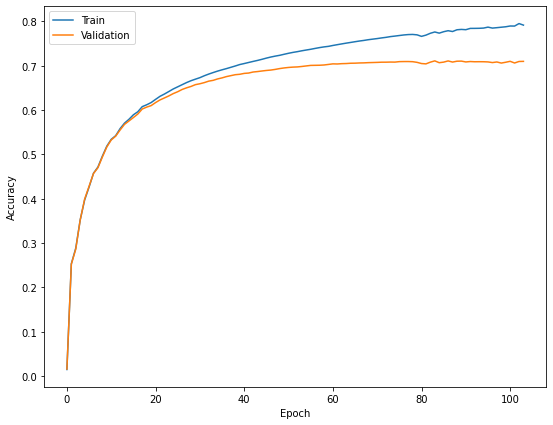

Epoch 0:   train_loss=4.0712 | train_acc=0.0223 | val_acc=0.0234
Epoch 10:  train_loss=1.7870 | train_acc=0.5299 | val_acc=0.5264
Epoch 20:  train_loss=1.3761 | train_acc=0.6241 | val_acc=0.6146
Epoch 30:  train_loss=1.1774 | train_acc=0.6743 | val_acc=0.6556
Epoch 40:  train_loss=1.0504 | train_acc=0.7060 | val_acc=0.6784
Epoch 50:  train_loss=0.9579 | train_acc=0.7298 | val_acc=0.6930
Epoch 60:  train_loss=0.8864 | train_acc=0.7472 | val_acc=0.7014
Epoch 70:  train_loss=0.8264 | train_acc=0.7625 | val_acc=0.7062
Epoch 80:  train_loss=0.7747 | train_acc=0.7761 | val_acc=0.7081
Epoch 90:  train_loss=0.7499 | train_acc=0.7813 | val_acc=0.7047
Epoch 100: train_loss=0.7132 | train_acc=0.7903 | val_acc=0.7032
Early stopping after 104 epochs
Test accuracy: 0.7073


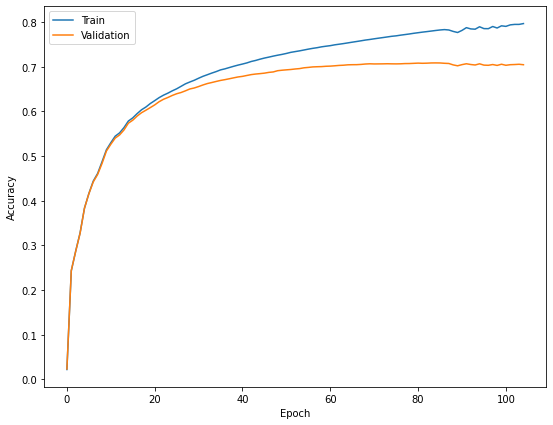

Epoch 0:   train_loss=3.9246 | train_acc=0.0328 | val_acc=0.0320
Epoch 10:  train_loss=1.7289 | train_acc=0.5384 | val_acc=0.5361
Epoch 20:  train_loss=1.3497 | train_acc=0.6296 | val_acc=0.6211
Epoch 30:  train_loss=1.1595 | train_acc=0.6786 | val_acc=0.6632
Epoch 40:  train_loss=1.0376 | train_acc=0.7093 | val_acc=0.6839
Epoch 50:  train_loss=0.9490 | train_acc=0.7307 | val_acc=0.6963
Epoch 60:  train_loss=0.8786 | train_acc=0.7490 | val_acc=0.7037
Epoch 70:  train_loss=0.8195 | train_acc=0.7645 | val_acc=0.7071
Epoch 80:  train_loss=0.8116 | train_acc=0.7636 | val_acc=0.7007
Epoch 90:  train_loss=0.7429 | train_acc=0.7830 | val_acc=0.7059
Early stopping after 95 epochs
Test accuracy: 0.7076


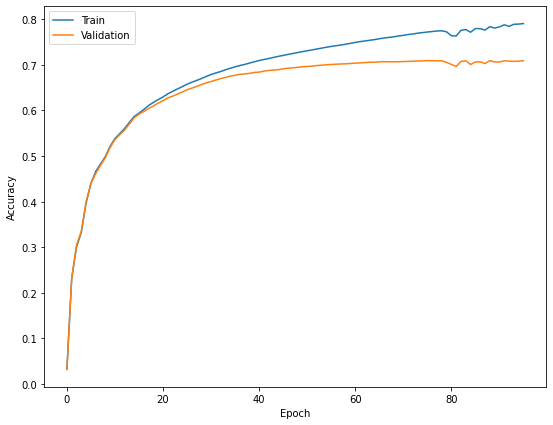

Epoch 0:   train_loss=3.9541 | train_acc=0.0284 | val_acc=0.0288
Epoch 10:  train_loss=1.6767 | train_acc=0.5518 | val_acc=0.5480
Epoch 20:  train_loss=1.3058 | train_acc=0.6424 | val_acc=0.6281
Epoch 30:  train_loss=1.1248 | train_acc=0.6866 | val_acc=0.6655
Epoch 40:  train_loss=1.0077 | train_acc=0.7175 | val_acc=0.6844
Epoch 50:  train_loss=0.9210 | train_acc=0.7390 | val_acc=0.6972
Epoch 60:  train_loss=0.8525 | train_acc=0.7563 | val_acc=0.7038
Epoch 70:  train_loss=0.8131 | train_acc=0.7640 | val_acc=0.7024
Epoch 80:  train_loss=0.7552 | train_acc=0.7807 | val_acc=0.7064
Epoch 90:  train_loss=0.7089 | train_acc=0.7939 | val_acc=0.7083
Epoch 100: train_loss=0.6695 | train_acc=0.8045 | val_acc=0.7081
Early stopping after 107 epochs
Test accuracy: 0.7041


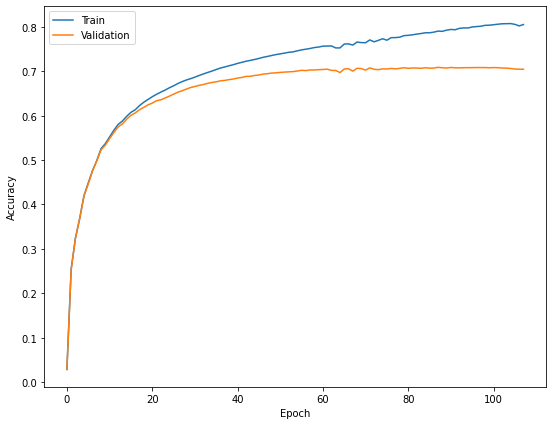

Epoch 0:   train_loss=4.0011 | train_acc=0.0225 | val_acc=0.0224
Epoch 10:  train_loss=1.6613 | train_acc=0.5551 | val_acc=0.5503
Epoch 20:  train_loss=1.3091 | train_acc=0.6417 | val_acc=0.6319
Epoch 30:  train_loss=1.1291 | train_acc=0.6870 | val_acc=0.6670
Epoch 40:  train_loss=1.0102 | train_acc=0.7169 | val_acc=0.6852
Epoch 50:  train_loss=0.9243 | train_acc=0.7383 | val_acc=0.6977
Epoch 60:  train_loss=0.8579 | train_acc=0.7550 | val_acc=0.7050
Epoch 70:  train_loss=0.8047 | train_acc=0.7681 | val_acc=0.7074
Epoch 80:  train_loss=0.7561 | train_acc=0.7812 | val_acc=0.7105
Epoch 90:  train_loss=0.7256 | train_acc=0.7886 | val_acc=0.7074
Epoch 100: train_loss=0.6957 | train_acc=0.7960 | val_acc=0.7078
Early stopping after 102 epochs
Test accuracy: 0.7037


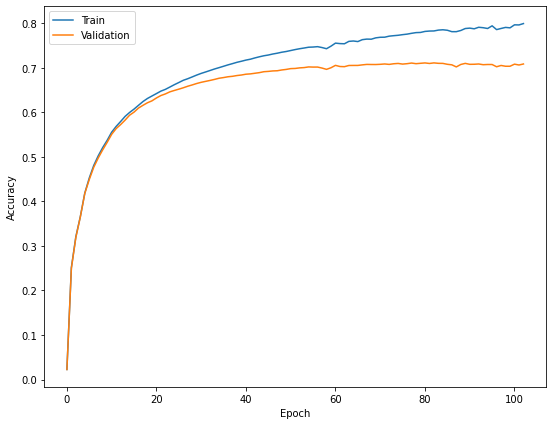

Epoch 0:   train_loss=4.0604 | train_acc=0.0165 | val_acc=0.0174
Epoch 10:  train_loss=1.7150 | train_acc=0.5428 | val_acc=0.5377
Epoch 20:  train_loss=1.3347 | train_acc=0.6344 | val_acc=0.6247
Epoch 30:  train_loss=1.1442 | train_acc=0.6820 | val_acc=0.6632
Epoch 40:  train_loss=1.0197 | train_acc=0.7135 | val_acc=0.6853
Epoch 50:  train_loss=0.9294 | train_acc=0.7374 | val_acc=0.6962
Epoch 60:  train_loss=0.8605 | train_acc=0.7543 | val_acc=0.7036
Epoch 70:  train_loss=0.8174 | train_acc=0.7628 | val_acc=0.7049
Epoch 80:  train_loss=0.7562 | train_acc=0.7813 | val_acc=0.7110
Epoch 90:  train_loss=0.7138 | train_acc=0.7930 | val_acc=0.7120
Epoch 100: train_loss=0.6938 | train_acc=0.7971 | val_acc=0.7073
Epoch 110: train_loss=0.6494 | train_acc=0.8093 | val_acc=0.7118
Early stopping after 114 epochs
Test accuracy: 0.7058


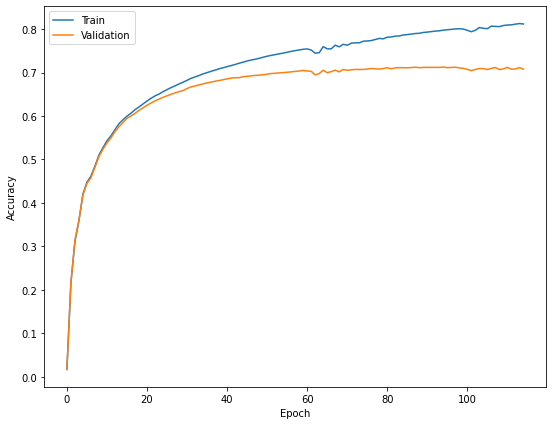

Epoch 0:   train_loss=3.9852 | train_acc=0.0152 | val_acc=0.0143
Epoch 10:  train_loss=1.6525 | train_acc=0.5588 | val_acc=0.5492
Epoch 20:  train_loss=1.2939 | train_acc=0.6440 | val_acc=0.6327
Epoch 30:  train_loss=1.1165 | train_acc=0.6891 | val_acc=0.6686
Epoch 40:  train_loss=0.9990 | train_acc=0.7182 | val_acc=0.6867
Epoch 50:  train_loss=0.9229 | train_acc=0.7368 | val_acc=0.6968
Epoch 60:  train_loss=0.8687 | train_acc=0.7490 | val_acc=0.6991
Epoch 70:  train_loss=0.7981 | train_acc=0.7697 | val_acc=0.7073
Epoch 80:  train_loss=0.7481 | train_acc=0.7835 | val_acc=0.7102
Epoch 90:  train_loss=0.7165 | train_acc=0.7911 | val_acc=0.7084
Epoch 100: train_loss=0.6720 | train_acc=0.8033 | val_acc=0.7103
Early stopping after 104 epochs
Test accuracy: 0.7097


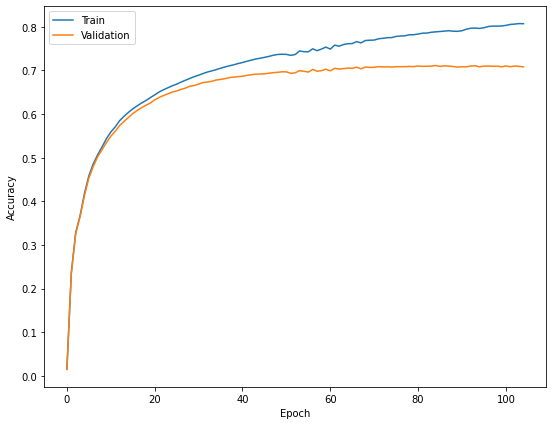

Epoch 0:   train_loss=4.1496 | train_acc=0.0249 | val_acc=0.0240
Epoch 10:  train_loss=1.6492 | train_acc=0.5620 | val_acc=0.5578
Epoch 20:  train_loss=1.2890 | train_acc=0.6449 | val_acc=0.6311
Epoch 30:  train_loss=1.1163 | train_acc=0.6903 | val_acc=0.6693
Epoch 40:  train_loss=1.0026 | train_acc=0.7183 | val_acc=0.6858
Epoch 50:  train_loss=0.9187 | train_acc=0.7397 | val_acc=0.6960
Epoch 60:  train_loss=0.8577 | train_acc=0.7549 | val_acc=0.7006
Epoch 70:  train_loss=0.8021 | train_acc=0.7688 | val_acc=0.7055
Epoch 80:  train_loss=0.7529 | train_acc=0.7818 | val_acc=0.7071
Epoch 90:  train_loss=0.7281 | train_acc=0.7872 | val_acc=0.7047
Early stopping after 99 epochs
Test accuracy: 0.7021


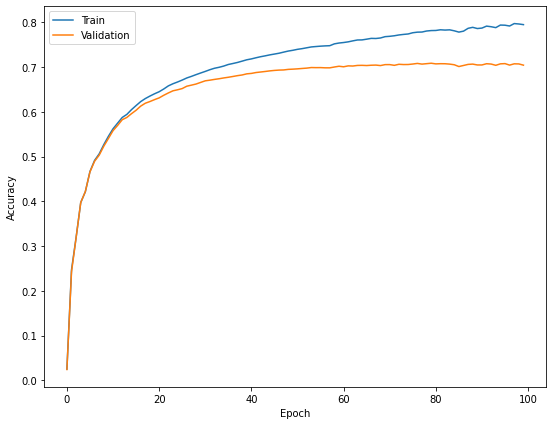

Epoch 0:   train_loss=3.9234 | train_acc=0.0196 | val_acc=0.0191
Epoch 10:  train_loss=1.7871 | train_acc=0.5220 | val_acc=0.5201
Epoch 20:  train_loss=1.3895 | train_acc=0.6199 | val_acc=0.6153
Epoch 30:  train_loss=1.1859 | train_acc=0.6715 | val_acc=0.6559
Epoch 40:  train_loss=1.0567 | train_acc=0.7050 | val_acc=0.6781
Epoch 50:  train_loss=0.9618 | train_acc=0.7281 | val_acc=0.6921
Epoch 60:  train_loss=0.8878 | train_acc=0.7475 | val_acc=0.7001
Epoch 70:  train_loss=0.8264 | train_acc=0.7634 | val_acc=0.7042
Epoch 80:  train_loss=0.7796 | train_acc=0.7756 | val_acc=0.7055
Epoch 90:  train_loss=0.7500 | train_acc=0.7812 | val_acc=0.7061
Epoch 100: train_loss=0.6976 | train_acc=0.7972 | val_acc=0.7095
Epoch 110: train_loss=0.6598 | train_acc=0.8082 | val_acc=0.7103
Epoch 120: train_loss=0.6381 | train_acc=0.8139 | val_acc=0.7079
Epoch 130: train_loss=0.6081 | train_acc=0.8222 | val_acc=0.7074
Early stopping after 134 epochs
Test accuracy: 0.7017


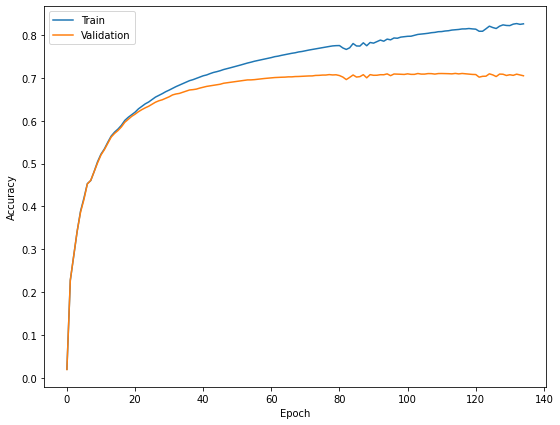

Reddit: test_accuracy=0.706±0.002


In [ ]:
run_experiment(dataset, learning_rate, model_func_mlp, None)

### GRAFF

Epoch 0:   train_loss=4.5570 | train_acc=0.0352 | val_acc=0.0366
Epoch 10:  train_loss=1.0715 | train_acc=0.7356 | val_acc=0.7338
Epoch 20:  train_loss=0.7644 | train_acc=0.8180 | val_acc=0.8096
Epoch 30:  train_loss=0.6453 | train_acc=0.8473 | val_acc=0.8343
Epoch 40:  train_loss=0.5822 | train_acc=0.8607 | val_acc=0.8451
Epoch 50:  train_loss=0.5454 | train_acc=0.8686 | val_acc=0.8506
Epoch 60:  train_loss=0.5221 | train_acc=0.8734 | val_acc=0.8535
Epoch 70:  train_loss=0.5061 | train_acc=0.8770 | val_acc=0.8552
Epoch 80:  train_loss=0.4945 | train_acc=0.8792 | val_acc=0.8561
Epoch 90:  train_loss=0.4857 | train_acc=0.8813 | val_acc=0.8564
Epoch 100: train_loss=0.4786 | train_acc=0.8826 | val_acc=0.8565
Epoch 110: train_loss=0.4729 | train_acc=0.8836 | val_acc=0.8567
Epoch 120: train_loss=0.4681 | train_acc=0.8845 | val_acc=0.8570
Epoch 130: train_loss=0.4640 | train_acc=0.8855 | val_acc=0.8575
Epoch 140: train_loss=0.4606 | train_acc=0.8860 | val_acc=0.8578
Epoch 150: train_loss=0.4

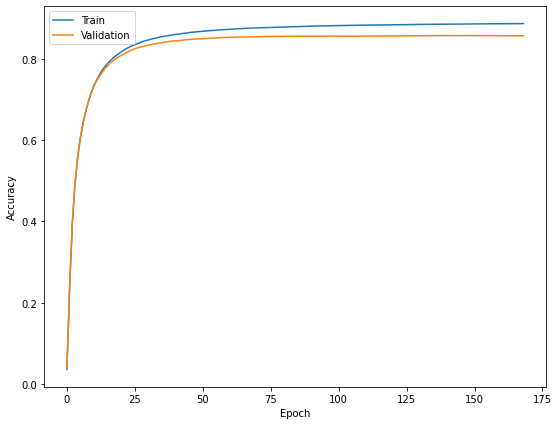

Epoch 0:   train_loss=4.6051 | train_acc=0.0197 | val_acc=0.0197
Epoch 10:  train_loss=1.0605 | train_acc=0.7400 | val_acc=0.7324
Epoch 20:  train_loss=0.7506 | train_acc=0.8201 | val_acc=0.8092
Epoch 30:  train_loss=0.6363 | train_acc=0.8480 | val_acc=0.8328
Epoch 40:  train_loss=0.5770 | train_acc=0.8611 | val_acc=0.8441
Epoch 50:  train_loss=0.5416 | train_acc=0.8687 | val_acc=0.8486
Epoch 60:  train_loss=0.5191 | train_acc=0.8736 | val_acc=0.8523
Epoch 70:  train_loss=0.5038 | train_acc=0.8769 | val_acc=0.8541
Epoch 80:  train_loss=0.4927 | train_acc=0.8793 | val_acc=0.8559
Epoch 90:  train_loss=0.4843 | train_acc=0.8810 | val_acc=0.8567
Epoch 100: train_loss=0.4776 | train_acc=0.8819 | val_acc=0.8570
Epoch 110: train_loss=0.4721 | train_acc=0.8831 | val_acc=0.8576
Epoch 120: train_loss=0.4675 | train_acc=0.8839 | val_acc=0.8579
Epoch 130: train_loss=0.4636 | train_acc=0.8848 | val_acc=0.8577
Epoch 140: train_loss=0.4602 | train_acc=0.8852 | val_acc=0.8574
Early stopping after 145 

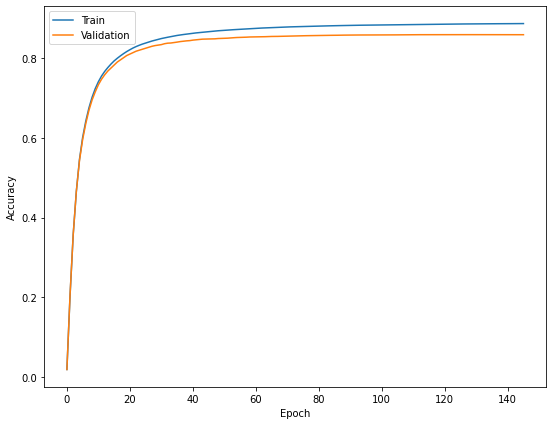

Epoch 0:   train_loss=4.4836 | train_acc=0.0302 | val_acc=0.0301
Epoch 10:  train_loss=1.0684 | train_acc=0.7385 | val_acc=0.7350
Epoch 20:  train_loss=0.7552 | train_acc=0.8203 | val_acc=0.8122
Epoch 30:  train_loss=0.6380 | train_acc=0.8484 | val_acc=0.8355
Epoch 40:  train_loss=0.5772 | train_acc=0.8612 | val_acc=0.8450
Epoch 50:  train_loss=0.5411 | train_acc=0.8694 | val_acc=0.8517
Epoch 60:  train_loss=0.5185 | train_acc=0.8743 | val_acc=0.8540
Epoch 70:  train_loss=0.5033 | train_acc=0.8776 | val_acc=0.8554
Epoch 80:  train_loss=0.4924 | train_acc=0.8797 | val_acc=0.8562
Epoch 90:  train_loss=0.4841 | train_acc=0.8814 | val_acc=0.8571
Epoch 100: train_loss=0.4776 | train_acc=0.8829 | val_acc=0.8578
Epoch 110: train_loss=0.4722 | train_acc=0.8837 | val_acc=0.8578
Epoch 120: train_loss=0.4677 | train_acc=0.8845 | val_acc=0.8575
Early stopping after 127 epochs
Test accuracy: 0.8593


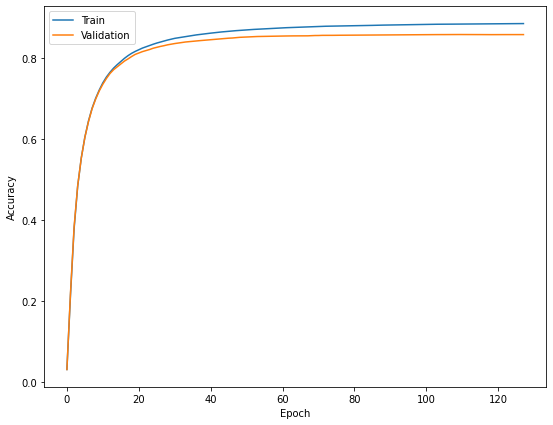

Epoch 0:   train_loss=4.5298 | train_acc=0.0227 | val_acc=0.0236
Epoch 10:  train_loss=1.0583 | train_acc=0.7386 | val_acc=0.7353
Epoch 20:  train_loss=0.7424 | train_acc=0.8230 | val_acc=0.8126
Epoch 30:  train_loss=0.6284 | train_acc=0.8497 | val_acc=0.8358
Epoch 40:  train_loss=0.5685 | train_acc=0.8632 | val_acc=0.8471
Epoch 50:  train_loss=0.5335 | train_acc=0.8711 | val_acc=0.8517
Epoch 60:  train_loss=0.5115 | train_acc=0.8757 | val_acc=0.8553
Epoch 70:  train_loss=0.4968 | train_acc=0.8788 | val_acc=0.8571
Epoch 80:  train_loss=0.4862 | train_acc=0.8809 | val_acc=0.8584
Epoch 90:  train_loss=0.4781 | train_acc=0.8825 | val_acc=0.8594
Epoch 100: train_loss=0.4717 | train_acc=0.8838 | val_acc=0.8605
Epoch 110: train_loss=0.4665 | train_acc=0.8847 | val_acc=0.8606
Epoch 120: train_loss=0.4622 | train_acc=0.8854 | val_acc=0.8608
Epoch 130: train_loss=0.4586 | train_acc=0.8861 | val_acc=0.8611
Epoch 140: train_loss=0.4554 | train_acc=0.8869 | val_acc=0.8615
Epoch 150: train_loss=0.4

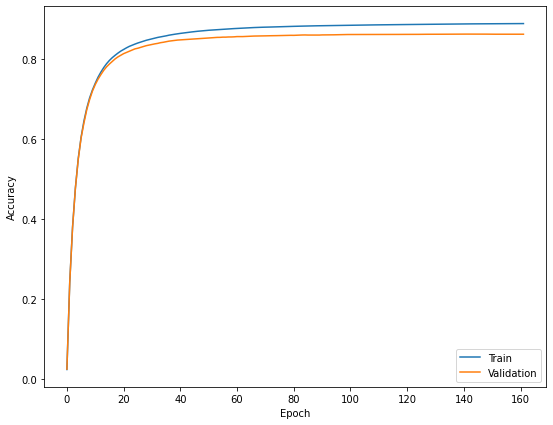

Epoch 0:   train_loss=4.7084 | train_acc=0.0217 | val_acc=0.0216
Epoch 10:  train_loss=1.0795 | train_acc=0.7343 | val_acc=0.7294
Epoch 20:  train_loss=0.7624 | train_acc=0.8183 | val_acc=0.8099
Epoch 30:  train_loss=0.6431 | train_acc=0.8460 | val_acc=0.8338
Epoch 40:  train_loss=0.5803 | train_acc=0.8602 | val_acc=0.8450
Epoch 50:  train_loss=0.5432 | train_acc=0.8689 | val_acc=0.8506
Epoch 60:  train_loss=0.5193 | train_acc=0.8741 | val_acc=0.8536
Epoch 70:  train_loss=0.5029 | train_acc=0.8779 | val_acc=0.8563
Epoch 80:  train_loss=0.4911 | train_acc=0.8800 | val_acc=0.8573
Epoch 90:  train_loss=0.4820 | train_acc=0.8822 | val_acc=0.8577
Epoch 100: train_loss=0.4748 | train_acc=0.8838 | val_acc=0.8583
Epoch 110: train_loss=0.4689 | train_acc=0.8849 | val_acc=0.8585
Epoch 120: train_loss=0.4639 | train_acc=0.8853 | val_acc=0.8590
Epoch 130: train_loss=0.4598 | train_acc=0.8859 | val_acc=0.8593
Epoch 140: train_loss=0.4562 | train_acc=0.8866 | val_acc=0.8593
Epoch 150: train_loss=0.4

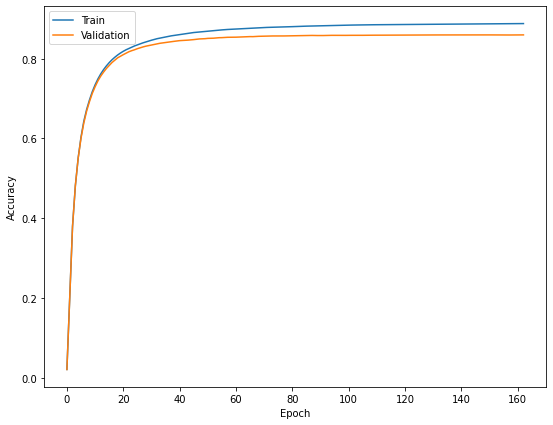

Epoch 0:   train_loss=4.6672 | train_acc=0.0262 | val_acc=0.0270
Epoch 10:  train_loss=1.0839 | train_acc=0.7337 | val_acc=0.7293
Epoch 20:  train_loss=0.7663 | train_acc=0.8184 | val_acc=0.8096
Epoch 30:  train_loss=0.6476 | train_acc=0.8464 | val_acc=0.8326
Epoch 40:  train_loss=0.5843 | train_acc=0.8598 | val_acc=0.8440
Epoch 50:  train_loss=0.5463 | train_acc=0.8673 | val_acc=0.8497
Epoch 60:  train_loss=0.5223 | train_acc=0.8728 | val_acc=0.8525
Epoch 70:  train_loss=0.5060 | train_acc=0.8766 | val_acc=0.8547
Epoch 80:  train_loss=0.4942 | train_acc=0.8794 | val_acc=0.8561
Epoch 90:  train_loss=0.4852 | train_acc=0.8816 | val_acc=0.8567
Epoch 100: train_loss=0.4780 | train_acc=0.8828 | val_acc=0.8573
Epoch 110: train_loss=0.4722 | train_acc=0.8841 | val_acc=0.8580
Epoch 120: train_loss=0.4674 | train_acc=0.8849 | val_acc=0.8580
Epoch 130: train_loss=0.4632 | train_acc=0.8857 | val_acc=0.8585
Epoch 140: train_loss=0.4597 | train_acc=0.8861 | val_acc=0.8586
Epoch 150: train_loss=0.4

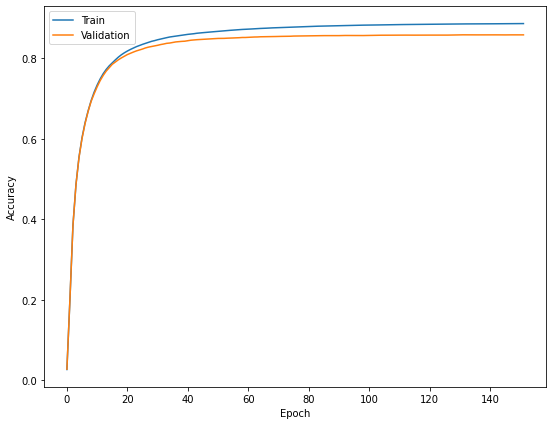

Epoch 0:   train_loss=4.4909 | train_acc=0.0245 | val_acc=0.0231
Epoch 10:  train_loss=1.0754 | train_acc=0.7324 | val_acc=0.7290
Epoch 20:  train_loss=0.7568 | train_acc=0.8183 | val_acc=0.8090
Epoch 30:  train_loss=0.6377 | train_acc=0.8479 | val_acc=0.8348
Epoch 40:  train_loss=0.5757 | train_acc=0.8622 | val_acc=0.8468
Epoch 50:  train_loss=0.5398 | train_acc=0.8700 | val_acc=0.8525
Epoch 60:  train_loss=0.5168 | train_acc=0.8745 | val_acc=0.8548
Epoch 70:  train_loss=0.5012 | train_acc=0.8781 | val_acc=0.8569
Epoch 80:  train_loss=0.4898 | train_acc=0.8806 | val_acc=0.8579
Epoch 90:  train_loss=0.4811 | train_acc=0.8825 | val_acc=0.8585
Epoch 100: train_loss=0.4742 | train_acc=0.8838 | val_acc=0.8589
Epoch 110: train_loss=0.4685 | train_acc=0.8848 | val_acc=0.8593
Epoch 120: train_loss=0.4638 | train_acc=0.8857 | val_acc=0.8595
Epoch 130: train_loss=0.4598 | train_acc=0.8866 | val_acc=0.8594
Early stopping after 140 epochs
Test accuracy: 0.8628


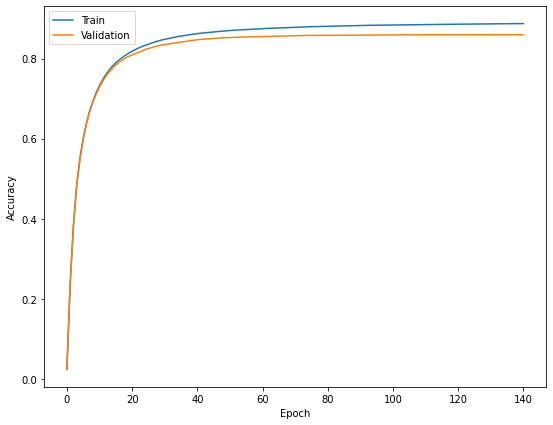

Epoch 0:   train_loss=4.7894 | train_acc=0.0224 | val_acc=0.0232
Epoch 10:  train_loss=1.0905 | train_acc=0.7329 | val_acc=0.7274
Epoch 20:  train_loss=0.7661 | train_acc=0.8190 | val_acc=0.8099
Epoch 30:  train_loss=0.6452 | train_acc=0.8466 | val_acc=0.8348
Epoch 40:  train_loss=0.5812 | train_acc=0.8597 | val_acc=0.8448
Epoch 50:  train_loss=0.5431 | train_acc=0.8683 | val_acc=0.8501
Epoch 60:  train_loss=0.5189 | train_acc=0.8738 | val_acc=0.8538
Epoch 70:  train_loss=0.5025 | train_acc=0.8774 | val_acc=0.8561
Epoch 80:  train_loss=0.4906 | train_acc=0.8800 | val_acc=0.8579
Epoch 90:  train_loss=0.4815 | train_acc=0.8814 | val_acc=0.8583
Epoch 100: train_loss=0.4743 | train_acc=0.8830 | val_acc=0.8590
Epoch 110: train_loss=0.4683 | train_acc=0.8841 | val_acc=0.8592
Epoch 120: train_loss=0.4634 | train_acc=0.8848 | val_acc=0.8593
Epoch 130: train_loss=0.4592 | train_acc=0.8855 | val_acc=0.8592
Early stopping after 139 epochs
Test accuracy: 0.8619


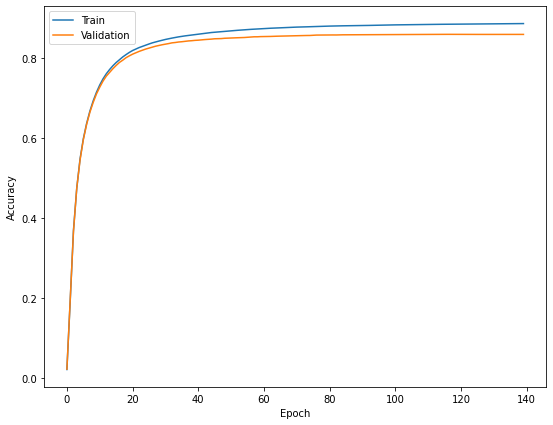

Epoch 0:   train_loss=4.5500 | train_acc=0.0244 | val_acc=0.0240
Epoch 10:  train_loss=1.0700 | train_acc=0.7383 | val_acc=0.7350
Epoch 20:  train_loss=0.7537 | train_acc=0.8201 | val_acc=0.8124
Epoch 30:  train_loss=0.6342 | train_acc=0.8483 | val_acc=0.8383
Epoch 40:  train_loss=0.5727 | train_acc=0.8619 | val_acc=0.8486
Epoch 50:  train_loss=0.5357 | train_acc=0.8697 | val_acc=0.8535
Epoch 60:  train_loss=0.5125 | train_acc=0.8747 | val_acc=0.8575
Epoch 70:  train_loss=0.4967 | train_acc=0.8779 | val_acc=0.8585
Epoch 80:  train_loss=0.4853 | train_acc=0.8803 | val_acc=0.8597
Epoch 90:  train_loss=0.4767 | train_acc=0.8819 | val_acc=0.8609
Epoch 100: train_loss=0.4698 | train_acc=0.8831 | val_acc=0.8614
Epoch 110: train_loss=0.4643 | train_acc=0.8840 | val_acc=0.8617
Epoch 120: train_loss=0.4597 | train_acc=0.8847 | val_acc=0.8617
Epoch 130: train_loss=0.4558 | train_acc=0.8857 | val_acc=0.8615
Early stopping after 131 epochs
Test accuracy: 0.8624


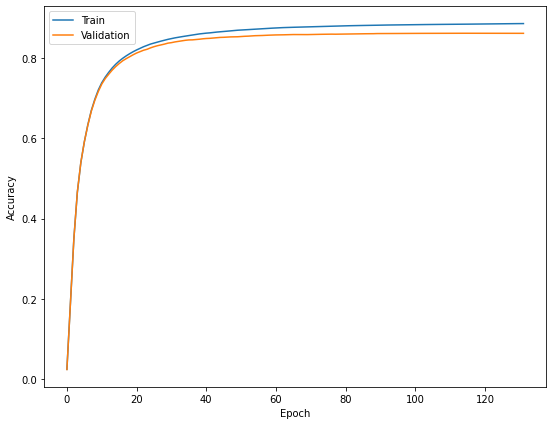

Epoch 0:   train_loss=4.4816 | train_acc=0.0223 | val_acc=0.0236
Epoch 10:  train_loss=1.0716 | train_acc=0.7357 | val_acc=0.7315
Epoch 20:  train_loss=0.7528 | train_acc=0.8198 | val_acc=0.8118
Epoch 30:  train_loss=0.6341 | train_acc=0.8476 | val_acc=0.8368
Epoch 40:  train_loss=0.5733 | train_acc=0.8621 | val_acc=0.8476
Epoch 50:  train_loss=0.5374 | train_acc=0.8700 | val_acc=0.8541
Epoch 60:  train_loss=0.5143 | train_acc=0.8749 | val_acc=0.8566
Epoch 70:  train_loss=0.4986 | train_acc=0.8784 | val_acc=0.8580
Epoch 80:  train_loss=0.4871 | train_acc=0.8809 | val_acc=0.8595
Epoch 90:  train_loss=0.4783 | train_acc=0.8825 | val_acc=0.8606
Epoch 100: train_loss=0.4713 | train_acc=0.8838 | val_acc=0.8612
Epoch 110: train_loss=0.4655 | train_acc=0.8851 | val_acc=0.8615
Epoch 120: train_loss=0.4607 | train_acc=0.8860 | val_acc=0.8617
Epoch 130: train_loss=0.4566 | train_acc=0.8867 | val_acc=0.8619
Epoch 140: train_loss=0.4531 | train_acc=0.8873 | val_acc=0.8623
Epoch 150: train_loss=0.4

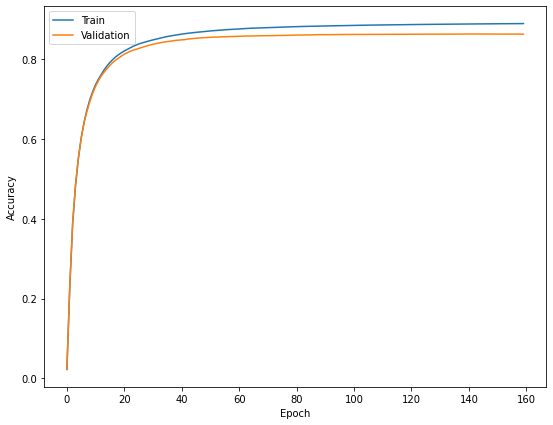

Reddit: test_accuracy=0.861±0.001


In [ ]:
num_graff_layers = 1
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

Epoch 0:   train_loss=6.2182 | train_acc=0.0312 | val_acc=0.0311
Epoch 10:  train_loss=0.5994 | train_acc=0.8676 | val_acc=0.8655
Epoch 20:  train_loss=0.4575 | train_acc=0.9032 | val_acc=0.8978
Epoch 30:  train_loss=0.3871 | train_acc=0.9176 | val_acc=0.9091
Epoch 40:  train_loss=0.3391 | train_acc=0.9253 | val_acc=0.9163
Epoch 50:  train_loss=0.3052 | train_acc=0.9306 | val_acc=0.9190
Epoch 60:  train_loss=0.2812 | train_acc=0.9344 | val_acc=0.9214
Epoch 70:  train_loss=0.2635 | train_acc=0.9378 | val_acc=0.9228
Epoch 80:  train_loss=0.2499 | train_acc=0.9402 | val_acc=0.9240
Epoch 90:  train_loss=0.2392 | train_acc=0.9420 | val_acc=0.9249
Epoch 100: train_loss=0.2305 | train_acc=0.9437 | val_acc=0.9253
Epoch 110: train_loss=0.2233 | train_acc=0.9453 | val_acc=0.9262
Epoch 120: train_loss=0.2171 | train_acc=0.9466 | val_acc=0.9267
Epoch 130: train_loss=0.2118 | train_acc=0.9477 | val_acc=0.9267
Epoch 140: train_loss=0.2071 | train_acc=0.9487 | val_acc=0.9267
Epoch 150: train_loss=0.2

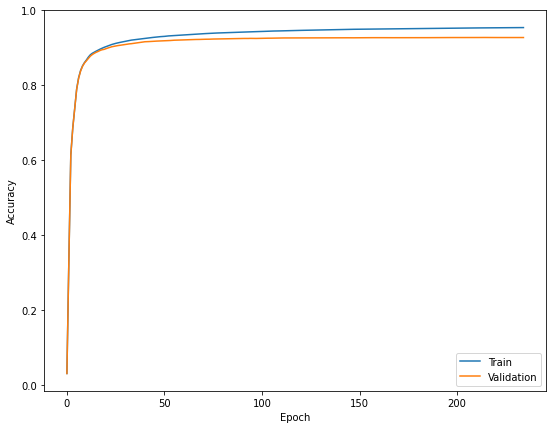

Epoch 0:   train_loss=5.9180 | train_acc=0.0135 | val_acc=0.0134
Epoch 10:  train_loss=0.6167 | train_acc=0.8660 | val_acc=0.8677
Epoch 20:  train_loss=0.4622 | train_acc=0.9031 | val_acc=0.8998
Epoch 30:  train_loss=0.3896 | train_acc=0.9170 | val_acc=0.9119
Epoch 40:  train_loss=0.3410 | train_acc=0.9250 | val_acc=0.9180
Epoch 50:  train_loss=0.3064 | train_acc=0.9304 | val_acc=0.9219
Epoch 60:  train_loss=0.2816 | train_acc=0.9343 | val_acc=0.9239
Epoch 70:  train_loss=0.2634 | train_acc=0.9377 | val_acc=0.9251
Epoch 80:  train_loss=0.2497 | train_acc=0.9399 | val_acc=0.9260
Epoch 90:  train_loss=0.2388 | train_acc=0.9421 | val_acc=0.9268
Epoch 100: train_loss=0.2301 | train_acc=0.9440 | val_acc=0.9269
Epoch 110: train_loss=0.2228 | train_acc=0.9455 | val_acc=0.9274
Epoch 120: train_loss=0.2167 | train_acc=0.9467 | val_acc=0.9278
Epoch 130: train_loss=0.2114 | train_acc=0.9477 | val_acc=0.9282
Epoch 140: train_loss=0.2068 | train_acc=0.9487 | val_acc=0.9283
Epoch 150: train_loss=0.2

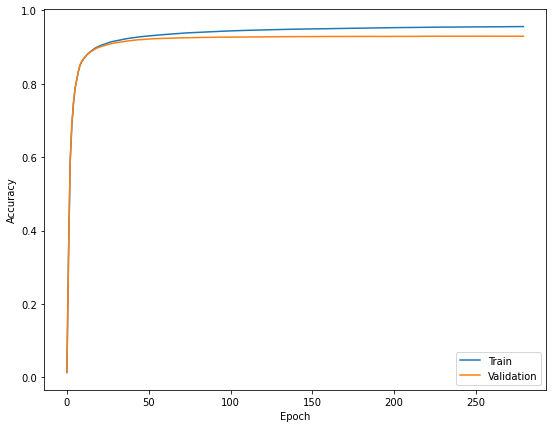

Epoch 0:   train_loss=5.9846 | train_acc=0.0131 | val_acc=0.0140
Epoch 10:  train_loss=0.6250 | train_acc=0.8614 | val_acc=0.8574
Epoch 20:  train_loss=0.4497 | train_acc=0.9040 | val_acc=0.9012
Epoch 30:  train_loss=0.3785 | train_acc=0.9179 | val_acc=0.9132
Epoch 40:  train_loss=0.3305 | train_acc=0.9260 | val_acc=0.9190
Epoch 50:  train_loss=0.2971 | train_acc=0.9314 | val_acc=0.9227
Epoch 60:  train_loss=0.2734 | train_acc=0.9357 | val_acc=0.9244
Epoch 70:  train_loss=0.2561 | train_acc=0.9385 | val_acc=0.9256
Epoch 80:  train_loss=0.2431 | train_acc=0.9409 | val_acc=0.9263
Epoch 90:  train_loss=0.2329 | train_acc=0.9428 | val_acc=0.9269
Epoch 100: train_loss=0.2246 | train_acc=0.9447 | val_acc=0.9277
Epoch 110: train_loss=0.2178 | train_acc=0.9463 | val_acc=0.9278
Epoch 120: train_loss=0.2120 | train_acc=0.9475 | val_acc=0.9286
Epoch 130: train_loss=0.2070 | train_acc=0.9486 | val_acc=0.9286
Epoch 140: train_loss=0.2026 | train_acc=0.9494 | val_acc=0.9284
Early stopping after 142 

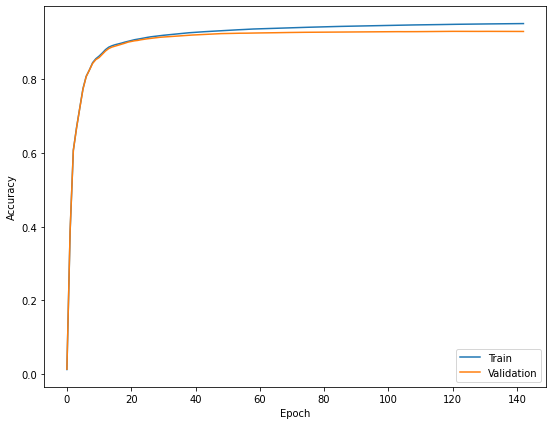

Epoch 0:   train_loss=5.5675 | train_acc=0.0280 | val_acc=0.0277
Epoch 10:  train_loss=0.5983 | train_acc=0.8698 | val_acc=0.8679
Epoch 20:  train_loss=0.4515 | train_acc=0.9069 | val_acc=0.9021
Epoch 30:  train_loss=0.3815 | train_acc=0.9197 | val_acc=0.9147
Epoch 40:  train_loss=0.3340 | train_acc=0.9271 | val_acc=0.9201
Epoch 50:  train_loss=0.3008 | train_acc=0.9321 | val_acc=0.9228
Epoch 60:  train_loss=0.2768 | train_acc=0.9358 | val_acc=0.9243
Epoch 70:  train_loss=0.2591 | train_acc=0.9387 | val_acc=0.9253
Epoch 80:  train_loss=0.2456 | train_acc=0.9408 | val_acc=0.9266
Epoch 90:  train_loss=0.2350 | train_acc=0.9428 | val_acc=0.9272
Epoch 100: train_loss=0.2264 | train_acc=0.9445 | val_acc=0.9278
Epoch 110: train_loss=0.2193 | train_acc=0.9459 | val_acc=0.9287
Epoch 120: train_loss=0.2132 | train_acc=0.9470 | val_acc=0.9292
Epoch 130: train_loss=0.2080 | train_acc=0.9482 | val_acc=0.9296
Epoch 140: train_loss=0.2035 | train_acc=0.9492 | val_acc=0.9299
Epoch 150: train_loss=0.1

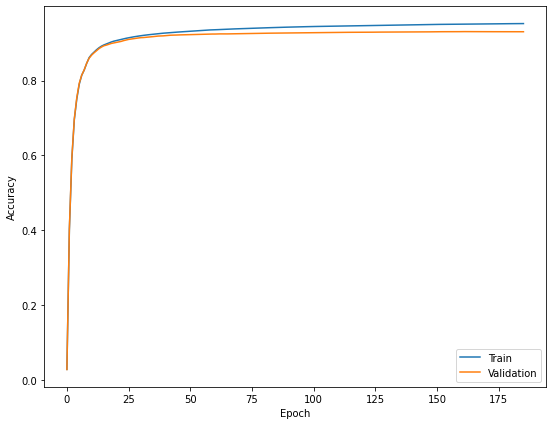

Epoch 0:   train_loss=5.5603 | train_acc=0.0256 | val_acc=0.0258
Epoch 10:  train_loss=0.5718 | train_acc=0.8722 | val_acc=0.8690
Epoch 20:  train_loss=0.4346 | train_acc=0.9075 | val_acc=0.9021
Epoch 30:  train_loss=0.3671 | train_acc=0.9209 | val_acc=0.9144
Epoch 40:  train_loss=0.3207 | train_acc=0.9284 | val_acc=0.9204
Epoch 50:  train_loss=0.2886 | train_acc=0.9332 | val_acc=0.9233
Epoch 60:  train_loss=0.2653 | train_acc=0.9368 | val_acc=0.9252
Epoch 70:  train_loss=0.2483 | train_acc=0.9399 | val_acc=0.9259
Epoch 80:  train_loss=0.2356 | train_acc=0.9424 | val_acc=0.9267
Epoch 90:  train_loss=0.2256 | train_acc=0.9443 | val_acc=0.9275
Epoch 100: train_loss=0.2177 | train_acc=0.9461 | val_acc=0.9282
Epoch 110: train_loss=0.2111 | train_acc=0.9475 | val_acc=0.9288
Epoch 120: train_loss=0.2055 | train_acc=0.9485 | val_acc=0.9290
Epoch 130: train_loss=0.2007 | train_acc=0.9496 | val_acc=0.9292
Epoch 140: train_loss=0.1965 | train_acc=0.9504 | val_acc=0.9293
Epoch 150: train_loss=0.1

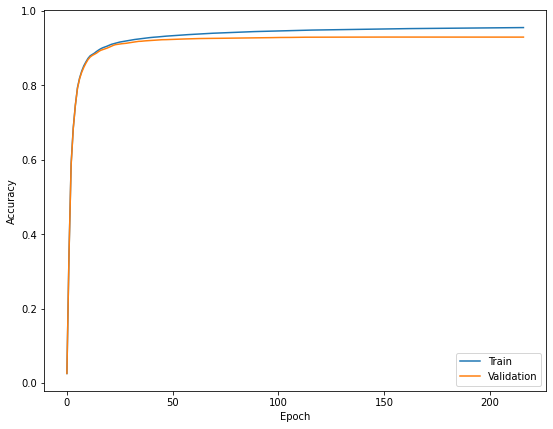

Epoch 0:   train_loss=5.9236 | train_acc=0.0150 | val_acc=0.0150
Epoch 10:  train_loss=0.5940 | train_acc=0.8710 | val_acc=0.8722
Epoch 20:  train_loss=0.4481 | train_acc=0.9067 | val_acc=0.9040
Epoch 30:  train_loss=0.3775 | train_acc=0.9198 | val_acc=0.9156
Epoch 40:  train_loss=0.3301 | train_acc=0.9273 | val_acc=0.9202
Epoch 50:  train_loss=0.2969 | train_acc=0.9317 | val_acc=0.9234
Epoch 60:  train_loss=0.2732 | train_acc=0.9360 | val_acc=0.9262
Epoch 70:  train_loss=0.2561 | train_acc=0.9392 | val_acc=0.9275
Epoch 80:  train_loss=0.2431 | train_acc=0.9413 | val_acc=0.9279
Epoch 90:  train_loss=0.2331 | train_acc=0.9433 | val_acc=0.9286
Epoch 100: train_loss=0.2249 | train_acc=0.9446 | val_acc=0.9293
Epoch 110: train_loss=0.2182 | train_acc=0.9461 | val_acc=0.9296
Epoch 120: train_loss=0.2125 | train_acc=0.9474 | val_acc=0.9297
Epoch 130: train_loss=0.2075 | train_acc=0.9483 | val_acc=0.9298
Epoch 140: train_loss=0.2032 | train_acc=0.9492 | val_acc=0.9298
Epoch 150: train_loss=0.1

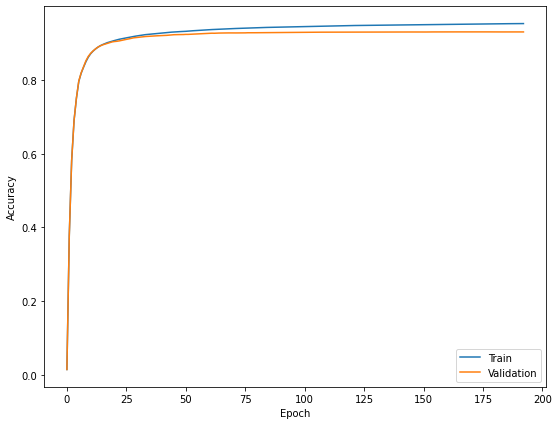

Epoch 0:   train_loss=5.4007 | train_acc=0.0332 | val_acc=0.0331
Epoch 10:  train_loss=0.6424 | train_acc=0.8693 | val_acc=0.8684
Epoch 20:  train_loss=0.4850 | train_acc=0.9052 | val_acc=0.9012
Epoch 30:  train_loss=0.4061 | train_acc=0.9196 | val_acc=0.9132
Epoch 40:  train_loss=0.3513 | train_acc=0.9274 | val_acc=0.9186
Epoch 50:  train_loss=0.3122 | train_acc=0.9324 | val_acc=0.9216
Epoch 60:  train_loss=0.2836 | train_acc=0.9362 | val_acc=0.9240
Epoch 70:  train_loss=0.2621 | train_acc=0.9392 | val_acc=0.9255
Epoch 80:  train_loss=0.2458 | train_acc=0.9416 | val_acc=0.9269
Epoch 90:  train_loss=0.2330 | train_acc=0.9439 | val_acc=0.9277
Epoch 100: train_loss=0.2229 | train_acc=0.9455 | val_acc=0.9284
Epoch 110: train_loss=0.2149 | train_acc=0.9471 | val_acc=0.9286
Epoch 120: train_loss=0.2086 | train_acc=0.9483 | val_acc=0.9291
Epoch 130: train_loss=0.2035 | train_acc=0.9495 | val_acc=0.9295
Epoch 140: train_loss=0.1990 | train_acc=0.9504 | val_acc=0.9298
Epoch 150: train_loss=0.1

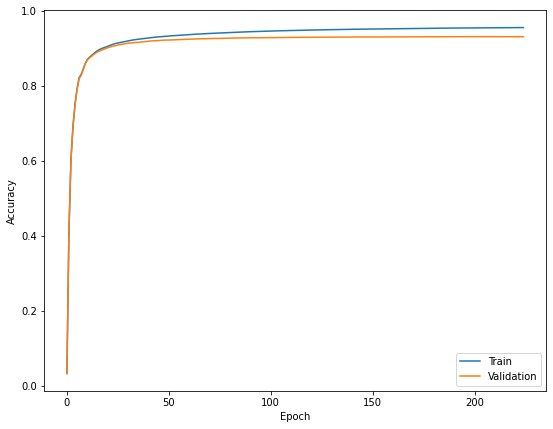

Epoch 0:   train_loss=5.7437 | train_acc=0.0278 | val_acc=0.0278
Epoch 10:  train_loss=0.6105 | train_acc=0.8626 | val_acc=0.8605
Epoch 20:  train_loss=0.4568 | train_acc=0.9027 | val_acc=0.8988
Epoch 30:  train_loss=0.3822 | train_acc=0.9180 | val_acc=0.9126
Epoch 40:  train_loss=0.3331 | train_acc=0.9261 | val_acc=0.9183
Epoch 50:  train_loss=0.2993 | train_acc=0.9317 | val_acc=0.9216
Epoch 60:  train_loss=0.2751 | train_acc=0.9350 | val_acc=0.9237
Epoch 70:  train_loss=0.2573 | train_acc=0.9379 | val_acc=0.9258
Epoch 80:  train_loss=0.2440 | train_acc=0.9405 | val_acc=0.9265
Epoch 90:  train_loss=0.2337 | train_acc=0.9426 | val_acc=0.9272
Epoch 100: train_loss=0.2253 | train_acc=0.9444 | val_acc=0.9281
Epoch 110: train_loss=0.2184 | train_acc=0.9456 | val_acc=0.9287
Epoch 120: train_loss=0.2126 | train_acc=0.9470 | val_acc=0.9290
Epoch 130: train_loss=0.2076 | train_acc=0.9481 | val_acc=0.9297
Epoch 140: train_loss=0.2032 | train_acc=0.9491 | val_acc=0.9296
Epoch 150: train_loss=0.1

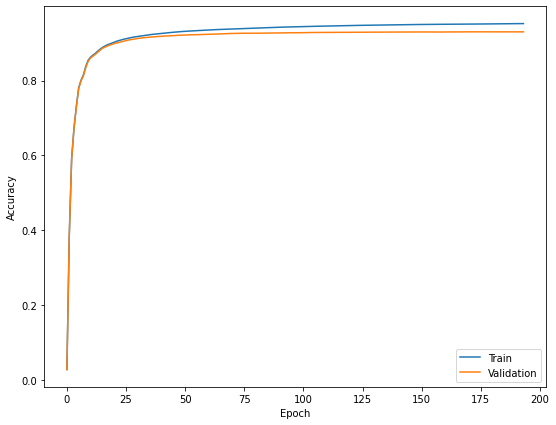

Epoch 0:   train_loss=5.6188 | train_acc=0.0264 | val_acc=0.0263
Epoch 10:  train_loss=0.6281 | train_acc=0.8602 | val_acc=0.8583
Epoch 20:  train_loss=0.4635 | train_acc=0.9041 | val_acc=0.9026
Epoch 30:  train_loss=0.3869 | train_acc=0.9181 | val_acc=0.9147
Epoch 40:  train_loss=0.3372 | train_acc=0.9259 | val_acc=0.9200
Epoch 50:  train_loss=0.3031 | train_acc=0.9311 | val_acc=0.9236
Epoch 60:  train_loss=0.2785 | train_acc=0.9351 | val_acc=0.9263
Epoch 70:  train_loss=0.2602 | train_acc=0.9384 | val_acc=0.9274
Epoch 80:  train_loss=0.2464 | train_acc=0.9411 | val_acc=0.9284
Epoch 90:  train_loss=0.2355 | train_acc=0.9432 | val_acc=0.9294
Epoch 100: train_loss=0.2268 | train_acc=0.9448 | val_acc=0.9301
Epoch 110: train_loss=0.2197 | train_acc=0.9464 | val_acc=0.9303
Epoch 120: train_loss=0.2136 | train_acc=0.9477 | val_acc=0.9305
Epoch 130: train_loss=0.2084 | train_acc=0.9488 | val_acc=0.9305
Epoch 140: train_loss=0.2038 | train_acc=0.9496 | val_acc=0.9303
Early stopping after 141 

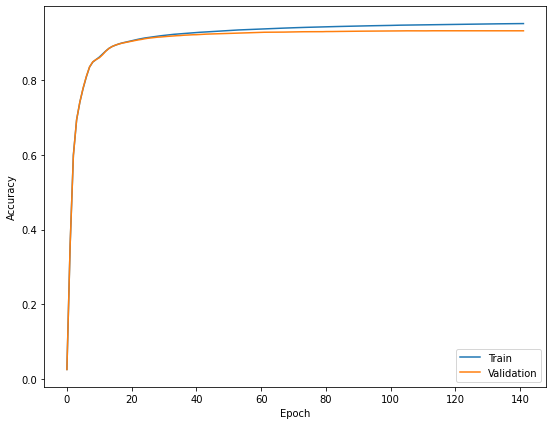

Epoch 0:   train_loss=6.9579 | train_acc=0.0157 | val_acc=0.0155
Epoch 10:  train_loss=0.6429 | train_acc=0.8596 | val_acc=0.8561
Epoch 20:  train_loss=0.4665 | train_acc=0.9024 | val_acc=0.8985
Epoch 30:  train_loss=0.3891 | train_acc=0.9174 | val_acc=0.9115
Epoch 40:  train_loss=0.3393 | train_acc=0.9258 | val_acc=0.9177
Epoch 50:  train_loss=0.3058 | train_acc=0.9308 | val_acc=0.9205
Epoch 60:  train_loss=0.2820 | train_acc=0.9349 | val_acc=0.9236
Epoch 70:  train_loss=0.2646 | train_acc=0.9380 | val_acc=0.9246
Epoch 80:  train_loss=0.2511 | train_acc=0.9402 | val_acc=0.9259
Epoch 90:  train_loss=0.2404 | train_acc=0.9424 | val_acc=0.9261
Epoch 100: train_loss=0.2317 | train_acc=0.9440 | val_acc=0.9268
Epoch 110: train_loss=0.2243 | train_acc=0.9453 | val_acc=0.9270
Epoch 120: train_loss=0.2181 | train_acc=0.9465 | val_acc=0.9273
Epoch 130: train_loss=0.2126 | train_acc=0.9476 | val_acc=0.9273
Epoch 140: train_loss=0.2079 | train_acc=0.9484 | val_acc=0.9277
Epoch 150: train_loss=0.2

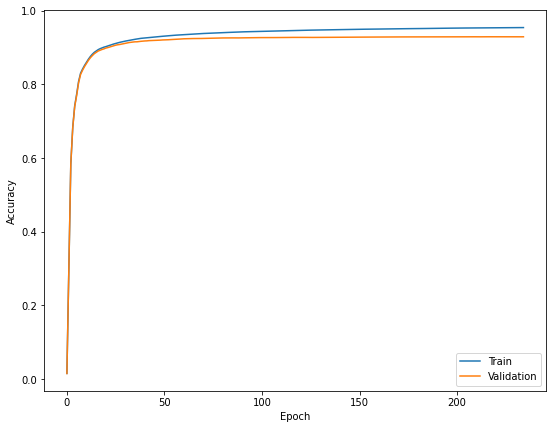

Reddit: test_accuracy=0.929±0.001


In [ ]:
num_graff_layers = 2
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

Epoch 0:   train_loss=28.9358 | train_acc=0.0088 | val_acc=0.0091
Epoch 10:  train_loss=3.6629 | train_acc=0.8368 | val_acc=0.8359
Epoch 20:  train_loss=1.7342 | train_acc=0.8887 | val_acc=0.8885
Epoch 30:  train_loss=1.3280 | train_acc=0.9149 | val_acc=0.9123
Epoch 40:  train_loss=1.1431 | train_acc=0.9249 | val_acc=0.9226
Epoch 50:  train_loss=0.9972 | train_acc=0.9315 | val_acc=0.9296
Epoch 60:  train_loss=0.8773 | train_acc=0.9349 | val_acc=0.9332
Epoch 70:  train_loss=0.7806 | train_acc=0.9368 | val_acc=0.9345
Epoch 80:  train_loss=0.7071 | train_acc=0.9377 | val_acc=0.9343
Epoch 90:  train_loss=0.6478 | train_acc=0.9398 | val_acc=0.9363
Epoch 100: train_loss=0.5971 | train_acc=0.9410 | val_acc=0.9365
Epoch 110: train_loss=0.5529 | train_acc=0.9426 | val_acc=0.9374
Epoch 120: train_loss=0.5145 | train_acc=0.9438 | val_acc=0.9387
Epoch 130: train_loss=0.4804 | train_acc=0.9448 | val_acc=0.9394
Epoch 140: train_loss=0.4498 | train_acc=0.9458 | val_acc=0.9401
Epoch 150: train_loss=0.

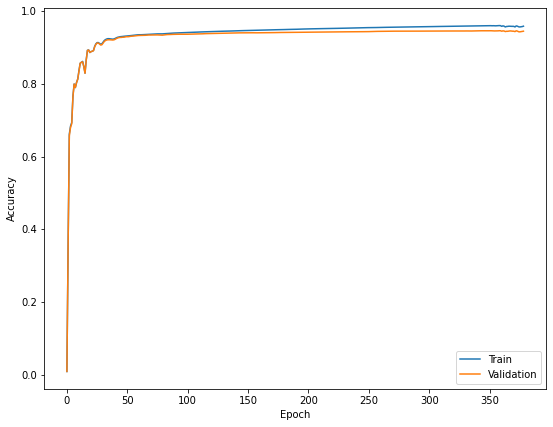

Epoch 0:   train_loss=27.5790 | train_acc=0.0068 | val_acc=0.0066
Epoch 10:  train_loss=3.2181 | train_acc=0.8015 | val_acc=0.8009
Epoch 20:  train_loss=1.8165 | train_acc=0.8864 | val_acc=0.8853
Epoch 30:  train_loss=1.4549 | train_acc=0.9158 | val_acc=0.9146
Epoch 40:  train_loss=1.1859 | train_acc=0.9215 | val_acc=0.9210
Epoch 50:  train_loss=1.0339 | train_acc=0.9258 | val_acc=0.9253
Epoch 60:  train_loss=0.9090 | train_acc=0.9302 | val_acc=0.9298
Epoch 70:  train_loss=0.8149 | train_acc=0.9335 | val_acc=0.9320
Epoch 80:  train_loss=0.7340 | train_acc=0.9354 | val_acc=0.9340
Epoch 90:  train_loss=0.6742 | train_acc=0.9377 | val_acc=0.9358
Epoch 100: train_loss=0.6178 | train_acc=0.9390 | val_acc=0.9369
Epoch 110: train_loss=0.5755 | train_acc=0.9406 | val_acc=0.9378
Epoch 120: train_loss=0.5374 | train_acc=0.9417 | val_acc=0.9386
Epoch 130: train_loss=0.5043 | train_acc=0.9427 | val_acc=0.9394
Epoch 140: train_loss=0.4737 | train_acc=0.9437 | val_acc=0.9397
Epoch 150: train_loss=0.

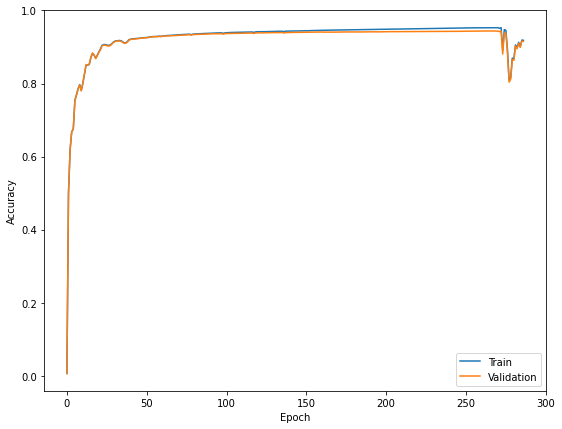

Epoch 0:   train_loss=26.2782 | train_acc=0.0051 | val_acc=0.0051
Epoch 10:  train_loss=2.1825 | train_acc=0.8476 | val_acc=0.8501
Epoch 20:  train_loss=1.5397 | train_acc=0.8942 | val_acc=0.8947
Epoch 30:  train_loss=1.2694 | train_acc=0.9162 | val_acc=0.9150
Epoch 40:  train_loss=1.0891 | train_acc=0.9277 | val_acc=0.9267
Epoch 50:  train_loss=0.9580 | train_acc=0.9317 | val_acc=0.9296
Epoch 60:  train_loss=0.8486 | train_acc=0.9330 | val_acc=0.9309
Epoch 70:  train_loss=0.7631 | train_acc=0.9359 | val_acc=0.9340
Epoch 80:  train_loss=0.6813 | train_acc=0.9380 | val_acc=0.9351
Epoch 90:  train_loss=0.6233 | train_acc=0.9393 | val_acc=0.9356
Epoch 100: train_loss=0.5764 | train_acc=0.9404 | val_acc=0.9360
Epoch 110: train_loss=0.5287 | train_acc=0.9420 | val_acc=0.9372
Epoch 120: train_loss=0.4931 | train_acc=0.9431 | val_acc=0.9380
Epoch 130: train_loss=0.4604 | train_acc=0.9442 | val_acc=0.9388
Epoch 140: train_loss=0.4311 | train_acc=0.9452 | val_acc=0.9390
Epoch 150: train_loss=0.

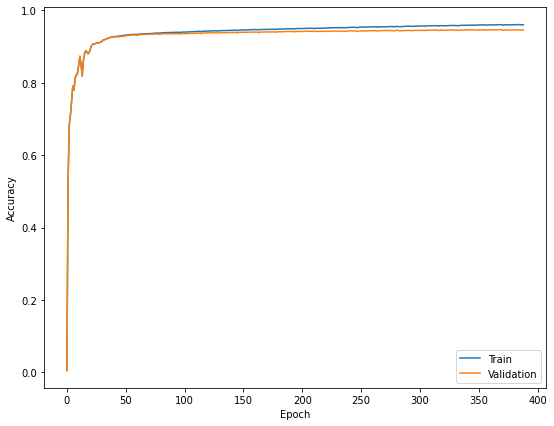

Epoch 0:   train_loss=27.9641 | train_acc=0.0070 | val_acc=0.0073
Epoch 10:  train_loss=3.1959 | train_acc=0.8210 | val_acc=0.8210
Epoch 20:  train_loss=1.9299 | train_acc=0.8900 | val_acc=0.8897
Epoch 30:  train_loss=1.4987 | train_acc=0.9126 | val_acc=0.9127
Epoch 40:  train_loss=1.2248 | train_acc=0.9225 | val_acc=0.9211
Epoch 50:  train_loss=1.0651 | train_acc=0.9277 | val_acc=0.9266
Epoch 60:  train_loss=0.9402 | train_acc=0.9321 | val_acc=0.9306
Epoch 70:  train_loss=0.8453 | train_acc=0.9340 | val_acc=0.9317
Epoch 80:  train_loss=0.7644 | train_acc=0.9372 | val_acc=0.9354
Epoch 90:  train_loss=0.7096 | train_acc=0.9384 | val_acc=0.9362
Epoch 100: train_loss=0.6445 | train_acc=0.9387 | val_acc=0.9365
Epoch 110: train_loss=0.5979 | train_acc=0.9400 | val_acc=0.9372
Epoch 120: train_loss=0.5571 | train_acc=0.9416 | val_acc=0.9387
Epoch 130: train_loss=0.5324 | train_acc=0.9423 | val_acc=0.9393
Epoch 140: train_loss=0.4868 | train_acc=0.9435 | val_acc=0.9399
Epoch 150: train_loss=0.

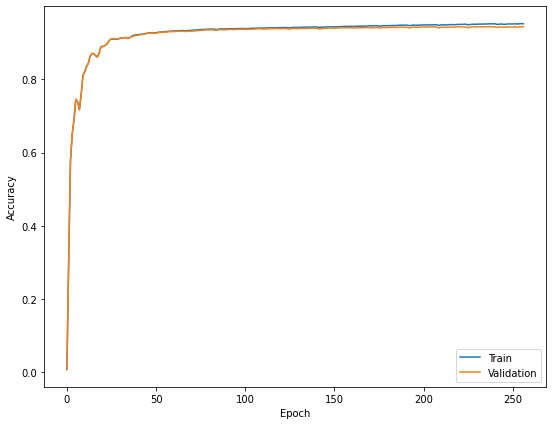

Epoch 0:   train_loss=32.9196 | train_acc=0.0096 | val_acc=0.0113
Epoch 10:  train_loss=5.4593 | train_acc=0.8221 | val_acc=0.8207
Epoch 20:  train_loss=3.3981 | train_acc=0.8783 | val_acc=0.8775
Epoch 30:  train_loss=2.2301 | train_acc=0.9059 | val_acc=0.9040
Epoch 40:  train_loss=1.8092 | train_acc=0.9196 | val_acc=0.9175
Epoch 50:  train_loss=1.5241 | train_acc=0.9274 | val_acc=0.9259
Epoch 60:  train_loss=1.3124 | train_acc=0.9308 | val_acc=0.9295
Epoch 70:  train_loss=1.1521 | train_acc=0.9330 | val_acc=0.9310
Epoch 80:  train_loss=1.0226 | train_acc=0.9351 | val_acc=0.9320
Epoch 90:  train_loss=0.9167 | train_acc=0.9368 | val_acc=0.9331
Epoch 100: train_loss=0.8270 | train_acc=0.9383 | val_acc=0.9346
Epoch 110: train_loss=0.7481 | train_acc=0.9397 | val_acc=0.9363
Epoch 120: train_loss=0.6781 | train_acc=0.9410 | val_acc=0.9366
Epoch 130: train_loss=0.6160 | train_acc=0.9419 | val_acc=0.9375
Epoch 140: train_loss=0.5604 | train_acc=0.9429 | val_acc=0.9377
Epoch 150: train_loss=0.

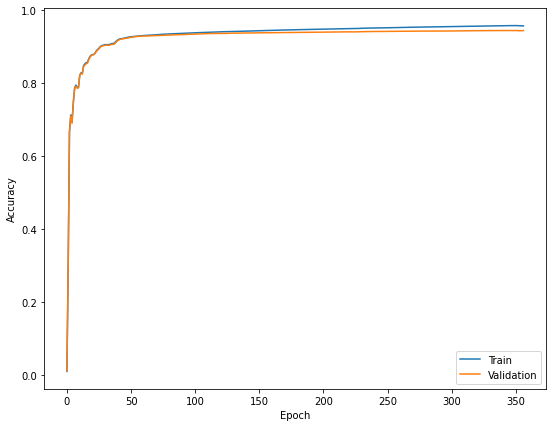

Epoch 0:   train_loss=28.9145 | train_acc=0.0645 | val_acc=0.0631
Epoch 10:  train_loss=3.0445 | train_acc=0.8282 | val_acc=0.8286
Epoch 20:  train_loss=1.7772 | train_acc=0.8898 | val_acc=0.8904
Epoch 30:  train_loss=1.2592 | train_acc=0.9191 | val_acc=0.9176
Epoch 40:  train_loss=1.0712 | train_acc=0.9277 | val_acc=0.9262
Epoch 50:  train_loss=0.9498 | train_acc=0.9318 | val_acc=0.9292
Epoch 60:  train_loss=0.8494 | train_acc=0.9336 | val_acc=0.9308
Epoch 70:  train_loss=1.1183 | train_acc=0.9349 | val_acc=0.9303
Epoch 80:  train_loss=0.8454 | train_acc=0.9383 | val_acc=0.9338
Epoch 90:  train_loss=0.8010 | train_acc=0.9395 | val_acc=0.9347
Epoch 100: train_loss=0.7270 | train_acc=0.9410 | val_acc=0.9356
Epoch 110: train_loss=0.6689 | train_acc=0.9423 | val_acc=0.9364
Epoch 120: train_loss=0.6095 | train_acc=0.9433 | val_acc=0.9375
Epoch 130: train_loss=0.5576 | train_acc=0.9442 | val_acc=0.9379
Epoch 140: train_loss=0.5099 | train_acc=0.9452 | val_acc=0.9386
Epoch 150: train_loss=0.

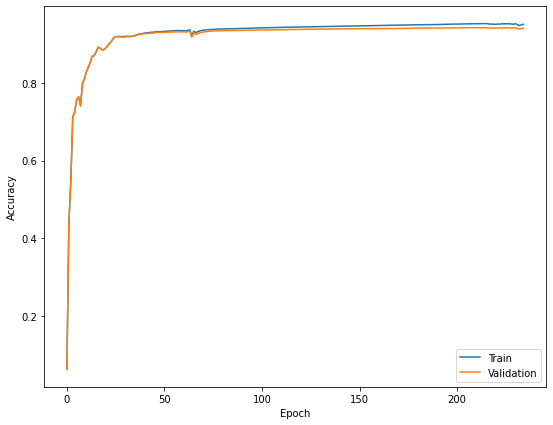

Epoch 0:   train_loss=25.5519 | train_acc=0.0091 | val_acc=0.0100
Epoch 10:  train_loss=3.5001 | train_acc=0.8039 | val_acc=0.8067
Epoch 20:  train_loss=1.8449 | train_acc=0.8904 | val_acc=0.8897
Epoch 30:  train_loss=1.4440 | train_acc=0.9149 | val_acc=0.9154
Epoch 40:  train_loss=1.1852 | train_acc=0.9259 | val_acc=0.9249
Epoch 50:  train_loss=1.0252 | train_acc=0.9297 | val_acc=0.9291
Epoch 60:  train_loss=0.8950 | train_acc=0.9331 | val_acc=0.9317
Epoch 70:  train_loss=0.7875 | train_acc=0.9357 | val_acc=0.9342
Epoch 80:  train_loss=0.7032 | train_acc=0.9373 | val_acc=0.9362
Epoch 90:  train_loss=0.6816 | train_acc=0.9380 | val_acc=0.9366
Epoch 100: train_loss=0.7209 | train_acc=0.9393 | val_acc=0.9372
Epoch 110: train_loss=0.6438 | train_acc=0.9405 | val_acc=0.9373
Epoch 120: train_loss=0.5565 | train_acc=0.9421 | val_acc=0.9388
Epoch 130: train_loss=0.4919 | train_acc=0.9434 | val_acc=0.9395
Epoch 140: train_loss=0.4427 | train_acc=0.9449 | val_acc=0.9404
Epoch 150: train_loss=0.

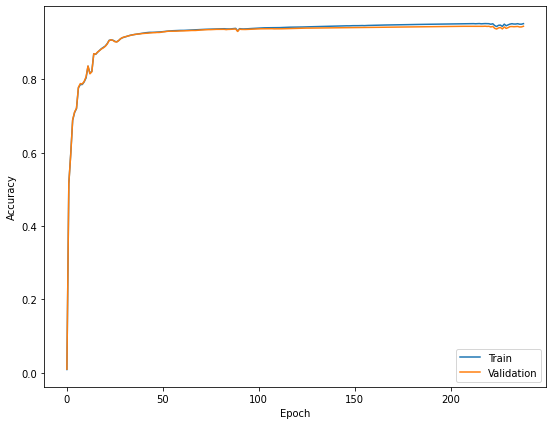

Epoch 0:   train_loss=31.4496 | train_acc=0.0194 | val_acc=0.0187
Epoch 10:  train_loss=4.8636 | train_acc=0.8192 | val_acc=0.8194
Epoch 20:  train_loss=2.9266 | train_acc=0.8781 | val_acc=0.8778
Epoch 30:  train_loss=1.4084 | train_acc=0.9116 | val_acc=0.9102
Epoch 40:  train_loss=1.2369 | train_acc=0.9219 | val_acc=0.9184
Epoch 50:  train_loss=1.0868 | train_acc=0.9291 | val_acc=0.9251
Epoch 60:  train_loss=0.9694 | train_acc=0.9320 | val_acc=0.9281
Epoch 70:  train_loss=0.8666 | train_acc=0.9337 | val_acc=0.9296
Epoch 80:  train_loss=0.7816 | train_acc=0.9354 | val_acc=0.9307
Epoch 90:  train_loss=0.7121 | train_acc=0.9374 | val_acc=0.9322
Epoch 100: train_loss=0.6532 | train_acc=0.9391 | val_acc=0.9338
Epoch 110: train_loss=0.6024 | train_acc=0.9404 | val_acc=0.9345
Epoch 120: train_loss=0.5583 | train_acc=0.9415 | val_acc=0.9354
Epoch 130: train_loss=0.5200 | train_acc=0.9424 | val_acc=0.9358
Epoch 140: train_loss=0.4868 | train_acc=0.9434 | val_acc=0.9364
Epoch 150: train_loss=0.

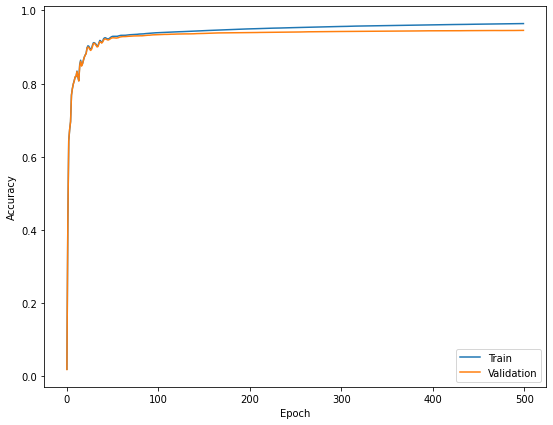

Epoch 0:   train_loss=28.2097 | train_acc=0.0040 | val_acc=0.0035
Epoch 10:  train_loss=2.0967 | train_acc=0.8661 | val_acc=0.8661
Epoch 20:  train_loss=1.2887 | train_acc=0.9145 | val_acc=0.9119
Epoch 30:  train_loss=1.1613 | train_acc=0.9217 | val_acc=0.9192
Epoch 40:  train_loss=1.0201 | train_acc=0.9295 | val_acc=0.9272
Epoch 50:  train_loss=0.8923 | train_acc=0.9332 | val_acc=0.9304
Epoch 60:  train_loss=0.7936 | train_acc=0.9354 | val_acc=0.9327
Epoch 70:  train_loss=0.7053 | train_acc=0.9381 | val_acc=0.9340
Epoch 80:  train_loss=0.6473 | train_acc=0.9398 | val_acc=0.9356
Epoch 90:  train_loss=0.5784 | train_acc=0.9409 | val_acc=0.9364
Epoch 100: train_loss=0.5337 | train_acc=0.9421 | val_acc=0.9379
Epoch 110: train_loss=0.4810 | train_acc=0.9433 | val_acc=0.9381
Epoch 120: train_loss=0.4430 | train_acc=0.9445 | val_acc=0.9387
Epoch 130: train_loss=0.4177 | train_acc=0.9452 | val_acc=0.9391
Epoch 140: train_loss=0.3796 | train_acc=0.9462 | val_acc=0.9394
Epoch 150: train_loss=0.

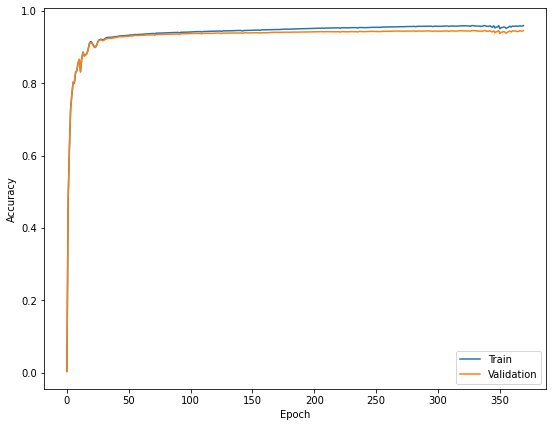

Epoch 0:   train_loss=36.8046 | train_acc=0.0058 | val_acc=0.0061
Epoch 10:  train_loss=3.8690 | train_acc=0.8103 | val_acc=0.8120
Epoch 20:  train_loss=2.4697 | train_acc=0.8991 | val_acc=0.9007
Epoch 30:  train_loss=2.0153 | train_acc=0.9158 | val_acc=0.9171
Epoch 40:  train_loss=1.6650 | train_acc=0.9251 | val_acc=0.9238
Epoch 50:  train_loss=1.4246 | train_acc=0.9294 | val_acc=0.9284
Epoch 60:  train_loss=1.2383 | train_acc=0.9327 | val_acc=0.9310
Epoch 70:  train_loss=1.0973 | train_acc=0.9351 | val_acc=0.9331
Epoch 80:  train_loss=0.9871 | train_acc=0.9367 | val_acc=0.9343
Epoch 90:  train_loss=0.8939 | train_acc=0.9381 | val_acc=0.9354
Epoch 100: train_loss=0.8125 | train_acc=0.9393 | val_acc=0.9365
Epoch 110: train_loss=0.7401 | train_acc=0.9403 | val_acc=0.9371
Epoch 120: train_loss=0.6760 | train_acc=0.9413 | val_acc=0.9381
Epoch 130: train_loss=0.6204 | train_acc=0.9419 | val_acc=0.9385
Epoch 140: train_loss=0.5704 | train_acc=0.9430 | val_acc=0.9390
Epoch 150: train_loss=0.

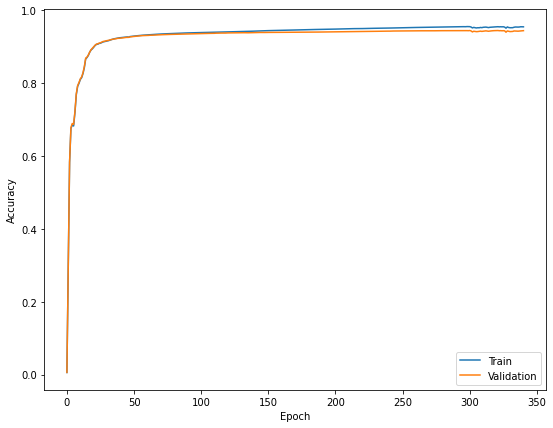

Reddit: test_accuracy=0.941±0.007


In [ ]:
num_graff_layers = 4
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

---
## Flickr
Define the hyperparameters for this section.

In [13]:
hidden_dim = 128
learning_rate = 0.001
num_decoder_layers = 3

Download the Flickr dataset and get the corresponding diffusion operators.

In [7]:
dataset = Flickr(root='/tmp', transform=ToUndirected())
print('Loading diffusion operators...')
diffusion_ops = get_diffusion_ops(dataset)
print('Done!')

num_features = dataset.num_features
num_classes = dataset.num_classes

Processing...
Done!


Loading diffusion operators...
Done!


### Multi-layer Perceptron

Epoch 0:   train_loss=2.2639 | train_acc=0.1411 | val_acc=0.1434
Epoch 10:  train_loss=1.6118 | train_acc=0.4346 | val_acc=0.4420
Epoch 20:  train_loss=1.5604 | train_acc=0.4491 | val_acc=0.4503
Epoch 30:  train_loss=1.5283 | train_acc=0.4595 | val_acc=0.4590
Epoch 40:  train_loss=1.5070 | train_acc=0.4655 | val_acc=0.4599
Epoch 50:  train_loss=1.4892 | train_acc=0.4702 | val_acc=0.4606
Epoch 60:  train_loss=1.4741 | train_acc=0.4735 | val_acc=0.4627
Epoch 70:  train_loss=1.4607 | train_acc=0.4774 | val_acc=0.4626
Early stopping after 74 epochs
Test accuracy: 0.4588


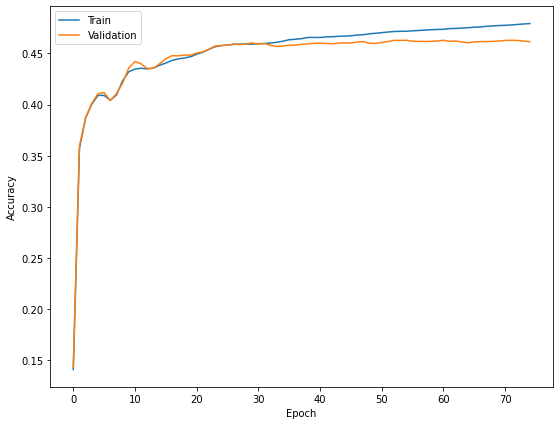

Epoch 0:   train_loss=2.6793 | train_acc=0.2004 | val_acc=0.2004
Epoch 10:  train_loss=1.6548 | train_acc=0.4026 | val_acc=0.3952
Epoch 20:  train_loss=1.6005 | train_acc=0.4218 | val_acc=0.4196
Epoch 30:  train_loss=1.5666 | train_acc=0.4500 | val_acc=0.4416
Epoch 40:  train_loss=1.5426 | train_acc=0.4533 | val_acc=0.4493
Epoch 50:  train_loss=1.5248 | train_acc=0.4594 | val_acc=0.4530
Epoch 60:  train_loss=1.5095 | train_acc=0.4623 | val_acc=0.4571
Epoch 70:  train_loss=1.4960 | train_acc=0.4653 | val_acc=0.4583
Epoch 80:  train_loss=1.4839 | train_acc=0.4681 | val_acc=0.4593
Epoch 90:  train_loss=1.4728 | train_acc=0.4716 | val_acc=0.4602
Epoch 100: train_loss=1.4625 | train_acc=0.4737 | val_acc=0.4605
Epoch 110: train_loss=1.4527 | train_acc=0.4765 | val_acc=0.4607
Early stopping after 114 epochs
Test accuracy: 0.4556


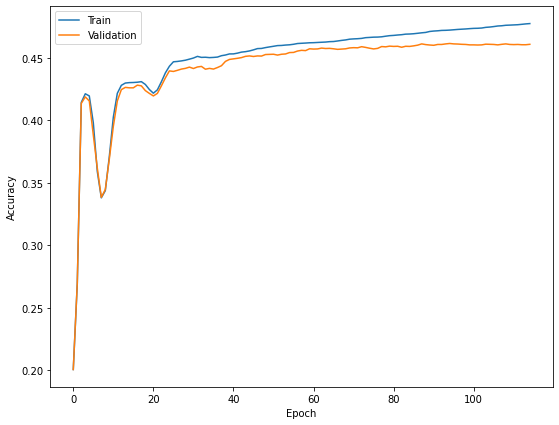

Epoch 0:   train_loss=2.8131 | train_acc=0.1472 | val_acc=0.1462
Epoch 10:  train_loss=1.6770 | train_acc=0.3673 | val_acc=0.3671
Epoch 20:  train_loss=1.6010 | train_acc=0.4289 | val_acc=0.4317
Epoch 30:  train_loss=1.5700 | train_acc=0.4471 | val_acc=0.4419
Epoch 40:  train_loss=1.5458 | train_acc=0.4510 | val_acc=0.4440
Epoch 50:  train_loss=1.5270 | train_acc=0.4574 | val_acc=0.4476
Epoch 60:  train_loss=1.5107 | train_acc=0.4619 | val_acc=0.4499
Epoch 70:  train_loss=1.4962 | train_acc=0.4658 | val_acc=0.4529
Epoch 80:  train_loss=1.4829 | train_acc=0.4698 | val_acc=0.4542
Epoch 90:  train_loss=1.4704 | train_acc=0.4729 | val_acc=0.4555
Epoch 100: train_loss=1.4586 | train_acc=0.4764 | val_acc=0.4539
Epoch 110: train_loss=1.4473 | train_acc=0.4799 | val_acc=0.4559
Epoch 120: train_loss=1.4364 | train_acc=0.4837 | val_acc=0.4578
Epoch 130: train_loss=1.4259 | train_acc=0.4871 | val_acc=0.4595
Epoch 140: train_loss=1.4157 | train_acc=0.4905 | val_acc=0.4597
Epoch 150: train_loss=1.4

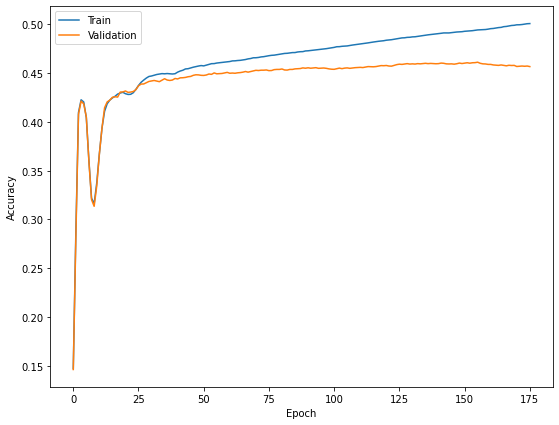

Epoch 0:   train_loss=2.5879 | train_acc=0.1339 | val_acc=0.1361
Epoch 10:  train_loss=1.6618 | train_acc=0.4255 | val_acc=0.4239
Epoch 20:  train_loss=1.6003 | train_acc=0.4361 | val_acc=0.4328
Epoch 30:  train_loss=1.5638 | train_acc=0.4522 | val_acc=0.4471
Epoch 40:  train_loss=1.5408 | train_acc=0.4578 | val_acc=0.4484
Epoch 50:  train_loss=1.5225 | train_acc=0.4614 | val_acc=0.4492
Epoch 60:  train_loss=1.5062 | train_acc=0.4650 | val_acc=0.4524
Epoch 70:  train_loss=1.4917 | train_acc=0.4690 | val_acc=0.4531
Epoch 80:  train_loss=1.4787 | train_acc=0.4732 | val_acc=0.4557
Epoch 90:  train_loss=1.4667 | train_acc=0.4765 | val_acc=0.4562
Epoch 100: train_loss=1.4555 | train_acc=0.4794 | val_acc=0.4564
Epoch 110: train_loss=1.4450 | train_acc=0.4818 | val_acc=0.4554
Early stopping after 117 epochs
Test accuracy: 0.4579


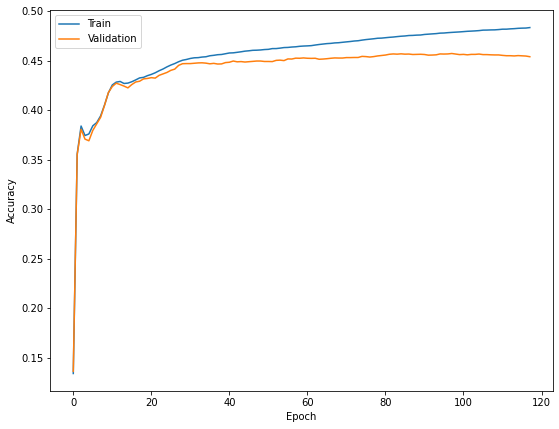

Epoch 0:   train_loss=2.9142 | train_acc=0.0926 | val_acc=0.0905
Epoch 10:  train_loss=1.6913 | train_acc=0.3646 | val_acc=0.3582
Epoch 20:  train_loss=1.5910 | train_acc=0.4405 | val_acc=0.4332
Epoch 30:  train_loss=1.5562 | train_acc=0.4462 | val_acc=0.4389
Epoch 40:  train_loss=1.5357 | train_acc=0.4534 | val_acc=0.4452
Epoch 50:  train_loss=1.5185 | train_acc=0.4596 | val_acc=0.4459
Epoch 60:  train_loss=1.5041 | train_acc=0.4633 | val_acc=0.4499
Epoch 70:  train_loss=1.4918 | train_acc=0.4668 | val_acc=0.4517
Epoch 80:  train_loss=1.4806 | train_acc=0.4699 | val_acc=0.4530
Epoch 90:  train_loss=1.4703 | train_acc=0.4727 | val_acc=0.4545
Epoch 100: train_loss=1.4607 | train_acc=0.4756 | val_acc=0.4551
Epoch 110: train_loss=1.4513 | train_acc=0.4782 | val_acc=0.4559
Epoch 120: train_loss=1.4422 | train_acc=0.4808 | val_acc=0.4569
Epoch 130: train_loss=1.4334 | train_acc=0.4832 | val_acc=0.4571
Epoch 140: train_loss=1.4248 | train_acc=0.4854 | val_acc=0.4570
Early stopping after 142 

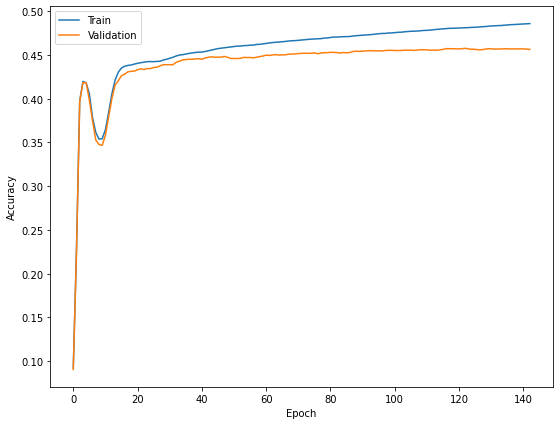

Epoch 0:   train_loss=3.1064 | train_acc=0.0599 | val_acc=0.0586
Epoch 10:  train_loss=1.6872 | train_acc=0.4085 | val_acc=0.4038
Epoch 20:  train_loss=1.5989 | train_acc=0.4398 | val_acc=0.4352
Epoch 30:  train_loss=1.5618 | train_acc=0.4447 | val_acc=0.4398
Epoch 40:  train_loss=1.5371 | train_acc=0.4533 | val_acc=0.4484
Epoch 50:  train_loss=1.5190 | train_acc=0.4588 | val_acc=0.4520
Epoch 60:  train_loss=1.5037 | train_acc=0.4639 | val_acc=0.4561
Epoch 70:  train_loss=1.4905 | train_acc=0.4675 | val_acc=0.4560
Epoch 80:  train_loss=1.4789 | train_acc=0.4710 | val_acc=0.4584
Epoch 90:  train_loss=1.4684 | train_acc=0.4734 | val_acc=0.4611
Epoch 100: train_loss=1.4586 | train_acc=0.4769 | val_acc=0.4622
Epoch 110: train_loss=1.4494 | train_acc=0.4800 | val_acc=0.4617
Early stopping after 120 epochs
Test accuracy: 0.4581


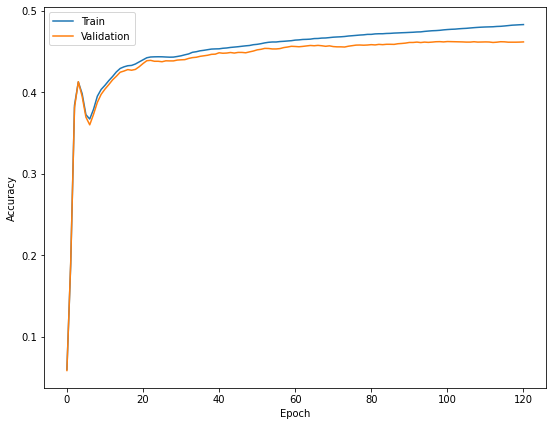

Epoch 0:   train_loss=2.2377 | train_acc=0.1842 | val_acc=0.1852
Epoch 10:  train_loss=1.6455 | train_acc=0.4264 | val_acc=0.4264
Epoch 20:  train_loss=1.5878 | train_acc=0.4422 | val_acc=0.4413
Epoch 30:  train_loss=1.5559 | train_acc=0.4490 | val_acc=0.4490
Epoch 40:  train_loss=1.5340 | train_acc=0.4563 | val_acc=0.4522
Epoch 50:  train_loss=1.5168 | train_acc=0.4612 | val_acc=0.4542
Epoch 60:  train_loss=1.5019 | train_acc=0.4642 | val_acc=0.4564
Epoch 70:  train_loss=1.4885 | train_acc=0.4677 | val_acc=0.4588
Epoch 80:  train_loss=1.4760 | train_acc=0.4706 | val_acc=0.4618
Epoch 90:  train_loss=1.4640 | train_acc=0.4744 | val_acc=0.4623
Epoch 100: train_loss=1.4526 | train_acc=0.4777 | val_acc=0.4618
Early stopping after 109 epochs
Test accuracy: 0.4613


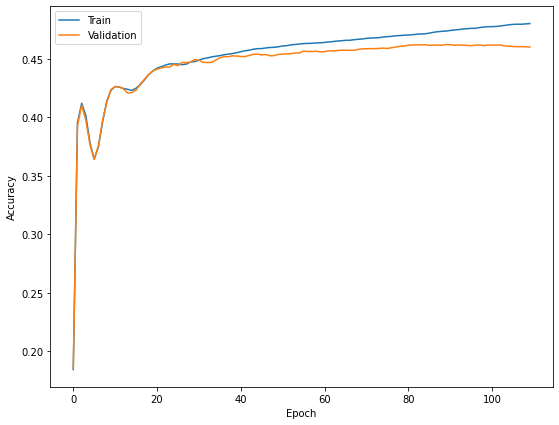

Epoch 0:   train_loss=2.3306 | train_acc=0.1283 | val_acc=0.1269
Epoch 10:  train_loss=1.6419 | train_acc=0.4214 | val_acc=0.4103
Epoch 20:  train_loss=1.5767 | train_acc=0.4428 | val_acc=0.4343
Epoch 30:  train_loss=1.5479 | train_acc=0.4514 | val_acc=0.4419
Epoch 40:  train_loss=1.5253 | train_acc=0.4570 | val_acc=0.4473
Epoch 50:  train_loss=1.5068 | train_acc=0.4623 | val_acc=0.4506
Epoch 60:  train_loss=1.4911 | train_acc=0.4659 | val_acc=0.4541
Epoch 70:  train_loss=1.4774 | train_acc=0.4701 | val_acc=0.4550
Epoch 80:  train_loss=1.4651 | train_acc=0.4740 | val_acc=0.4570
Epoch 90:  train_loss=1.4538 | train_acc=0.4770 | val_acc=0.4573
Epoch 100: train_loss=1.4432 | train_acc=0.4798 | val_acc=0.4573
Early stopping after 109 epochs
Test accuracy: 0.4577


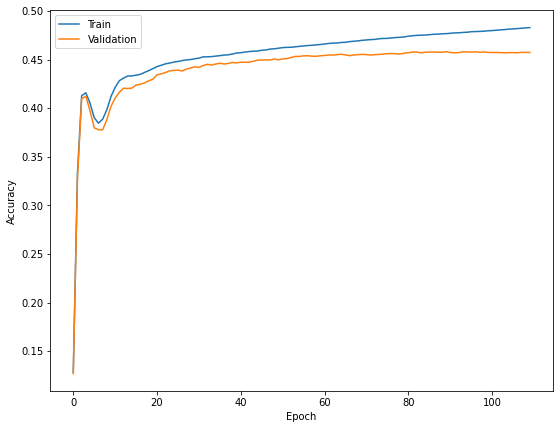

Epoch 0:   train_loss=2.6534 | train_acc=0.1149 | val_acc=0.1139
Epoch 10:  train_loss=1.6806 | train_acc=0.3987 | val_acc=0.4021
Epoch 20:  train_loss=1.5911 | train_acc=0.4378 | val_acc=0.4326
Epoch 30:  train_loss=1.5482 | train_acc=0.4488 | val_acc=0.4437
Epoch 40:  train_loss=1.5260 | train_acc=0.4538 | val_acc=0.4508
Epoch 50:  train_loss=1.5082 | train_acc=0.4591 | val_acc=0.4549
Epoch 60:  train_loss=1.4932 | train_acc=0.4636 | val_acc=0.4588
Epoch 70:  train_loss=1.4803 | train_acc=0.4669 | val_acc=0.4602
Epoch 80:  train_loss=1.4684 | train_acc=0.4709 | val_acc=0.4607
Epoch 90:  train_loss=1.4571 | train_acc=0.4746 | val_acc=0.4597
Epoch 100: train_loss=1.4463 | train_acc=0.4776 | val_acc=0.4595
Early stopping after 101 epochs
Test accuracy: 0.4587


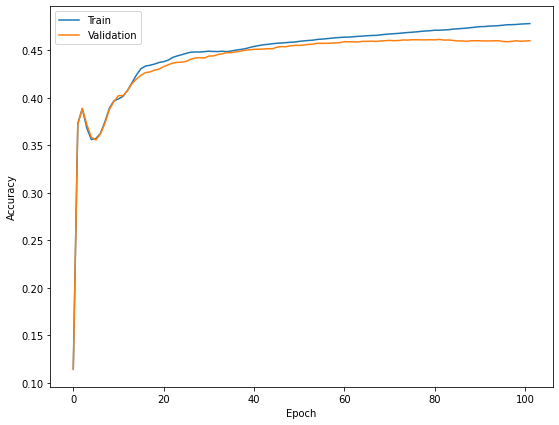

Epoch 0:   train_loss=2.3672 | train_acc=0.1172 | val_acc=0.1129
Epoch 10:  train_loss=1.6592 | train_acc=0.4137 | val_acc=0.4124
Epoch 20:  train_loss=1.5828 | train_acc=0.4396 | val_acc=0.4360
Epoch 30:  train_loss=1.5491 | train_acc=0.4513 | val_acc=0.4492
Epoch 40:  train_loss=1.5263 | train_acc=0.4591 | val_acc=0.4506
Epoch 50:  train_loss=1.5078 | train_acc=0.4655 | val_acc=0.4540
Epoch 60:  train_loss=1.4919 | train_acc=0.4686 | val_acc=0.4537
Epoch 70:  train_loss=1.4777 | train_acc=0.4727 | val_acc=0.4538
Early stopping after 73 epochs
Test accuracy: 0.4576


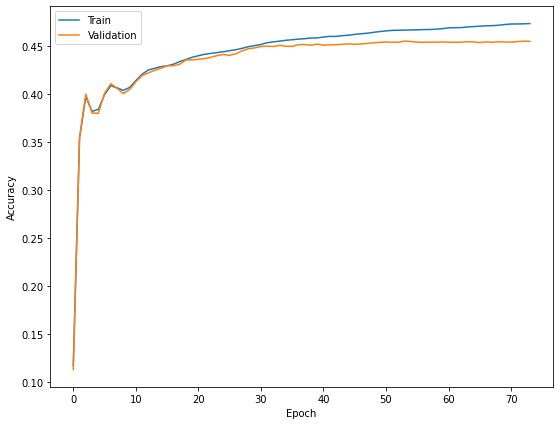

Flickr: test_accuracy=0.458±0.002


In [8]:
run_experiment(dataset, learning_rate, model_func_mlp, None)

### GRAFF

Epoch 0:   train_loss=2.3822 | train_acc=0.1994 | val_acc=0.2013
Epoch 10:  train_loss=1.7982 | train_acc=0.4207 | val_acc=0.4259
Epoch 20:  train_loss=1.5853 | train_acc=0.4353 | val_acc=0.4398
Epoch 30:  train_loss=1.5497 | train_acc=0.4530 | val_acc=0.4550
Epoch 40:  train_loss=1.5248 | train_acc=0.4613 | val_acc=0.4651
Epoch 50:  train_loss=1.4999 | train_acc=0.4675 | val_acc=0.4694
Epoch 60:  train_loss=1.4780 | train_acc=0.4737 | val_acc=0.4745
Epoch 70:  train_loss=1.4569 | train_acc=0.4796 | val_acc=0.4818
Epoch 80:  train_loss=1.4367 | train_acc=0.4858 | val_acc=0.4812
Epoch 90:  train_loss=1.4169 | train_acc=0.4914 | val_acc=0.4812
Epoch 100: train_loss=1.3967 | train_acc=0.4964 | val_acc=0.4825
Epoch 110: train_loss=1.3755 | train_acc=0.5038 | val_acc=0.4820
Epoch 120: train_loss=1.3529 | train_acc=0.5116 | val_acc=0.4807
Early stopping after 128 epochs
Test accuracy: 0.4655


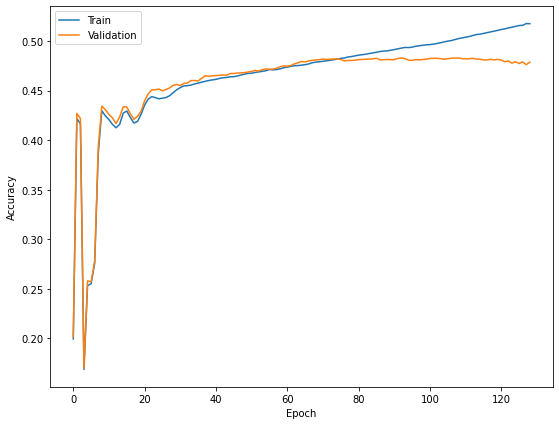

Epoch 0:   train_loss=2.8618 | train_acc=0.1061 | val_acc=0.1063
Epoch 10:  train_loss=1.7715 | train_acc=0.4348 | val_acc=0.4426
Epoch 20:  train_loss=1.5837 | train_acc=0.4476 | val_acc=0.4570
Epoch 30:  train_loss=1.5237 | train_acc=0.4598 | val_acc=0.4672
Epoch 40:  train_loss=1.4986 | train_acc=0.4674 | val_acc=0.4744
Epoch 50:  train_loss=1.4745 | train_acc=0.4715 | val_acc=0.4757
Epoch 60:  train_loss=1.4515 | train_acc=0.4793 | val_acc=0.4775
Epoch 70:  train_loss=1.4289 | train_acc=0.4850 | val_acc=0.4753
Epoch 80:  train_loss=1.4057 | train_acc=0.4926 | val_acc=0.4773
Epoch 90:  train_loss=1.3813 | train_acc=0.5010 | val_acc=0.4778
Epoch 100: train_loss=1.3555 | train_acc=0.5096 | val_acc=0.4765
Epoch 110: train_loss=1.3280 | train_acc=0.5189 | val_acc=0.4755
Early stopping after 111 epochs
Test accuracy: 0.4705


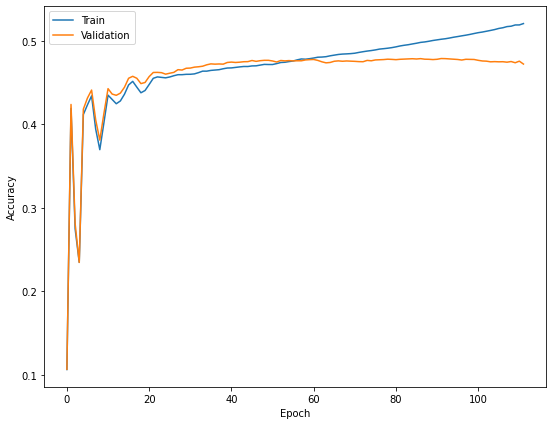

Epoch 0:   train_loss=3.3710 | train_acc=0.0671 | val_acc=0.0648
Epoch 10:  train_loss=1.7306 | train_acc=0.4284 | val_acc=0.4383
Epoch 20:  train_loss=1.5889 | train_acc=0.4442 | val_acc=0.4453
Epoch 30:  train_loss=1.5380 | train_acc=0.4610 | val_acc=0.4679
Epoch 40:  train_loss=1.5124 | train_acc=0.4641 | val_acc=0.4640
Epoch 50:  train_loss=1.4896 | train_acc=0.4697 | val_acc=0.4738
Epoch 60:  train_loss=1.4708 | train_acc=0.4757 | val_acc=0.4726
Epoch 70:  train_loss=1.4535 | train_acc=0.4801 | val_acc=0.4748
Epoch 80:  train_loss=1.4362 | train_acc=0.4850 | val_acc=0.4766
Epoch 90:  train_loss=1.4187 | train_acc=0.4898 | val_acc=0.4769
Epoch 100: train_loss=1.4004 | train_acc=0.4956 | val_acc=0.4759
Early stopping after 109 epochs
Test accuracy: 0.4741


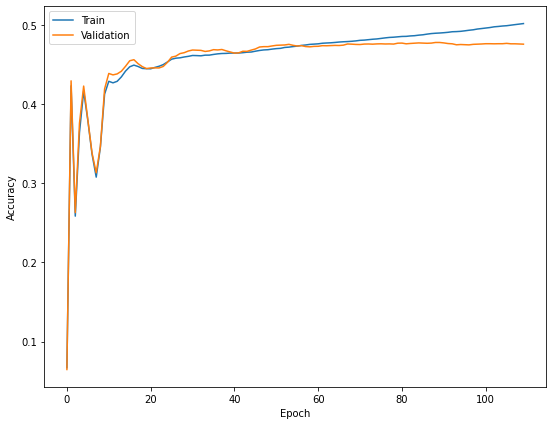

Epoch 0:   train_loss=3.0735 | train_acc=0.0583 | val_acc=0.0567
Epoch 10:  train_loss=1.8465 | train_acc=0.3770 | val_acc=0.3838
Epoch 20:  train_loss=1.5754 | train_acc=0.4482 | val_acc=0.4536
Epoch 30:  train_loss=1.5365 | train_acc=0.4581 | val_acc=0.4704
Epoch 40:  train_loss=1.5090 | train_acc=0.4655 | val_acc=0.4746
Epoch 50:  train_loss=1.4856 | train_acc=0.4708 | val_acc=0.4772
Epoch 60:  train_loss=1.4652 | train_acc=0.4772 | val_acc=0.4803
Epoch 70:  train_loss=1.4459 | train_acc=0.4826 | val_acc=0.4806
Epoch 80:  train_loss=1.4263 | train_acc=0.4891 | val_acc=0.4784
Early stopping after 86 epochs
Test accuracy: 0.4745


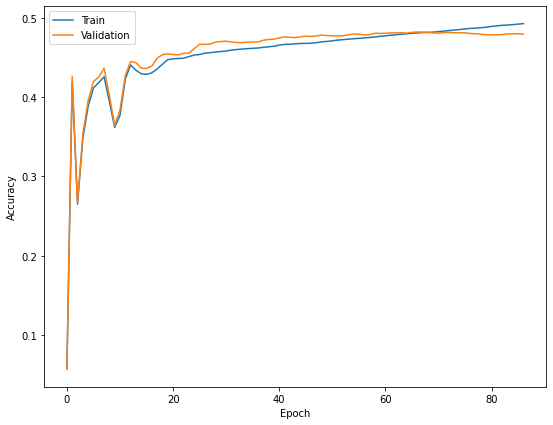

Epoch 0:   train_loss=2.5353 | train_acc=0.1028 | val_acc=0.0915
Epoch 10:  train_loss=1.6843 | train_acc=0.4008 | val_acc=0.4127
Epoch 20:  train_loss=1.5714 | train_acc=0.4439 | val_acc=0.4489
Epoch 30:  train_loss=1.5482 | train_acc=0.4517 | val_acc=0.4620
Epoch 40:  train_loss=1.5119 | train_acc=0.4630 | val_acc=0.4689
Epoch 50:  train_loss=1.4891 | train_acc=0.4694 | val_acc=0.4780
Epoch 60:  train_loss=1.4683 | train_acc=0.4759 | val_acc=0.4799
Epoch 70:  train_loss=1.4483 | train_acc=0.4818 | val_acc=0.4809
Epoch 80:  train_loss=1.4289 | train_acc=0.4873 | val_acc=0.4824
Epoch 90:  train_loss=1.4092 | train_acc=0.4944 | val_acc=0.4818
Epoch 100: train_loss=1.3888 | train_acc=0.5014 | val_acc=0.4819
Early stopping after 107 epochs
Test accuracy: 0.4720


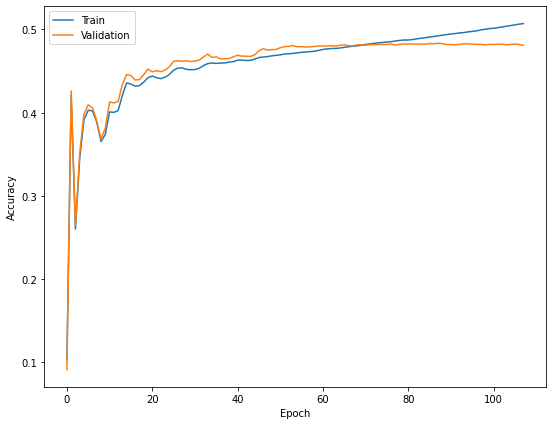

Epoch 0:   train_loss=2.6755 | train_acc=0.1256 | val_acc=0.1207
Epoch 10:  train_loss=1.6825 | train_acc=0.4446 | val_acc=0.4499
Epoch 20:  train_loss=1.5712 | train_acc=0.4507 | val_acc=0.4580
Epoch 30:  train_loss=1.5244 | train_acc=0.4635 | val_acc=0.4715
Epoch 40:  train_loss=1.5009 | train_acc=0.4691 | val_acc=0.4745
Epoch 50:  train_loss=1.4745 | train_acc=0.4755 | val_acc=0.4775
Epoch 60:  train_loss=1.4531 | train_acc=0.4804 | val_acc=0.4824
Epoch 70:  train_loss=1.4314 | train_acc=0.4879 | val_acc=0.4836
Epoch 80:  train_loss=1.4099 | train_acc=0.4938 | val_acc=0.4855
Epoch 90:  train_loss=1.3874 | train_acc=0.5013 | val_acc=0.4817
Early stopping after 100 epochs
Test accuracy: 0.4739


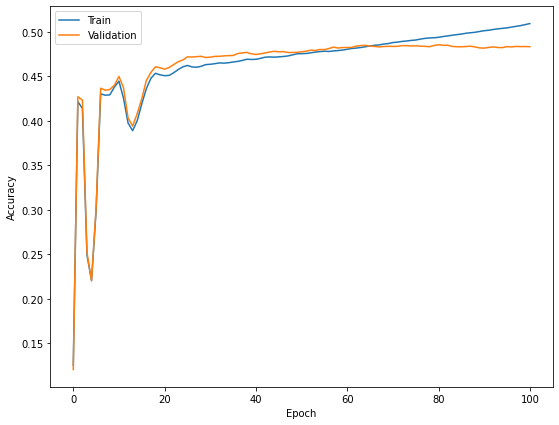

Epoch 0:   train_loss=2.2740 | train_acc=0.2927 | val_acc=0.2915
Epoch 10:  train_loss=1.6911 | train_acc=0.4435 | val_acc=0.4517
Epoch 20:  train_loss=1.5604 | train_acc=0.4482 | val_acc=0.4599
Epoch 30:  train_loss=1.5268 | train_acc=0.4579 | val_acc=0.4644
Epoch 40:  train_loss=1.4992 | train_acc=0.4661 | val_acc=0.4713
Epoch 50:  train_loss=1.4773 | train_acc=0.4728 | val_acc=0.4751
Epoch 60:  train_loss=1.4559 | train_acc=0.4811 | val_acc=0.4771
Epoch 70:  train_loss=1.4351 | train_acc=0.4875 | val_acc=0.4772
Early stopping after 78 epochs
Test accuracy: 0.4715


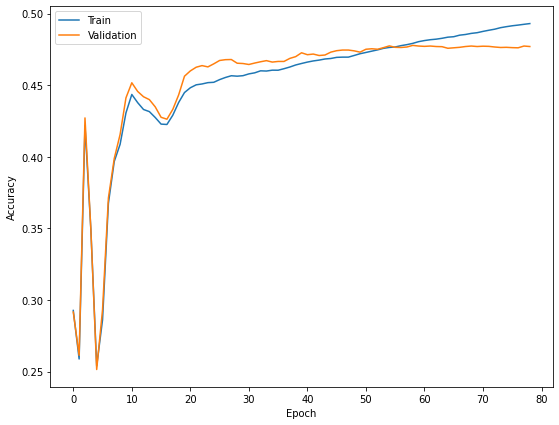

Epoch 0:   train_loss=2.3701 | train_acc=0.1833 | val_acc=0.1843
Epoch 10:  train_loss=1.7383 | train_acc=0.4257 | val_acc=0.4304
Epoch 20:  train_loss=1.5709 | train_acc=0.4484 | val_acc=0.4548
Epoch 30:  train_loss=1.5355 | train_acc=0.4591 | val_acc=0.4651
Epoch 40:  train_loss=1.5050 | train_acc=0.4665 | val_acc=0.4696
Epoch 50:  train_loss=1.4834 | train_acc=0.4719 | val_acc=0.4720
Epoch 60:  train_loss=1.4636 | train_acc=0.4781 | val_acc=0.4750
Epoch 70:  train_loss=1.4452 | train_acc=0.4830 | val_acc=0.4769
Epoch 80:  train_loss=1.4269 | train_acc=0.4882 | val_acc=0.4775
Epoch 90:  train_loss=1.4082 | train_acc=0.4935 | val_acc=0.4784
Epoch 100: train_loss=1.3882 | train_acc=0.4989 | val_acc=0.4797
Epoch 110: train_loss=1.3666 | train_acc=0.5063 | val_acc=0.4790
Epoch 120: train_loss=1.3428 | train_acc=0.5134 | val_acc=0.4776
Early stopping after 125 epochs
Test accuracy: 0.4697


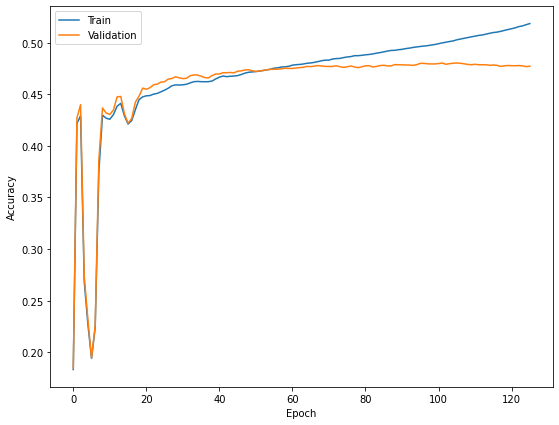

Epoch 0:   train_loss=2.6548 | train_acc=0.1015 | val_acc=0.1008
Epoch 10:  train_loss=1.6744 | train_acc=0.4329 | val_acc=0.4465
Epoch 20:  train_loss=1.5884 | train_acc=0.4479 | val_acc=0.4559
Epoch 30:  train_loss=1.5382 | train_acc=0.4576 | val_acc=0.4671
Epoch 40:  train_loss=1.5058 | train_acc=0.4643 | val_acc=0.4717
Epoch 50:  train_loss=1.4831 | train_acc=0.4706 | val_acc=0.4788
Epoch 60:  train_loss=1.4624 | train_acc=0.4764 | val_acc=0.4781
Epoch 70:  train_loss=1.4425 | train_acc=0.4825 | val_acc=0.4832
Epoch 80:  train_loss=1.4235 | train_acc=0.4888 | val_acc=0.4811
Early stopping after 89 epochs
Test accuracy: 0.4728


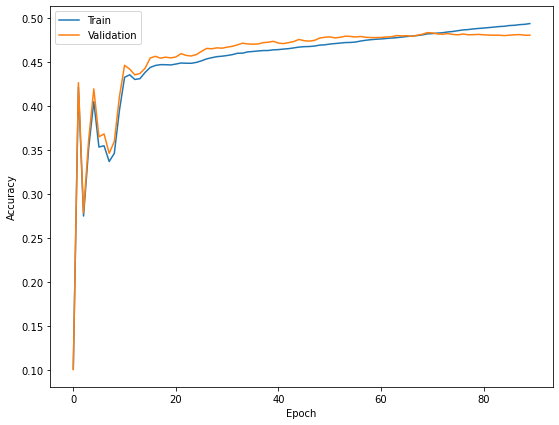

Epoch 0:   train_loss=3.3302 | train_acc=0.0624 | val_acc=0.0566
Epoch 10:  train_loss=1.7481 | train_acc=0.4295 | val_acc=0.4315
Epoch 20:  train_loss=1.5818 | train_acc=0.4435 | val_acc=0.4518
Epoch 30:  train_loss=1.5303 | train_acc=0.4566 | val_acc=0.4602
Epoch 40:  train_loss=1.5040 | train_acc=0.4653 | val_acc=0.4668
Epoch 50:  train_loss=1.4801 | train_acc=0.4704 | val_acc=0.4711
Epoch 60:  train_loss=1.4589 | train_acc=0.4766 | val_acc=0.4741
Epoch 70:  train_loss=1.4378 | train_acc=0.4840 | val_acc=0.4742
Epoch 80:  train_loss=1.4170 | train_acc=0.4916 | val_acc=0.4762
Epoch 90:  train_loss=1.3958 | train_acc=0.4984 | val_acc=0.4761
Early stopping after 99 epochs
Test accuracy: 0.4705


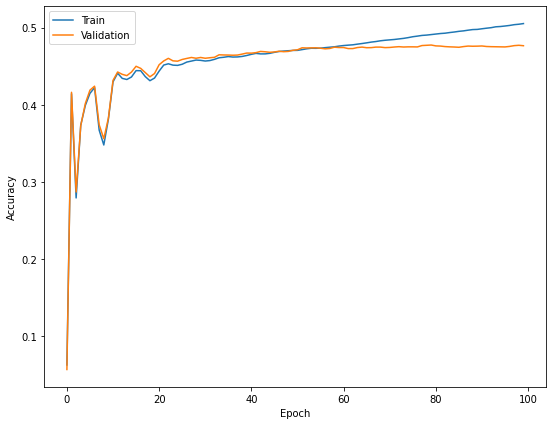

Flickr: test_accuracy=0.472±0.003


In [9]:
num_graff_layers = 1
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

Epoch 0:   train_loss=7.1097 | train_acc=0.0962 | val_acc=0.0906
Epoch 10:  train_loss=2.5755 | train_acc=0.3855 | val_acc=0.3939
Epoch 20:  train_loss=1.6528 | train_acc=0.4721 | val_acc=0.4751
Epoch 30:  train_loss=1.5416 | train_acc=0.4772 | val_acc=0.4738
Epoch 40:  train_loss=1.4953 | train_acc=0.4872 | val_acc=0.4861
Epoch 50:  train_loss=1.4633 | train_acc=0.4930 | val_acc=0.4920
Epoch 60:  train_loss=1.4342 | train_acc=0.4995 | val_acc=0.4968
Epoch 70:  train_loss=1.4124 | train_acc=0.5082 | val_acc=0.5006
Epoch 80:  train_loss=1.3925 | train_acc=0.5128 | val_acc=0.5067
Epoch 90:  train_loss=1.3760 | train_acc=0.5174 | val_acc=0.5097
Epoch 100: train_loss=1.3621 | train_acc=0.5200 | val_acc=0.5094
Epoch 110: train_loss=1.3489 | train_acc=0.5253 | val_acc=0.5095
Epoch 120: train_loss=1.3361 | train_acc=0.5295 | val_acc=0.5127
Epoch 130: train_loss=1.3259 | train_acc=0.5326 | val_acc=0.5114
Epoch 140: train_loss=1.3142 | train_acc=0.5359 | val_acc=0.5129
Epoch 150: train_loss=1.3

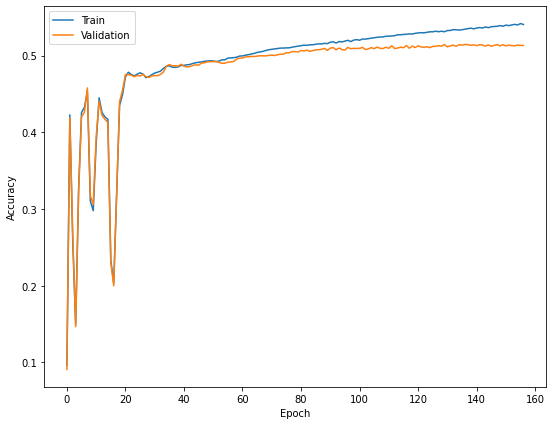

Epoch 0:   train_loss=3.1996 | train_acc=0.1219 | val_acc=0.1220
Epoch 10:  train_loss=4.5703 | train_acc=0.3246 | val_acc=0.3150
Epoch 20:  train_loss=1.8379 | train_acc=0.4344 | val_acc=0.4300
Epoch 30:  train_loss=1.6052 | train_acc=0.4684 | val_acc=0.4641
Epoch 40:  train_loss=1.5091 | train_acc=0.4805 | val_acc=0.4755
Epoch 50:  train_loss=1.4696 | train_acc=0.4906 | val_acc=0.4890
Epoch 60:  train_loss=1.4379 | train_acc=0.4953 | val_acc=0.4945
Epoch 70:  train_loss=1.4143 | train_acc=0.5024 | val_acc=0.5026
Epoch 80:  train_loss=1.3935 | train_acc=0.5089 | val_acc=0.5055
Epoch 90:  train_loss=1.3765 | train_acc=0.5142 | val_acc=0.5082
Epoch 100: train_loss=1.3616 | train_acc=0.5191 | val_acc=0.5082
Epoch 110: train_loss=1.3485 | train_acc=0.5231 | val_acc=0.5087
Epoch 120: train_loss=1.3358 | train_acc=0.5270 | val_acc=0.5077
Early stopping after 125 epochs
Test accuracy: 0.4994


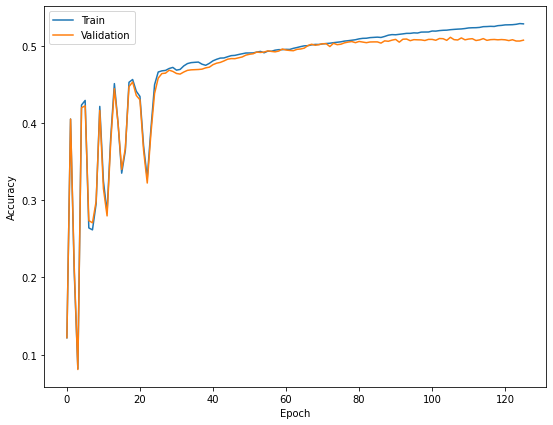

Epoch 0:   train_loss=4.8276 | train_acc=0.1956 | val_acc=0.2009
Epoch 10:  train_loss=2.1830 | train_acc=0.4256 | val_acc=0.4192
Epoch 20:  train_loss=1.7678 | train_acc=0.4322 | val_acc=0.4248
Epoch 30:  train_loss=1.5559 | train_acc=0.4747 | val_acc=0.4815
Epoch 40:  train_loss=1.5143 | train_acc=0.4787 | val_acc=0.4828
Epoch 50:  train_loss=1.4754 | train_acc=0.4870 | val_acc=0.4917
Epoch 60:  train_loss=1.4426 | train_acc=0.4960 | val_acc=0.4994
Epoch 70:  train_loss=1.4178 | train_acc=0.5032 | val_acc=0.5014
Epoch 80:  train_loss=1.3982 | train_acc=0.5094 | val_acc=0.5073
Epoch 90:  train_loss=1.3814 | train_acc=0.5137 | val_acc=0.5111
Epoch 100: train_loss=1.3667 | train_acc=0.5174 | val_acc=0.5119
Epoch 110: train_loss=1.3543 | train_acc=0.5206 | val_acc=0.5162
Epoch 120: train_loss=1.3412 | train_acc=0.5251 | val_acc=0.5178
Epoch 130: train_loss=1.3299 | train_acc=0.5292 | val_acc=0.5156
Early stopping after 140 epochs
Test accuracy: 0.5016


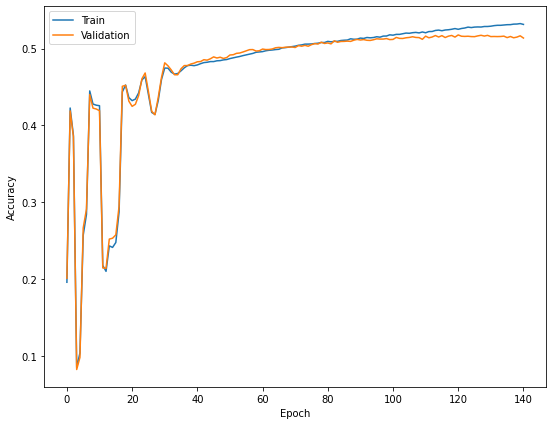

Epoch 0:   train_loss=6.8777 | train_acc=0.0550 | val_acc=0.0564
Epoch 10:  train_loss=3.7579 | train_acc=0.2927 | val_acc=0.3016
Epoch 20:  train_loss=2.0491 | train_acc=0.3844 | val_acc=0.3901
Epoch 30:  train_loss=1.5783 | train_acc=0.4504 | val_acc=0.4546
Epoch 40:  train_loss=1.5231 | train_acc=0.4690 | val_acc=0.4692
Epoch 50:  train_loss=1.4835 | train_acc=0.4821 | val_acc=0.4838
Epoch 60:  train_loss=1.4531 | train_acc=0.4915 | val_acc=0.4969
Epoch 70:  train_loss=1.4296 | train_acc=0.4997 | val_acc=0.5032
Epoch 80:  train_loss=1.4116 | train_acc=0.5044 | val_acc=0.5079
Epoch 90:  train_loss=1.3964 | train_acc=0.5084 | val_acc=0.5088
Epoch 100: train_loss=1.3822 | train_acc=0.5134 | val_acc=0.5089
Epoch 110: train_loss=1.3697 | train_acc=0.5170 | val_acc=0.5111
Epoch 120: train_loss=1.3581 | train_acc=0.5209 | val_acc=0.5133
Epoch 130: train_loss=1.3468 | train_acc=0.5241 | val_acc=0.5144
Epoch 140: train_loss=1.3373 | train_acc=0.5260 | val_acc=0.5145
Epoch 150: train_loss=1.3

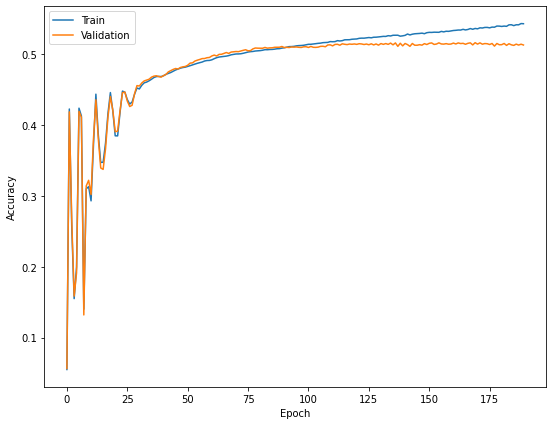

Epoch 0:   train_loss=3.5615 | train_acc=0.0805 | val_acc=0.0837
Epoch 10:  train_loss=3.2574 | train_acc=0.4643 | val_acc=0.4644
Epoch 20:  train_loss=1.7087 | train_acc=0.4344 | val_acc=0.4378
Epoch 30:  train_loss=1.5516 | train_acc=0.4762 | val_acc=0.4763
Epoch 40:  train_loss=1.4922 | train_acc=0.4876 | val_acc=0.4817
Epoch 50:  train_loss=1.4597 | train_acc=0.4913 | val_acc=0.4890
Epoch 60:  train_loss=1.4374 | train_acc=0.4968 | val_acc=0.4968
Epoch 70:  train_loss=1.4168 | train_acc=0.5038 | val_acc=0.5002
Epoch 80:  train_loss=1.3995 | train_acc=0.5094 | val_acc=0.5046
Epoch 90:  train_loss=1.3849 | train_acc=0.5136 | val_acc=0.5049
Epoch 100: train_loss=1.3705 | train_acc=0.5185 | val_acc=0.5053
Epoch 110: train_loss=1.3580 | train_acc=0.5228 | val_acc=0.5099
Epoch 120: train_loss=1.3464 | train_acc=0.5257 | val_acc=0.5113
Epoch 130: train_loss=1.3356 | train_acc=0.5282 | val_acc=0.5120
Epoch 140: train_loss=1.3276 | train_acc=0.5309 | val_acc=0.5109
Epoch 150: train_loss=1.3

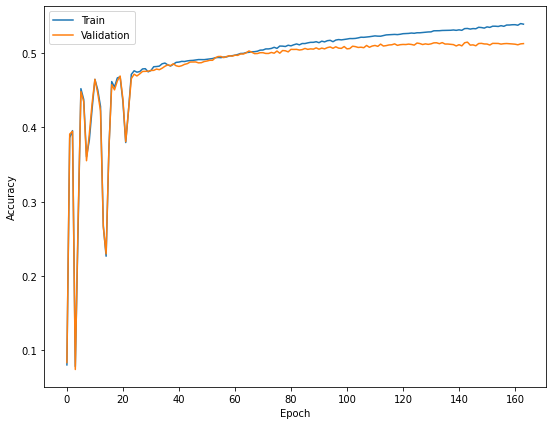

Epoch 0:   train_loss=2.8670 | train_acc=0.3346 | val_acc=0.3237
Epoch 10:  train_loss=3.5401 | train_acc=0.2829 | val_acc=0.2903
Epoch 20:  train_loss=1.6013 | train_acc=0.4484 | val_acc=0.4447
Epoch 30:  train_loss=1.5562 | train_acc=0.4716 | val_acc=0.4639
Epoch 40:  train_loss=1.5071 | train_acc=0.4801 | val_acc=0.4771
Epoch 50:  train_loss=1.4639 | train_acc=0.4926 | val_acc=0.4856
Epoch 60:  train_loss=1.4326 | train_acc=0.4973 | val_acc=0.4923
Epoch 70:  train_loss=1.4109 | train_acc=0.5036 | val_acc=0.4990
Epoch 80:  train_loss=1.3933 | train_acc=0.5095 | val_acc=0.5043
Epoch 90:  train_loss=1.3784 | train_acc=0.5139 | val_acc=0.5066
Epoch 100: train_loss=1.3649 | train_acc=0.5192 | val_acc=0.5107
Epoch 110: train_loss=1.3523 | train_acc=0.5235 | val_acc=0.5103
Early stopping after 119 epochs
Test accuracy: 0.5011


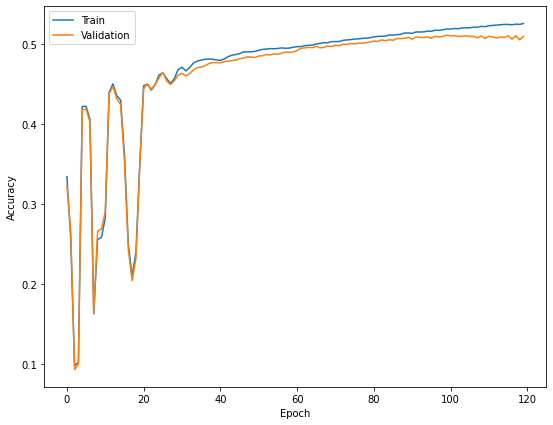

Epoch 0:   train_loss=5.4197 | train_acc=0.0454 | val_acc=0.0463
Epoch 10:  train_loss=2.5956 | train_acc=0.4355 | val_acc=0.4322
Epoch 20:  train_loss=1.9742 | train_acc=0.4404 | val_acc=0.4443
Epoch 30:  train_loss=1.5734 | train_acc=0.4593 | val_acc=0.4582
Epoch 40:  train_loss=1.5159 | train_acc=0.4804 | val_acc=0.4788
Epoch 50:  train_loss=1.4783 | train_acc=0.4891 | val_acc=0.4884
Epoch 60:  train_loss=1.4509 | train_acc=0.4952 | val_acc=0.4928
Epoch 70:  train_loss=1.4270 | train_acc=0.5015 | val_acc=0.5020
Epoch 80:  train_loss=1.4039 | train_acc=0.5093 | val_acc=0.5035
Epoch 90:  train_loss=1.3831 | train_acc=0.5150 | val_acc=0.5040
Epoch 100: train_loss=1.3646 | train_acc=0.5209 | val_acc=0.5080
Epoch 110: train_loss=1.3477 | train_acc=0.5257 | val_acc=0.5080
Epoch 120: train_loss=1.3334 | train_acc=0.5296 | val_acc=0.5129
Epoch 130: train_loss=1.3200 | train_acc=0.5338 | val_acc=0.5109
Early stopping after 140 epochs
Test accuracy: 0.5015


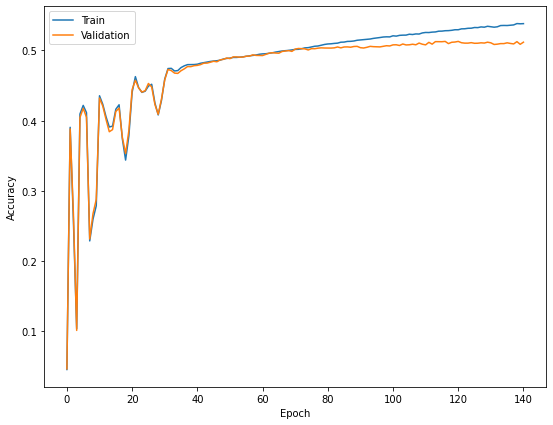

Epoch 0:   train_loss=6.4242 | train_acc=0.0723 | val_acc=0.0719
Epoch 10:  train_loss=3.6367 | train_acc=0.2559 | val_acc=0.2598
Epoch 20:  train_loss=1.7798 | train_acc=0.3139 | val_acc=0.3095
Epoch 30:  train_loss=1.6013 | train_acc=0.4581 | val_acc=0.4584
Epoch 40:  train_loss=1.5208 | train_acc=0.4760 | val_acc=0.4784
Epoch 50:  train_loss=1.4777 | train_acc=0.4869 | val_acc=0.4889
Epoch 60:  train_loss=1.4454 | train_acc=0.4940 | val_acc=0.4942
Epoch 70:  train_loss=1.4214 | train_acc=0.5005 | val_acc=0.4969
Epoch 80:  train_loss=1.4013 | train_acc=0.5075 | val_acc=0.5024
Epoch 90:  train_loss=1.3866 | train_acc=0.5131 | val_acc=0.5067
Epoch 100: train_loss=1.3724 | train_acc=0.5172 | val_acc=0.5082
Epoch 110: train_loss=1.3602 | train_acc=0.5205 | val_acc=0.5111
Epoch 120: train_loss=1.3485 | train_acc=0.5238 | val_acc=0.5118
Epoch 130: train_loss=1.3381 | train_acc=0.5273 | val_acc=0.5119
Epoch 140: train_loss=1.3297 | train_acc=0.5291 | val_acc=0.5094
Epoch 150: train_loss=1.3

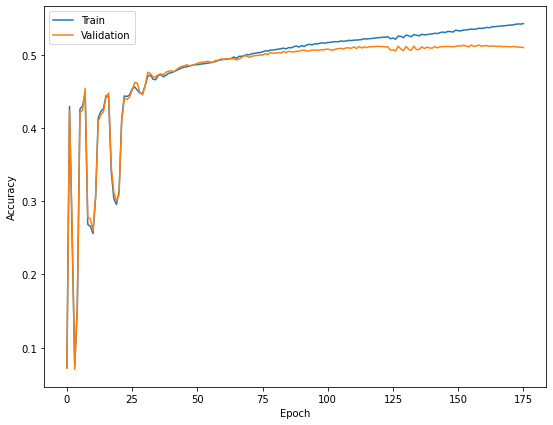

Epoch 0:   train_loss=6.0106 | train_acc=0.1037 | val_acc=0.0969
Epoch 10:  train_loss=2.0330 | train_acc=0.3863 | val_acc=0.3911
Epoch 20:  train_loss=1.6749 | train_acc=0.4094 | val_acc=0.4128
Epoch 30:  train_loss=1.5270 | train_acc=0.4812 | val_acc=0.4803
Epoch 40:  train_loss=1.4928 | train_acc=0.4867 | val_acc=0.4857
Epoch 50:  train_loss=1.4535 | train_acc=0.4937 | val_acc=0.5008
Epoch 60:  train_loss=1.4291 | train_acc=0.4986 | val_acc=0.4995
Epoch 70:  train_loss=1.4071 | train_acc=0.5064 | val_acc=0.5046
Epoch 80:  train_loss=1.3894 | train_acc=0.5111 | val_acc=0.5115
Epoch 90:  train_loss=1.3742 | train_acc=0.5158 | val_acc=0.5134
Epoch 100: train_loss=1.3610 | train_acc=0.5189 | val_acc=0.5138
Epoch 110: train_loss=1.3491 | train_acc=0.5231 | val_acc=0.5148
Epoch 120: train_loss=1.3387 | train_acc=0.5266 | val_acc=0.5152
Epoch 130: train_loss=1.3279 | train_acc=0.5285 | val_acc=0.5170
Epoch 140: train_loss=1.3208 | train_acc=0.5316 | val_acc=0.5156
Epoch 150: train_loss=1.3

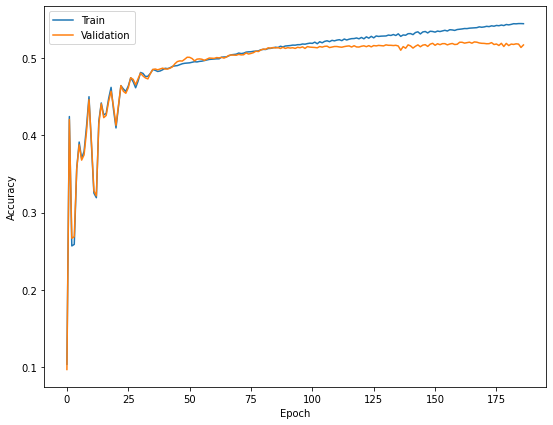

Epoch 0:   train_loss=7.2697 | train_acc=0.0690 | val_acc=0.0692
Epoch 10:  train_loss=2.7775 | train_acc=0.4344 | val_acc=0.4319
Epoch 20:  train_loss=1.7262 | train_acc=0.3755 | val_acc=0.3773
Epoch 30:  train_loss=1.5478 | train_acc=0.4738 | val_acc=0.4720
Epoch 40:  train_loss=1.4896 | train_acc=0.4864 | val_acc=0.4862
Epoch 50:  train_loss=1.4573 | train_acc=0.4919 | val_acc=0.4909
Epoch 60:  train_loss=1.4340 | train_acc=0.4979 | val_acc=0.4951
Epoch 70:  train_loss=1.4142 | train_acc=0.5053 | val_acc=0.5012
Epoch 80:  train_loss=1.3978 | train_acc=0.5106 | val_acc=0.5045
Epoch 90:  train_loss=1.3820 | train_acc=0.5149 | val_acc=0.5050
Epoch 100: train_loss=1.3677 | train_acc=0.5195 | val_acc=0.5039
Epoch 110: train_loss=1.3543 | train_acc=0.5255 | val_acc=0.5078
Epoch 120: train_loss=1.3424 | train_acc=0.5288 | val_acc=0.5095
Epoch 130: train_loss=1.3296 | train_acc=0.5332 | val_acc=0.5081
Epoch 140: train_loss=1.3195 | train_acc=0.5366 | val_acc=0.5069
Epoch 150: train_loss=1.3

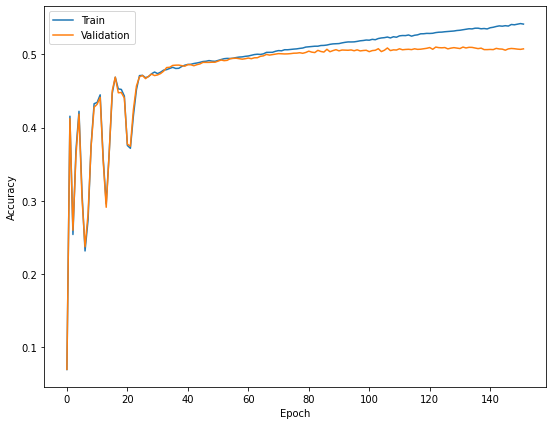

Flickr: test_accuracy=0.500±0.001


In [14]:
num_graff_layers = 2
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

Epoch 0:   train_loss=11.5898 | train_acc=0.0392 | val_acc=0.0392
Epoch 10:  train_loss=10.3457 | train_acc=0.4233 | val_acc=0.4164
Epoch 20:  train_loss=2.1237 | train_acc=0.3457 | val_acc=0.3491
Epoch 30:  train_loss=1.5514 | train_acc=0.4605 | val_acc=0.4618
Epoch 40:  train_loss=1.4999 | train_acc=0.4842 | val_acc=0.4829
Epoch 50:  train_loss=1.4703 | train_acc=0.4904 | val_acc=0.4886
Epoch 60:  train_loss=1.4460 | train_acc=0.4968 | val_acc=0.4934
Epoch 70:  train_loss=1.4388 | train_acc=0.4975 | val_acc=0.4961
Epoch 80:  train_loss=1.4247 | train_acc=0.5012 | val_acc=0.5029
Epoch 90:  train_loss=1.4146 | train_acc=0.5000 | val_acc=0.5020
Epoch 100: train_loss=1.4040 | train_acc=0.5073 | val_acc=0.5043
Epoch 110: train_loss=1.4578 | train_acc=0.4877 | val_acc=0.4804
Epoch 120: train_loss=1.4056 | train_acc=0.5074 | val_acc=0.5076
Early stopping after 122 epochs
Test accuracy: 0.5109


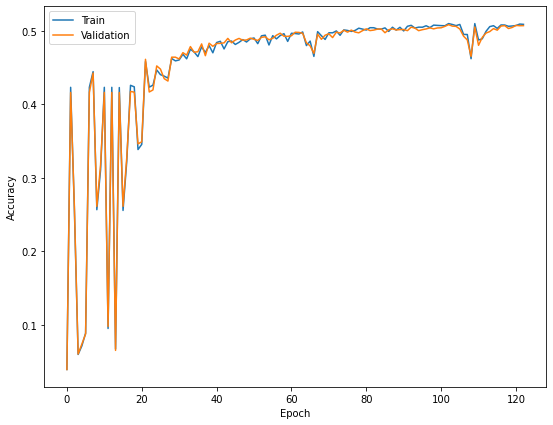

Epoch 0:   train_loss=16.0526 | train_acc=0.0945 | val_acc=0.0969
Epoch 10:  train_loss=4.8300 | train_acc=0.4701 | val_acc=0.4744
Epoch 20:  train_loss=1.8885 | train_acc=0.4241 | val_acc=0.4173
Epoch 30:  train_loss=1.5820 | train_acc=0.4829 | val_acc=0.4854
Epoch 40:  train_loss=1.5024 | train_acc=0.4902 | val_acc=0.4920
Epoch 50:  train_loss=1.4883 | train_acc=0.4770 | val_acc=0.4841
Epoch 60:  train_loss=1.4729 | train_acc=0.4931 | val_acc=0.4922
Epoch 70:  train_loss=1.4476 | train_acc=0.5006 | val_acc=0.5011
Epoch 80:  train_loss=1.4585 | train_acc=0.4767 | val_acc=0.4808
Epoch 90:  train_loss=1.4317 | train_acc=0.5069 | val_acc=0.5069
Epoch 100: train_loss=1.4170 | train_acc=0.5061 | val_acc=0.5083
Epoch 110: train_loss=1.4360 | train_acc=0.4873 | val_acc=0.4894
Epoch 120: train_loss=1.4066 | train_acc=0.5086 | val_acc=0.5123
Epoch 130: train_loss=1.3983 | train_acc=0.5104 | val_acc=0.5116
Epoch 140: train_loss=1.3935 | train_acc=0.5146 | val_acc=0.5116
Epoch 150: train_loss=1.

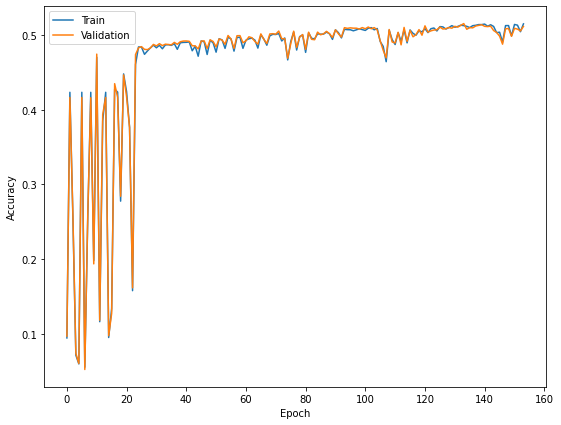

Epoch 0:   train_loss=18.7081 | train_acc=0.2532 | val_acc=0.2582
Epoch 10:  train_loss=6.1911 | train_acc=0.0714 | val_acc=0.0688
Epoch 20:  train_loss=2.4199 | train_acc=0.2698 | val_acc=0.2735
Epoch 30:  train_loss=1.5845 | train_acc=0.4798 | val_acc=0.4806
Epoch 40:  train_loss=1.5223 | train_acc=0.4823 | val_acc=0.4783
Epoch 50:  train_loss=1.4932 | train_acc=0.4856 | val_acc=0.4891
Epoch 60:  train_loss=1.4705 | train_acc=0.4894 | val_acc=0.4924
Epoch 70:  train_loss=1.4576 | train_acc=0.4884 | val_acc=0.4895
Epoch 80:  train_loss=1.4355 | train_acc=0.5003 | val_acc=0.4956
Epoch 90:  train_loss=1.4236 | train_acc=0.5038 | val_acc=0.4956
Epoch 100: train_loss=1.4196 | train_acc=0.5041 | val_acc=0.4957
Epoch 110: train_loss=1.4074 | train_acc=0.5053 | val_acc=0.4959
Epoch 120: train_loss=1.3976 | train_acc=0.5066 | val_acc=0.5070
Epoch 130: train_loss=1.3951 | train_acc=0.5088 | val_acc=0.5077
Epoch 140: train_loss=1.3895 | train_acc=0.5115 | val_acc=0.5066
Epoch 150: train_loss=1.

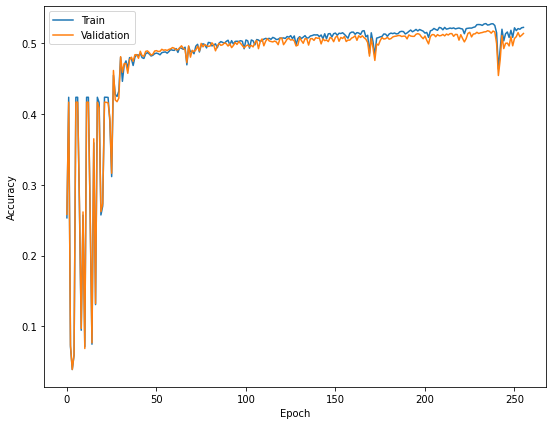

Epoch 0:   train_loss=24.3813 | train_acc=0.0597 | val_acc=0.0602
Epoch 10:  train_loss=3.8516 | train_acc=0.2454 | val_acc=0.2469
Epoch 20:  train_loss=2.0819 | train_acc=0.3823 | val_acc=0.3903
Epoch 30:  train_loss=1.6120 | train_acc=0.4714 | val_acc=0.4659
Epoch 40:  train_loss=1.5208 | train_acc=0.4804 | val_acc=0.4856
Epoch 50:  train_loss=1.4888 | train_acc=0.4907 | val_acc=0.4938
Epoch 60:  train_loss=1.4631 | train_acc=0.4966 | val_acc=0.4986
Epoch 70:  train_loss=1.4519 | train_acc=0.4990 | val_acc=0.4961
Epoch 80:  train_loss=1.4579 | train_acc=0.4926 | val_acc=0.4878
Epoch 90:  train_loss=1.4463 | train_acc=0.4987 | val_acc=0.4970
Early stopping after 92 epochs
Test accuracy: 0.5018


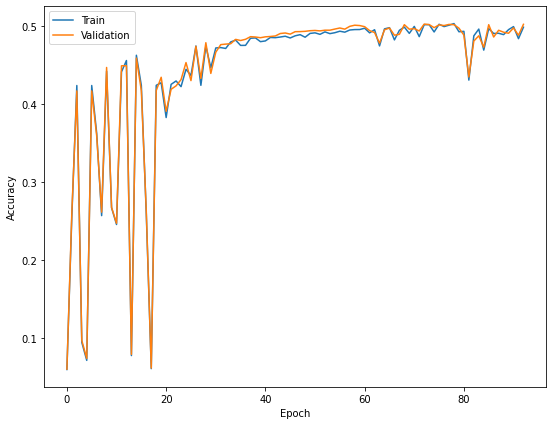

Epoch 0:   train_loss=26.3268 | train_acc=0.0394 | val_acc=0.0397
Epoch 10:  train_loss=10.8165 | train_acc=0.4233 | val_acc=0.4164
Epoch 20:  train_loss=2.6143 | train_acc=0.4220 | val_acc=0.4152
Epoch 30:  train_loss=1.8006 | train_acc=0.4312 | val_acc=0.4227
Epoch 40:  train_loss=1.5609 | train_acc=0.4717 | val_acc=0.4733
Epoch 50:  train_loss=1.5098 | train_acc=0.4787 | val_acc=0.4848
Epoch 60:  train_loss=1.4813 | train_acc=0.4854 | val_acc=0.4927
Epoch 70:  train_loss=1.4635 | train_acc=0.4937 | val_acc=0.4939
Epoch 80:  train_loss=1.4481 | train_acc=0.4910 | val_acc=0.4928
Epoch 90:  train_loss=1.4560 | train_acc=0.4932 | val_acc=0.4877
Epoch 100: train_loss=1.4316 | train_acc=0.4978 | val_acc=0.5008
Epoch 110: train_loss=1.4437 | train_acc=0.4892 | val_acc=0.4929
Epoch 120: train_loss=1.4213 | train_acc=0.5016 | val_acc=0.5034
Early stopping after 125 epochs
Test accuracy: 0.5103


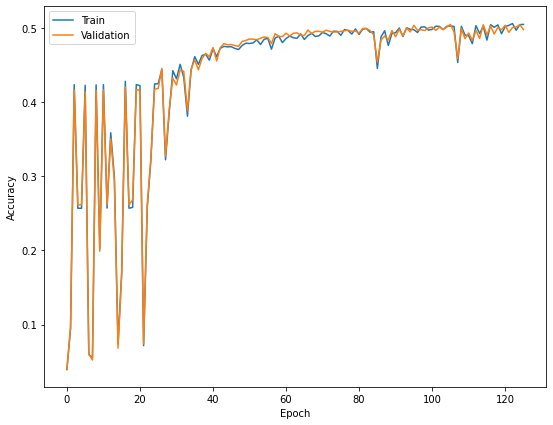

Epoch 0:   train_loss=16.3514 | train_acc=0.0915 | val_acc=0.0946
Epoch 10:  train_loss=3.8981 | train_acc=0.2568 | val_acc=0.2614
Epoch 20:  train_loss=1.8592 | train_acc=0.1757 | val_acc=0.1743
Epoch 30:  train_loss=1.5375 | train_acc=0.4808 | val_acc=0.4822
Epoch 40:  train_loss=1.5030 | train_acc=0.4833 | val_acc=0.4883
Epoch 50:  train_loss=1.4747 | train_acc=0.4919 | val_acc=0.4903
Epoch 60:  train_loss=1.4556 | train_acc=0.4960 | val_acc=0.4950
Epoch 70:  train_loss=1.4412 | train_acc=0.4989 | val_acc=0.4993
Epoch 80:  train_loss=1.4321 | train_acc=0.5019 | val_acc=0.4984
Epoch 90:  train_loss=1.4219 | train_acc=0.5043 | val_acc=0.5025
Epoch 100: train_loss=1.4222 | train_acc=0.4989 | val_acc=0.5012
Epoch 110: train_loss=1.4093 | train_acc=0.5063 | val_acc=0.5059
Epoch 120: train_loss=1.4097 | train_acc=0.5064 | val_acc=0.5020
Epoch 130: train_loss=1.3942 | train_acc=0.5120 | val_acc=0.5076
Epoch 140: train_loss=1.4419 | train_acc=0.4995 | val_acc=0.4949
Early stopping after 149

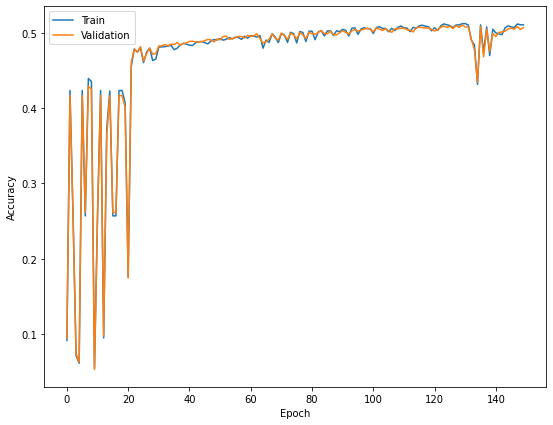

Epoch 0:   train_loss=16.7666 | train_acc=0.0641 | val_acc=0.0646
Epoch 10:  train_loss=4.3434 | train_acc=0.1046 | val_acc=0.1063
Epoch 20:  train_loss=2.4775 | train_acc=0.4281 | val_acc=0.4205
Epoch 30:  train_loss=1.6063 | train_acc=0.4688 | val_acc=0.4622
Epoch 40:  train_loss=1.5138 | train_acc=0.4752 | val_acc=0.4766
Epoch 50:  train_loss=1.4861 | train_acc=0.4919 | val_acc=0.4904
Epoch 60:  train_loss=1.4657 | train_acc=0.4967 | val_acc=0.4973
Epoch 70:  train_loss=1.4530 | train_acc=0.4995 | val_acc=0.4950
Epoch 80:  train_loss=1.4453 | train_acc=0.4986 | val_acc=0.4924
Epoch 90:  train_loss=1.4307 | train_acc=0.5033 | val_acc=0.5043
Epoch 100: train_loss=1.4280 | train_acc=0.5051 | val_acc=0.5031
Epoch 110: train_loss=1.4252 | train_acc=0.4964 | val_acc=0.5001
Epoch 120: train_loss=1.4150 | train_acc=0.5072 | val_acc=0.5020
Epoch 130: train_loss=1.4184 | train_acc=0.5115 | val_acc=0.5092
Epoch 140: train_loss=1.4326 | train_acc=0.5006 | val_acc=0.4940
Early stopping after 149

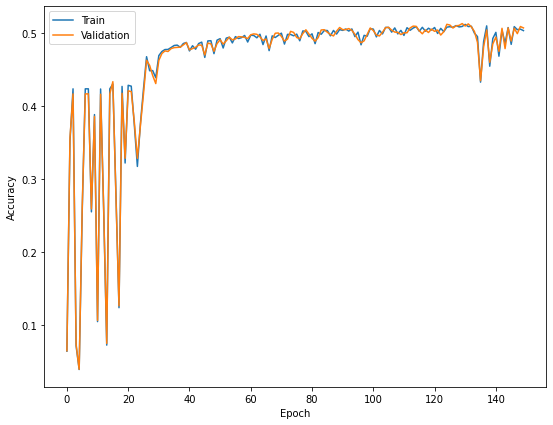

Epoch 0:   train_loss=7.9669 | train_acc=0.2566 | val_acc=0.2608
Epoch 10:  train_loss=7.9523 | train_acc=0.4233 | val_acc=0.4164
Epoch 20:  train_loss=2.0354 | train_acc=0.3232 | val_acc=0.3271
Epoch 30:  train_loss=1.5786 | train_acc=0.4749 | val_acc=0.4658
Epoch 40:  train_loss=1.5041 | train_acc=0.4858 | val_acc=0.4883
Epoch 50:  train_loss=1.4882 | train_acc=0.4863 | val_acc=0.4905
Epoch 60:  train_loss=1.4627 | train_acc=0.4992 | val_acc=0.5032
Epoch 70:  train_loss=1.4687 | train_acc=0.4798 | val_acc=0.4872
Epoch 80:  train_loss=1.4452 | train_acc=0.4952 | val_acc=0.4979
Epoch 90:  train_loss=1.4307 | train_acc=0.5075 | val_acc=0.5045
Epoch 100: train_loss=1.4285 | train_acc=0.5038 | val_acc=0.4997
Epoch 110: train_loss=1.4178 | train_acc=0.5050 | val_acc=0.5066
Epoch 120: train_loss=1.4057 | train_acc=0.5135 | val_acc=0.5098
Epoch 130: train_loss=1.4340 | train_acc=0.4839 | val_acc=0.4863
Epoch 140: train_loss=1.4516 | train_acc=0.4881 | val_acc=0.4960
Early stopping after 146 

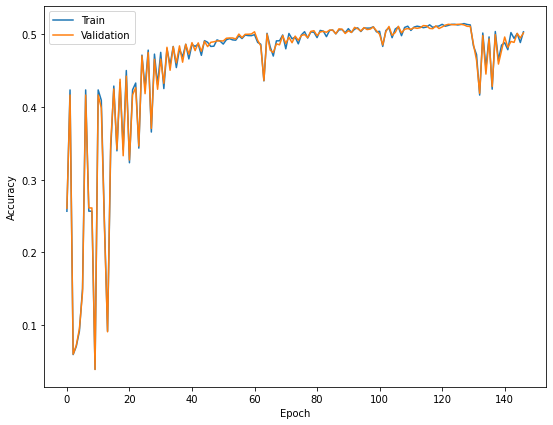

Epoch 0:   train_loss=10.9109 | train_acc=0.0597 | val_acc=0.0602
Epoch 10:  train_loss=6.4701 | train_acc=0.2568 | val_acc=0.2613
Epoch 20:  train_loss=1.6443 | train_acc=0.4284 | val_acc=0.4213
Epoch 30:  train_loss=1.5421 | train_acc=0.4638 | val_acc=0.4687
Epoch 40:  train_loss=1.4911 | train_acc=0.4880 | val_acc=0.4850
Epoch 50:  train_loss=1.4646 | train_acc=0.4949 | val_acc=0.4880
Epoch 60:  train_loss=1.4558 | train_acc=0.4964 | val_acc=0.4909
Epoch 70:  train_loss=1.4277 | train_acc=0.5047 | val_acc=0.4996
Epoch 80:  train_loss=1.4158 | train_acc=0.5074 | val_acc=0.5024
Epoch 90:  train_loss=1.4094 | train_acc=0.5100 | val_acc=0.5073
Epoch 100: train_loss=1.4063 | train_acc=0.5029 | val_acc=0.5025
Epoch 110: train_loss=1.3971 | train_acc=0.5102 | val_acc=0.5075
Epoch 120: train_loss=1.3819 | train_acc=0.5160 | val_acc=0.5134
Epoch 130: train_loss=1.3837 | train_acc=0.5167 | val_acc=0.5108
Epoch 140: train_loss=1.3768 | train_acc=0.5176 | val_acc=0.5083
Early stopping after 142

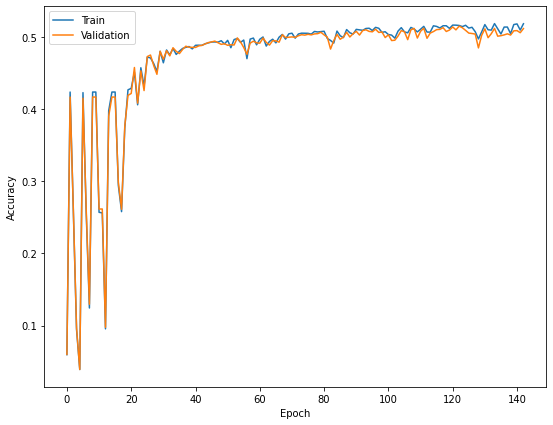

Epoch 0:   train_loss=5.3314 | train_acc=0.2637 | val_acc=0.2659
Epoch 10:  train_loss=8.4818 | train_acc=0.2567 | val_acc=0.2612
Epoch 20:  train_loss=2.0701 | train_acc=0.4544 | val_acc=0.4623
Epoch 30:  train_loss=1.5520 | train_acc=0.4740 | val_acc=0.4725
Epoch 40:  train_loss=1.5038 | train_acc=0.4776 | val_acc=0.4835
Epoch 50:  train_loss=1.4696 | train_acc=0.4840 | val_acc=0.4884
Epoch 60:  train_loss=1.4585 | train_acc=0.4811 | val_acc=0.4803
Epoch 70:  train_loss=1.4450 | train_acc=0.4886 | val_acc=0.4872
Epoch 80:  train_loss=1.4439 | train_acc=0.4954 | val_acc=0.4952
Epoch 90:  train_loss=1.4233 | train_acc=0.5004 | val_acc=0.4997
Epoch 100: train_loss=1.4403 | train_acc=0.4956 | val_acc=0.4853
Epoch 110: train_loss=1.4105 | train_acc=0.5060 | val_acc=0.4988
Epoch 120: train_loss=1.4091 | train_acc=0.5047 | val_acc=0.4996
Epoch 130: train_loss=1.4048 | train_acc=0.5040 | val_acc=0.5007
Epoch 140: train_loss=1.3924 | train_acc=0.5128 | val_acc=0.5048
Epoch 150: train_loss=1.3

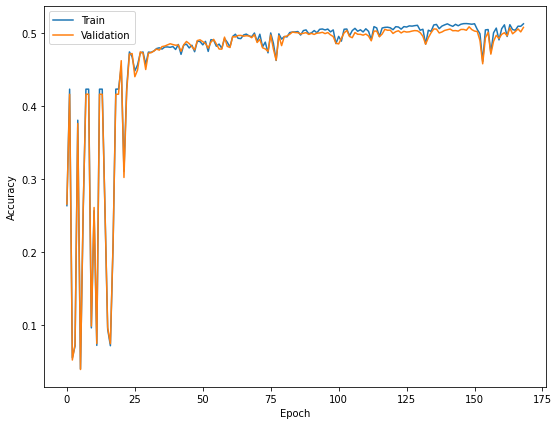

Flickr: test_accuracy=0.510±0.004


In [16]:
num_graff_layers = 4
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

---
## ogbn-arxiv
Define the hyperparameters for this section.

In [ ]:
hidden_dim = 128
learning_rate = 0.01
num_decoder_layers = 1

Download the ogbn-arxiv dataset and get the corresponding diffusion operators.

In [ ]:
dataset = PygNodePropPredDataset(
    root='/tmp',
    name='ogbn-arxiv',
    transform=ToUndirected()
)

print('Loading diffusion operators...')
diffusion_ops = get_diffusion_ops(dataset)
print('Done!')

num_features = dataset.num_features
num_classes = dataset.num_classes

Loading diffusion operators...
Done!


### Multi-layer Perceptron

Epoch 0:   train_loss=3.6832 | train_acc=0.0087 | val_acc=0.0098
Epoch 10:  train_loss=2.5195 | train_acc=0.3218 | val_acc=0.3340
Epoch 20:  train_loss=2.0713 | train_acc=0.4279 | val_acc=0.4540
Epoch 30:  train_loss=1.8605 | train_acc=0.4778 | val_acc=0.4932
Epoch 40:  train_loss=1.7474 | train_acc=0.5037 | val_acc=0.5138
Epoch 50:  train_loss=1.6863 | train_acc=0.5158 | val_acc=0.5263
Epoch 60:  train_loss=1.6438 | train_acc=0.5255 | val_acc=0.5330
Epoch 70:  train_loss=1.6111 | train_acc=0.5338 | val_acc=0.5339
Epoch 80:  train_loss=1.5855 | train_acc=0.5403 | val_acc=0.5394
Epoch 90:  train_loss=1.5792 | train_acc=0.5412 | val_acc=0.5406
Epoch 100: train_loss=1.5590 | train_acc=0.5445 | val_acc=0.5415
Epoch 110: train_loss=1.5352 | train_acc=0.5528 | val_acc=0.5485
Epoch 120: train_loss=1.5192 | train_acc=0.5564 | val_acc=0.5530
Epoch 130: train_loss=1.5053 | train_acc=0.5598 | val_acc=0.5535
Epoch 140: train_loss=1.5001 | train_acc=0.5599 | val_acc=0.5512
Epoch 150: train_loss=1.4

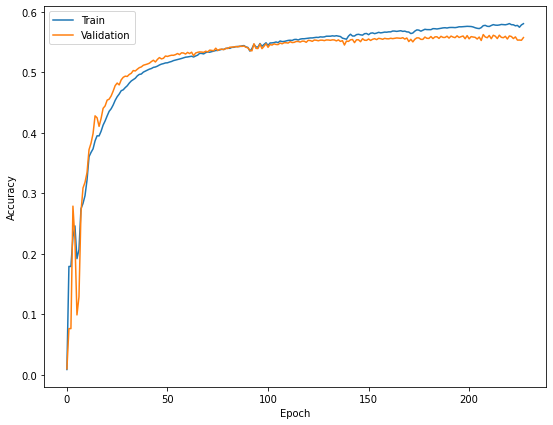

Epoch 0:   train_loss=3.7058 | train_acc=0.0184 | val_acc=0.0356
Epoch 10:  train_loss=2.4975 | train_acc=0.3150 | val_acc=0.3301
Epoch 20:  train_loss=2.0817 | train_acc=0.4212 | val_acc=0.4400
Epoch 30:  train_loss=1.8484 | train_acc=0.4815 | val_acc=0.4861
Epoch 40:  train_loss=1.7395 | train_acc=0.5057 | val_acc=0.5142
Epoch 50:  train_loss=1.6784 | train_acc=0.5178 | val_acc=0.5288
Epoch 60:  train_loss=1.6297 | train_acc=0.5301 | val_acc=0.5347
Epoch 70:  train_loss=1.5983 | train_acc=0.5375 | val_acc=0.5388
Epoch 80:  train_loss=1.5730 | train_acc=0.5437 | val_acc=0.5436
Epoch 90:  train_loss=1.5563 | train_acc=0.5468 | val_acc=0.5438
Epoch 100: train_loss=1.5389 | train_acc=0.5512 | val_acc=0.5515
Epoch 110: train_loss=1.5213 | train_acc=0.5559 | val_acc=0.5517
Epoch 120: train_loss=1.5142 | train_acc=0.5565 | val_acc=0.5504
Epoch 130: train_loss=1.5009 | train_acc=0.5597 | val_acc=0.5530
Epoch 140: train_loss=1.4834 | train_acc=0.5644 | val_acc=0.5556
Epoch 150: train_loss=1.4

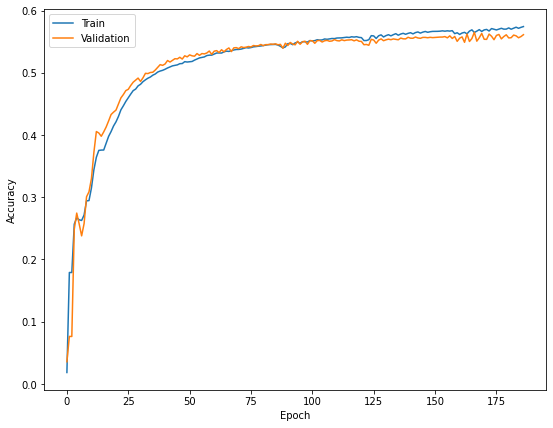

Epoch 0:   train_loss=3.7135 | train_acc=0.0234 | val_acc=0.0111
Epoch 10:  train_loss=2.5722 | train_acc=0.3000 | val_acc=0.3208
Epoch 20:  train_loss=2.1137 | train_acc=0.4133 | val_acc=0.4369
Epoch 30:  train_loss=1.8851 | train_acc=0.4708 | val_acc=0.4863
Epoch 40:  train_loss=1.7820 | train_acc=0.4956 | val_acc=0.5060
Epoch 50:  train_loss=1.7118 | train_acc=0.5111 | val_acc=0.5228
Epoch 60:  train_loss=1.6769 | train_acc=0.5183 | val_acc=0.5182
Epoch 70:  train_loss=1.6323 | train_acc=0.5295 | val_acc=0.5385
Epoch 80:  train_loss=1.5988 | train_acc=0.5377 | val_acc=0.5410
Epoch 90:  train_loss=1.5771 | train_acc=0.5427 | val_acc=0.5451
Epoch 100: train_loss=1.5590 | train_acc=0.5470 | val_acc=0.5464
Epoch 110: train_loss=1.5403 | train_acc=0.5506 | val_acc=0.5501
Epoch 120: train_loss=1.5246 | train_acc=0.5541 | val_acc=0.5501
Epoch 130: train_loss=1.5185 | train_acc=0.5553 | val_acc=0.5452
Epoch 140: train_loss=1.5000 | train_acc=0.5601 | val_acc=0.5512
Epoch 150: train_loss=1.4

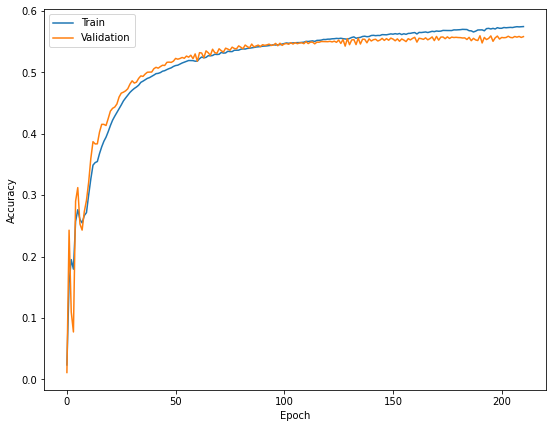

Epoch 0:   train_loss=3.6897 | train_acc=0.0207 | val_acc=0.0161
Epoch 10:  train_loss=2.5471 | train_acc=0.3276 | val_acc=0.3792
Epoch 20:  train_loss=2.0759 | train_acc=0.4225 | val_acc=0.4531
Epoch 30:  train_loss=1.8583 | train_acc=0.4789 | val_acc=0.4936
Epoch 40:  train_loss=1.7535 | train_acc=0.5017 | val_acc=0.5158
Epoch 50:  train_loss=1.6887 | train_acc=0.5170 | val_acc=0.5256
Epoch 60:  train_loss=1.6468 | train_acc=0.5267 | val_acc=0.5305
Epoch 70:  train_loss=1.6201 | train_acc=0.5323 | val_acc=0.5389
Epoch 80:  train_loss=1.5948 | train_acc=0.5387 | val_acc=0.5390
Epoch 90:  train_loss=1.5752 | train_acc=0.5428 | val_acc=0.5464
Epoch 100: train_loss=1.5629 | train_acc=0.5461 | val_acc=0.5449
Epoch 110: train_loss=1.5446 | train_acc=0.5505 | val_acc=0.5486
Epoch 120: train_loss=1.5316 | train_acc=0.5528 | val_acc=0.5520
Epoch 130: train_loss=1.5211 | train_acc=0.5537 | val_acc=0.5511
Epoch 140: train_loss=1.5097 | train_acc=0.5583 | val_acc=0.5557
Epoch 150: train_loss=1.5

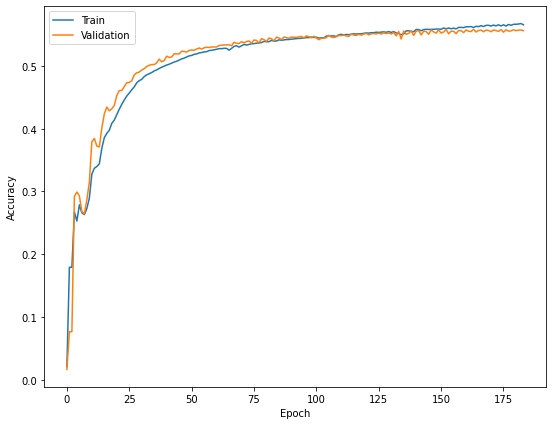

Epoch 0:   train_loss=3.7615 | train_acc=0.0169 | val_acc=0.0159
Epoch 10:  train_loss=2.5975 | train_acc=0.2916 | val_acc=0.3114
Epoch 20:  train_loss=2.1646 | train_acc=0.4058 | val_acc=0.4333
Epoch 30:  train_loss=1.9192 | train_acc=0.4629 | val_acc=0.4795
Epoch 40:  train_loss=1.7831 | train_acc=0.4933 | val_acc=0.5047
Epoch 50:  train_loss=1.7156 | train_acc=0.5091 | val_acc=0.5179
Epoch 60:  train_loss=1.6663 | train_acc=0.5210 | val_acc=0.5300
Epoch 70:  train_loss=1.6330 | train_acc=0.5289 | val_acc=0.5362
Epoch 80:  train_loss=1.6043 | train_acc=0.5356 | val_acc=0.5409
Epoch 90:  train_loss=1.6004 | train_acc=0.5339 | val_acc=0.5339
Epoch 100: train_loss=1.5697 | train_acc=0.5436 | val_acc=0.5466
Epoch 110: train_loss=1.5519 | train_acc=0.5485 | val_acc=0.5488
Epoch 120: train_loss=1.5370 | train_acc=0.5518 | val_acc=0.5491
Epoch 130: train_loss=1.5248 | train_acc=0.5540 | val_acc=0.5522
Epoch 140: train_loss=1.5191 | train_acc=0.5542 | val_acc=0.5500
Epoch 150: train_loss=1.5

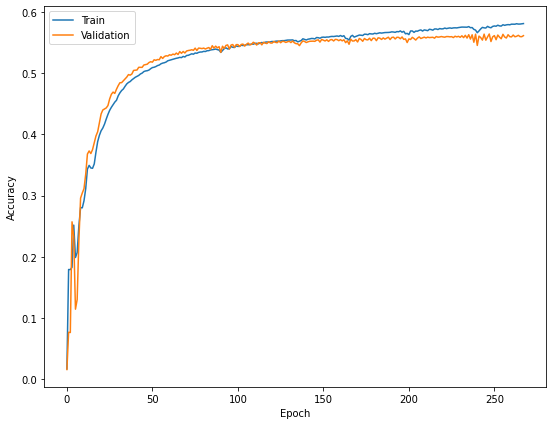

Epoch 0:   train_loss=3.6842 | train_acc=0.0015 | val_acc=0.0024
Epoch 10:  train_loss=2.4248 | train_acc=0.3582 | val_acc=0.3821
Epoch 20:  train_loss=2.0298 | train_acc=0.4361 | val_acc=0.4433
Epoch 30:  train_loss=1.8379 | train_acc=0.4829 | val_acc=0.4930
Epoch 40:  train_loss=1.7372 | train_acc=0.5028 | val_acc=0.5145
Epoch 50:  train_loss=1.6771 | train_acc=0.5193 | val_acc=0.5302
Epoch 60:  train_loss=1.6350 | train_acc=0.5289 | val_acc=0.5365
Epoch 70:  train_loss=1.6039 | train_acc=0.5362 | val_acc=0.5445
Epoch 80:  train_loss=1.5951 | train_acc=0.5352 | val_acc=0.5354
Epoch 90:  train_loss=1.5659 | train_acc=0.5443 | val_acc=0.5468
Epoch 100: train_loss=1.5511 | train_acc=0.5473 | val_acc=0.5476
Epoch 110: train_loss=1.5349 | train_acc=0.5524 | val_acc=0.5486
Epoch 120: train_loss=1.5215 | train_acc=0.5542 | val_acc=0.5515
Epoch 130: train_loss=1.5098 | train_acc=0.5577 | val_acc=0.5509
Epoch 140: train_loss=1.4973 | train_acc=0.5603 | val_acc=0.5527
Epoch 150: train_loss=1.4

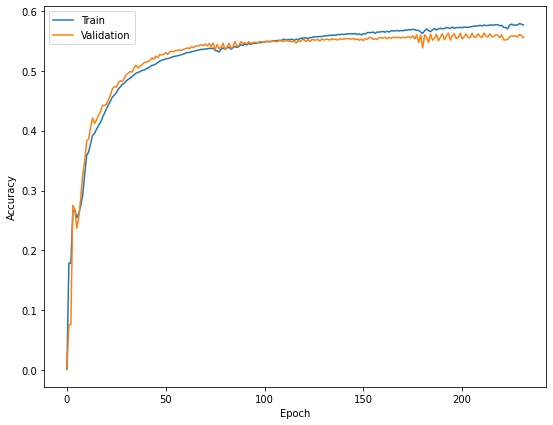

Epoch 0:   train_loss=3.7333 | train_acc=0.0157 | val_acc=0.0087
Epoch 10:  train_loss=2.5590 | train_acc=0.3184 | val_acc=0.3423
Epoch 20:  train_loss=2.1286 | train_acc=0.4133 | val_acc=0.4377
Epoch 30:  train_loss=1.9122 | train_acc=0.4660 | val_acc=0.4818
Epoch 40:  train_loss=1.8107 | train_acc=0.4872 | val_acc=0.4933
Epoch 50:  train_loss=1.7197 | train_acc=0.5090 | val_acc=0.5195
Epoch 60:  train_loss=1.6756 | train_acc=0.5173 | val_acc=0.5265
Epoch 70:  train_loss=1.6362 | train_acc=0.5273 | val_acc=0.5338
Epoch 80:  train_loss=1.6058 | train_acc=0.5355 | val_acc=0.5394
Epoch 90:  train_loss=1.5827 | train_acc=0.5400 | val_acc=0.5408
Epoch 100: train_loss=1.5612 | train_acc=0.5460 | val_acc=0.5446
Epoch 110: train_loss=1.5445 | train_acc=0.5490 | val_acc=0.5458
Epoch 120: train_loss=1.5293 | train_acc=0.5521 | val_acc=0.5483
Epoch 130: train_loss=1.5143 | train_acc=0.5565 | val_acc=0.5503
Epoch 140: train_loss=1.5020 | train_acc=0.5598 | val_acc=0.5531
Epoch 150: train_loss=1.5

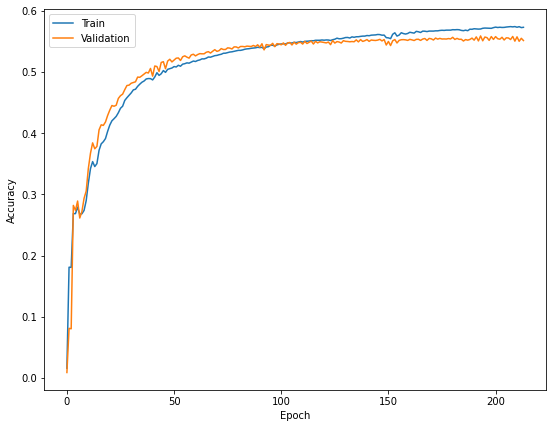

Epoch 0:   train_loss=3.6924 | train_acc=0.0528 | val_acc=0.0368
Epoch 10:  train_loss=2.5706 | train_acc=0.3290 | val_acc=0.3641
Epoch 20:  train_loss=2.1237 | train_acc=0.4158 | val_acc=0.4432
Epoch 30:  train_loss=1.8819 | train_acc=0.4764 | val_acc=0.4848
Epoch 40:  train_loss=1.7630 | train_acc=0.5021 | val_acc=0.5132
Epoch 50:  train_loss=1.6905 | train_acc=0.5178 | val_acc=0.5239
Epoch 60:  train_loss=1.6450 | train_acc=0.5277 | val_acc=0.5349
Epoch 70:  train_loss=1.6106 | train_acc=0.5350 | val_acc=0.5369
Epoch 80:  train_loss=1.5868 | train_acc=0.5400 | val_acc=0.5386
Epoch 90:  train_loss=1.5625 | train_acc=0.5447 | val_acc=0.5441
Epoch 100: train_loss=1.5453 | train_acc=0.5484 | val_acc=0.5471
Epoch 110: train_loss=1.5290 | train_acc=0.5522 | val_acc=0.5480
Epoch 120: train_loss=1.5157 | train_acc=0.5556 | val_acc=0.5513
Epoch 130: train_loss=1.5069 | train_acc=0.5573 | val_acc=0.5496
Epoch 140: train_loss=1.4919 | train_acc=0.5610 | val_acc=0.5541
Epoch 150: train_loss=1.4

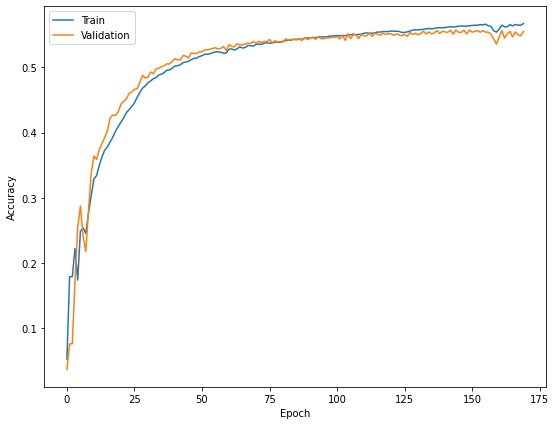

Epoch 0:   train_loss=3.6690 | train_acc=0.0082 | val_acc=0.0070
Epoch 10:  train_loss=2.5988 | train_acc=0.3112 | val_acc=0.3180
Epoch 20:  train_loss=2.1307 | train_acc=0.4091 | val_acc=0.4289
Epoch 30:  train_loss=1.8973 | train_acc=0.4682 | val_acc=0.4838
Epoch 40:  train_loss=1.7813 | train_acc=0.4950 | val_acc=0.5095
Epoch 50:  train_loss=1.7106 | train_acc=0.5100 | val_acc=0.5231
Epoch 60:  train_loss=1.6589 | train_acc=0.5225 | val_acc=0.5311
Epoch 70:  train_loss=1.6230 | train_acc=0.5321 | val_acc=0.5359
Epoch 80:  train_loss=1.5976 | train_acc=0.5365 | val_acc=0.5434
Epoch 90:  train_loss=1.5709 | train_acc=0.5423 | val_acc=0.5438
Epoch 100: train_loss=1.5539 | train_acc=0.5467 | val_acc=0.5449
Epoch 110: train_loss=1.5380 | train_acc=0.5501 | val_acc=0.5450
Epoch 120: train_loss=1.5224 | train_acc=0.5546 | val_acc=0.5500
Epoch 130: train_loss=1.5115 | train_acc=0.5564 | val_acc=0.5505
Epoch 140: train_loss=1.4990 | train_acc=0.5607 | val_acc=0.5518
Epoch 150: train_loss=1.4

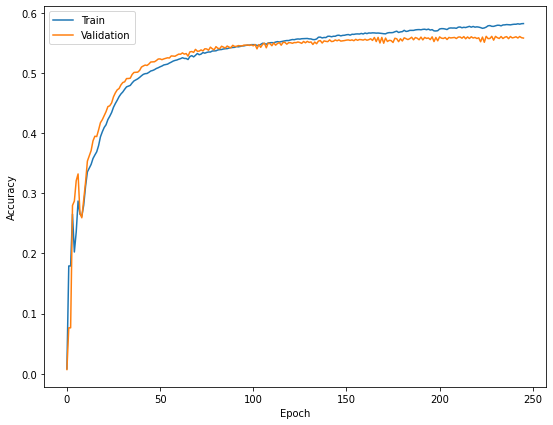

Epoch 0:   train_loss=3.7157 | train_acc=0.0305 | val_acc=0.0151
Epoch 10:  train_loss=2.5396 | train_acc=0.2998 | val_acc=0.3138
Epoch 20:  train_loss=2.0937 | train_acc=0.4197 | val_acc=0.4460
Epoch 30:  train_loss=1.8668 | train_acc=0.4752 | val_acc=0.4832
Epoch 40:  train_loss=1.7494 | train_acc=0.5014 | val_acc=0.5131
Epoch 50:  train_loss=1.6814 | train_acc=0.5179 | val_acc=0.5266
Epoch 60:  train_loss=1.6373 | train_acc=0.5280 | val_acc=0.5322
Epoch 70:  train_loss=1.6055 | train_acc=0.5354 | val_acc=0.5398
Epoch 80:  train_loss=1.5812 | train_acc=0.5405 | val_acc=0.5432
Epoch 90:  train_loss=1.5642 | train_acc=0.5442 | val_acc=0.5418
Epoch 100: train_loss=1.5449 | train_acc=0.5489 | val_acc=0.5463
Epoch 110: train_loss=1.5302 | train_acc=0.5520 | val_acc=0.5490
Epoch 120: train_loss=1.5148 | train_acc=0.5574 | val_acc=0.5520
Epoch 130: train_loss=1.5003 | train_acc=0.5600 | val_acc=0.5502
Epoch 140: train_loss=1.4974 | train_acc=0.5591 | val_acc=0.5528
Early stopping after 149 

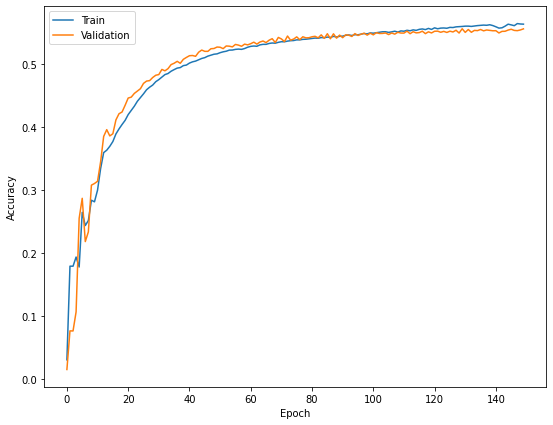

PygNodePropPredDataset-ogbn-arxiv: test_accuracy=0.533±0.005


In [ ]:
run_experiment(dataset, learning_rate, model_func_mlp, None)

### GRAFF

Epoch 0:   train_loss=3.8504 | train_acc=0.0169 | val_acc=0.0152
Epoch 10:  train_loss=2.8472 | train_acc=0.2208 | val_acc=0.2251
Epoch 20:  train_loss=2.5717 | train_acc=0.2953 | val_acc=0.2951
Epoch 30:  train_loss=2.3612 | train_acc=0.3770 | val_acc=0.3792
Epoch 40:  train_loss=2.1990 | train_acc=0.4068 | val_acc=0.4071
Epoch 50:  train_loss=2.0769 | train_acc=0.4473 | val_acc=0.4482
Epoch 60:  train_loss=1.9819 | train_acc=0.4651 | val_acc=0.4684
Epoch 70:  train_loss=1.9066 | train_acc=0.4823 | val_acc=0.4862
Epoch 80:  train_loss=1.8456 | train_acc=0.4959 | val_acc=0.4991
Epoch 90:  train_loss=1.7954 | train_acc=0.5062 | val_acc=0.5104
Epoch 100: train_loss=1.7534 | train_acc=0.5148 | val_acc=0.5191
Epoch 110: train_loss=1.7178 | train_acc=0.5225 | val_acc=0.5265
Epoch 120: train_loss=1.6873 | train_acc=0.5284 | val_acc=0.5308
Epoch 130: train_loss=1.6609 | train_acc=0.5342 | val_acc=0.5367
Epoch 140: train_loss=1.6379 | train_acc=0.5392 | val_acc=0.5400
Epoch 150: train_loss=1.6

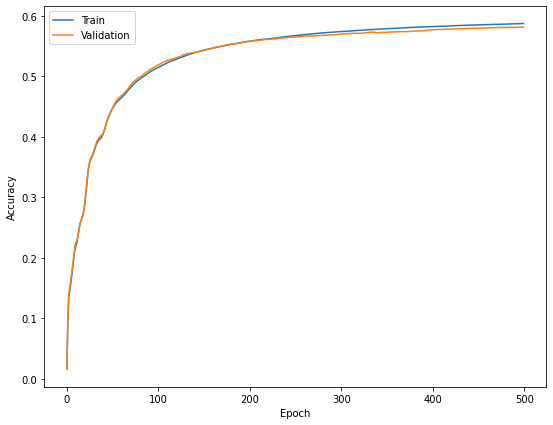

Epoch 0:   train_loss=3.8179 | train_acc=0.0138 | val_acc=0.0136
Epoch 10:  train_loss=2.8313 | train_acc=0.2015 | val_acc=0.2046
Epoch 20:  train_loss=2.5743 | train_acc=0.3235 | val_acc=0.3255
Epoch 30:  train_loss=2.3593 | train_acc=0.3819 | val_acc=0.3882
Epoch 40:  train_loss=2.1963 | train_acc=0.4236 | val_acc=0.4291
Epoch 50:  train_loss=2.0711 | train_acc=0.4536 | val_acc=0.4583
Epoch 60:  train_loss=1.9744 | train_acc=0.4750 | val_acc=0.4803
Epoch 70:  train_loss=1.8980 | train_acc=0.4896 | val_acc=0.4940
Epoch 80:  train_loss=1.8365 | train_acc=0.5030 | val_acc=0.5073
Epoch 90:  train_loss=1.7864 | train_acc=0.5114 | val_acc=0.5129
Epoch 100: train_loss=1.7447 | train_acc=0.5193 | val_acc=0.5201
Epoch 110: train_loss=1.7096 | train_acc=0.5253 | val_acc=0.5259
Epoch 120: train_loss=1.6797 | train_acc=0.5304 | val_acc=0.5308
Epoch 130: train_loss=1.6539 | train_acc=0.5351 | val_acc=0.5353
Epoch 140: train_loss=1.6314 | train_acc=0.5388 | val_acc=0.5398
Epoch 150: train_loss=1.6

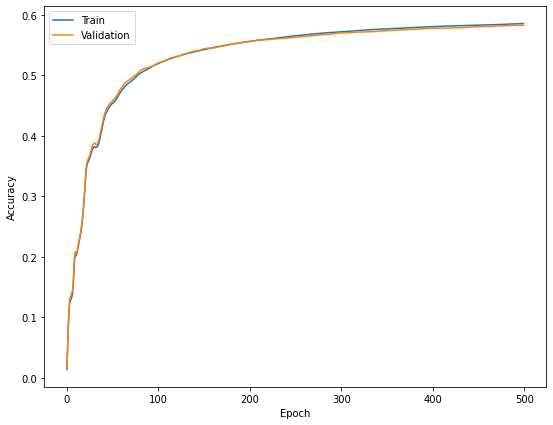

Epoch 0:   train_loss=3.7843 | train_acc=0.0182 | val_acc=0.0177
Epoch 10:  train_loss=2.8391 | train_acc=0.2135 | val_acc=0.2194
Epoch 20:  train_loss=2.5741 | train_acc=0.2951 | val_acc=0.2982
Epoch 30:  train_loss=2.3589 | train_acc=0.3767 | val_acc=0.3833
Epoch 40:  train_loss=2.1946 | train_acc=0.4081 | val_acc=0.4127
Epoch 50:  train_loss=2.0716 | train_acc=0.4477 | val_acc=0.4509
Epoch 60:  train_loss=1.9751 | train_acc=0.4676 | val_acc=0.4691
Epoch 70:  train_loss=1.8994 | train_acc=0.4869 | val_acc=0.4884
Epoch 80:  train_loss=1.8385 | train_acc=0.4998 | val_acc=0.4981
Epoch 90:  train_loss=1.7886 | train_acc=0.5102 | val_acc=0.5090
Epoch 100: train_loss=1.7472 | train_acc=0.5179 | val_acc=0.5160
Epoch 110: train_loss=1.7124 | train_acc=0.5248 | val_acc=0.5238
Epoch 120: train_loss=1.6827 | train_acc=0.5308 | val_acc=0.5304
Epoch 130: train_loss=1.6571 | train_acc=0.5359 | val_acc=0.5348
Epoch 140: train_loss=1.6349 | train_acc=0.5399 | val_acc=0.5388
Epoch 150: train_loss=1.6

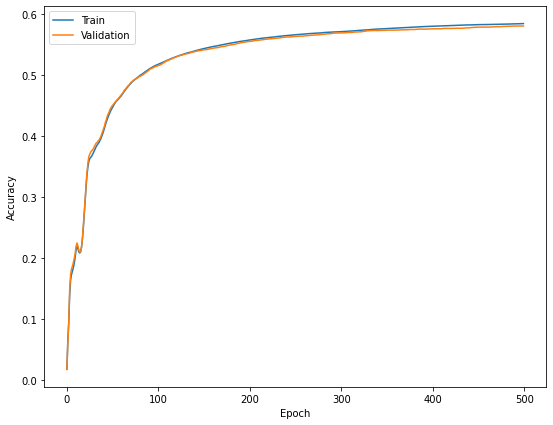

Epoch 0:   train_loss=3.7482 | train_acc=0.0530 | val_acc=0.0533
Epoch 10:  train_loss=2.8101 | train_acc=0.2549 | val_acc=0.2590
Epoch 20:  train_loss=2.5280 | train_acc=0.3365 | val_acc=0.3379
Epoch 30:  train_loss=2.3100 | train_acc=0.3926 | val_acc=0.3931
Epoch 40:  train_loss=2.1462 | train_acc=0.4368 | val_acc=0.4401
Epoch 50:  train_loss=2.0231 | train_acc=0.4677 | val_acc=0.4694
Epoch 60:  train_loss=1.9292 | train_acc=0.4869 | val_acc=0.4868
Epoch 70:  train_loss=1.8559 | train_acc=0.5027 | val_acc=0.5008
Epoch 80:  train_loss=1.7971 | train_acc=0.5134 | val_acc=0.5116
Epoch 90:  train_loss=1.7490 | train_acc=0.5216 | val_acc=0.5217
Epoch 100: train_loss=1.7089 | train_acc=0.5281 | val_acc=0.5282
Epoch 110: train_loss=1.6752 | train_acc=0.5338 | val_acc=0.5345
Epoch 120: train_loss=1.6463 | train_acc=0.5394 | val_acc=0.5386
Epoch 130: train_loss=1.6213 | train_acc=0.5440 | val_acc=0.5436
Epoch 140: train_loss=1.5996 | train_acc=0.5480 | val_acc=0.5484
Epoch 150: train_loss=1.5

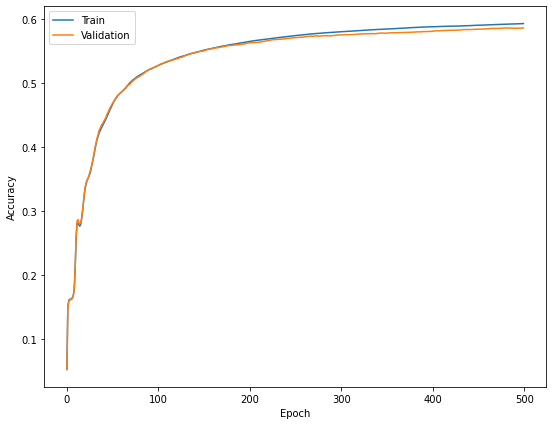

Epoch 0:   train_loss=3.8634 | train_acc=0.0142 | val_acc=0.0139
Epoch 10:  train_loss=2.8719 | train_acc=0.1992 | val_acc=0.2079
Epoch 20:  train_loss=2.6018 | train_acc=0.2463 | val_acc=0.2442
Epoch 30:  train_loss=2.3828 | train_acc=0.3817 | val_acc=0.3850
Epoch 40:  train_loss=2.2172 | train_acc=0.4154 | val_acc=0.4171
Epoch 50:  train_loss=2.0915 | train_acc=0.4484 | val_acc=0.4482
Epoch 60:  train_loss=1.9938 | train_acc=0.4725 | val_acc=0.4729
Epoch 70:  train_loss=1.9166 | train_acc=0.4874 | val_acc=0.4879
Epoch 80:  train_loss=1.8544 | train_acc=0.5001 | val_acc=0.4983
Epoch 90:  train_loss=1.8033 | train_acc=0.5096 | val_acc=0.5097
Epoch 100: train_loss=1.7607 | train_acc=0.5174 | val_acc=0.5159
Epoch 110: train_loss=1.7247 | train_acc=0.5244 | val_acc=0.5216
Epoch 120: train_loss=1.6938 | train_acc=0.5296 | val_acc=0.5268
Epoch 130: train_loss=1.6671 | train_acc=0.5349 | val_acc=0.5321
Epoch 140: train_loss=1.6437 | train_acc=0.5395 | val_acc=0.5364
Epoch 150: train_loss=1.6

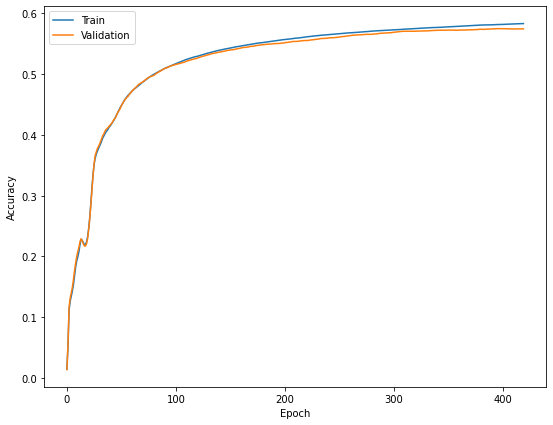

Epoch 0:   train_loss=3.6478 | train_acc=0.0578 | val_acc=0.0566
Epoch 10:  train_loss=2.7890 | train_acc=0.2516 | val_acc=0.2496
Epoch 20:  train_loss=2.5151 | train_acc=0.3647 | val_acc=0.3654
Epoch 30:  train_loss=2.2960 | train_acc=0.3918 | val_acc=0.3945
Epoch 40:  train_loss=2.1371 | train_acc=0.4475 | val_acc=0.4505
Epoch 50:  train_loss=2.0176 | train_acc=0.4694 | val_acc=0.4717
Epoch 60:  train_loss=1.9252 | train_acc=0.4899 | val_acc=0.4927
Epoch 70:  train_loss=1.8522 | train_acc=0.5048 | val_acc=0.5048
Epoch 80:  train_loss=1.7936 | train_acc=0.5159 | val_acc=0.5155
Epoch 90:  train_loss=1.7455 | train_acc=0.5246 | val_acc=0.5242
Epoch 100: train_loss=1.7055 | train_acc=0.5314 | val_acc=0.5304
Epoch 110: train_loss=1.6718 | train_acc=0.5369 | val_acc=0.5362
Epoch 120: train_loss=1.6429 | train_acc=0.5418 | val_acc=0.5412
Epoch 130: train_loss=1.6180 | train_acc=0.5456 | val_acc=0.5463
Epoch 140: train_loss=1.5964 | train_acc=0.5494 | val_acc=0.5492
Epoch 150: train_loss=1.5

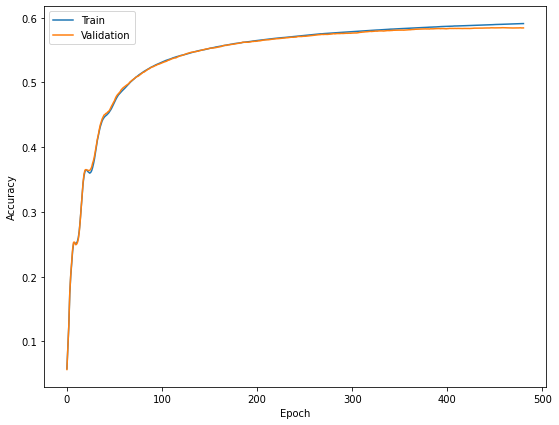

Epoch 0:   train_loss=3.7306 | train_acc=0.0324 | val_acc=0.0340
Epoch 10:  train_loss=2.8203 | train_acc=0.2493 | val_acc=0.2515
Epoch 20:  train_loss=2.5485 | train_acc=0.3217 | val_acc=0.3272
Epoch 30:  train_loss=2.3405 | train_acc=0.3801 | val_acc=0.3817
Epoch 40:  train_loss=2.1791 | train_acc=0.4277 | val_acc=0.4296
Epoch 50:  train_loss=2.0569 | train_acc=0.4590 | val_acc=0.4597
Epoch 60:  train_loss=1.9623 | train_acc=0.4793 | val_acc=0.4773
Epoch 70:  train_loss=1.8878 | train_acc=0.4949 | val_acc=0.4922
Epoch 80:  train_loss=1.8280 | train_acc=0.5059 | val_acc=0.5024
Epoch 90:  train_loss=1.7791 | train_acc=0.5151 | val_acc=0.5116
Epoch 100: train_loss=1.7384 | train_acc=0.5216 | val_acc=0.5169
Epoch 110: train_loss=1.7041 | train_acc=0.5271 | val_acc=0.5222
Epoch 120: train_loss=1.6748 | train_acc=0.5328 | val_acc=0.5273
Epoch 130: train_loss=1.6495 | train_acc=0.5379 | val_acc=0.5312
Epoch 140: train_loss=1.6274 | train_acc=0.5420 | val_acc=0.5360
Epoch 150: train_loss=1.6

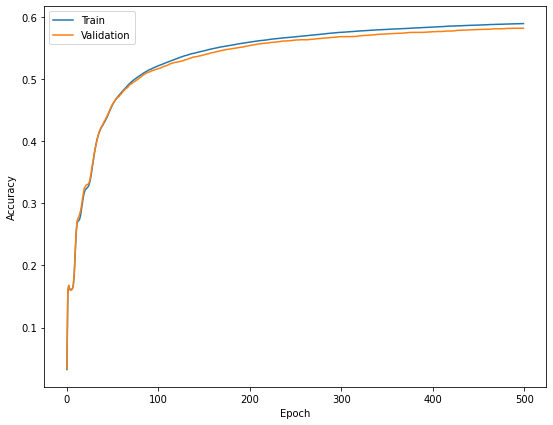

Epoch 0:   train_loss=3.7664 | train_acc=0.0805 | val_acc=0.0798
Epoch 10:  train_loss=2.7900 | train_acc=0.2539 | val_acc=0.2569
Epoch 20:  train_loss=2.5315 | train_acc=0.2908 | val_acc=0.2868
Epoch 30:  train_loss=2.3216 | train_acc=0.4011 | val_acc=0.4024
Epoch 40:  train_loss=2.1624 | train_acc=0.4243 | val_acc=0.4282
Epoch 50:  train_loss=2.0429 | train_acc=0.4569 | val_acc=0.4570
Epoch 60:  train_loss=1.9504 | train_acc=0.4770 | val_acc=0.4774
Epoch 70:  train_loss=1.8775 | train_acc=0.4921 | val_acc=0.4914
Epoch 80:  train_loss=1.8192 | train_acc=0.5047 | val_acc=0.5030
Epoch 90:  train_loss=1.7715 | train_acc=0.5139 | val_acc=0.5124
Epoch 100: train_loss=1.7320 | train_acc=0.5209 | val_acc=0.5205
Epoch 110: train_loss=1.6988 | train_acc=0.5273 | val_acc=0.5259
Epoch 120: train_loss=1.6704 | train_acc=0.5327 | val_acc=0.5314
Epoch 130: train_loss=1.6461 | train_acc=0.5371 | val_acc=0.5371
Epoch 140: train_loss=1.6249 | train_acc=0.5414 | val_acc=0.5415
Epoch 150: train_loss=1.6

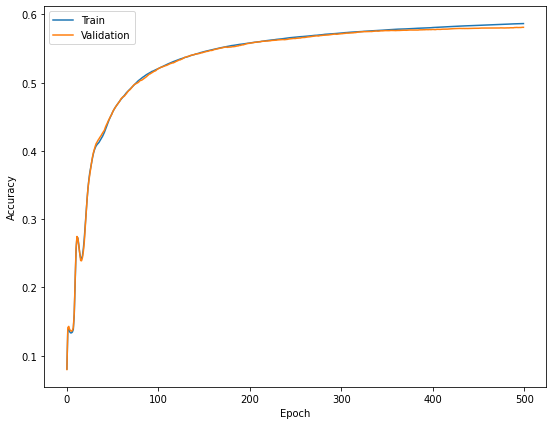

Epoch 0:   train_loss=3.7980 | train_acc=0.0136 | val_acc=0.0146
Epoch 10:  train_loss=2.8351 | train_acc=0.2432 | val_acc=0.2439
Epoch 20:  train_loss=2.5679 | train_acc=0.3251 | val_acc=0.3245
Epoch 30:  train_loss=2.3592 | train_acc=0.3780 | val_acc=0.3804
Epoch 40:  train_loss=2.1968 | train_acc=0.4279 | val_acc=0.4286
Epoch 50:  train_loss=2.0726 | train_acc=0.4565 | val_acc=0.4586
Epoch 60:  train_loss=1.9763 | train_acc=0.4770 | val_acc=0.4777
Epoch 70:  train_loss=1.8995 | train_acc=0.4933 | val_acc=0.4931
Epoch 80:  train_loss=1.8375 | train_acc=0.5057 | val_acc=0.5033
Epoch 90:  train_loss=1.7864 | train_acc=0.5156 | val_acc=0.5129
Epoch 100: train_loss=1.7437 | train_acc=0.5235 | val_acc=0.5206
Epoch 110: train_loss=1.7075 | train_acc=0.5301 | val_acc=0.5276
Epoch 120: train_loss=1.6765 | train_acc=0.5353 | val_acc=0.5322
Epoch 130: train_loss=1.6497 | train_acc=0.5401 | val_acc=0.5361
Epoch 140: train_loss=1.6263 | train_acc=0.5444 | val_acc=0.5401
Epoch 150: train_loss=1.6

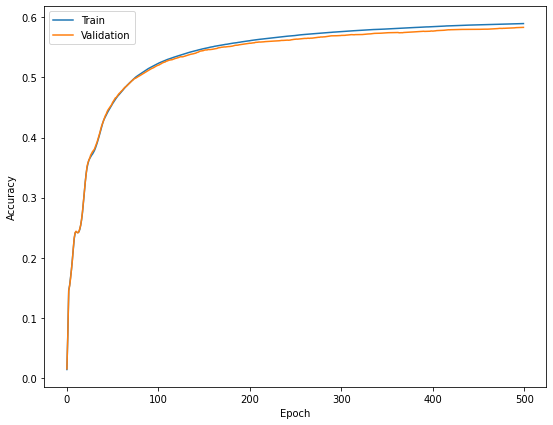

Epoch 0:   train_loss=3.7764 | train_acc=0.0065 | val_acc=0.0065
Epoch 10:  train_loss=2.8090 | train_acc=0.2490 | val_acc=0.2558
Epoch 20:  train_loss=2.5397 | train_acc=0.2988 | val_acc=0.2980
Epoch 30:  train_loss=2.3238 | train_acc=0.3857 | val_acc=0.3895
Epoch 40:  train_loss=2.1614 | train_acc=0.4179 | val_acc=0.4248
Epoch 50:  train_loss=2.0402 | train_acc=0.4578 | val_acc=0.4665
Epoch 60:  train_loss=1.9467 | train_acc=0.4759 | val_acc=0.4846
Epoch 70:  train_loss=1.8733 | train_acc=0.4941 | val_acc=0.4992
Epoch 80:  train_loss=1.8144 | train_acc=0.5060 | val_acc=0.5079
Epoch 90:  train_loss=1.7663 | train_acc=0.5150 | val_acc=0.5175
Epoch 100: train_loss=1.7263 | train_acc=0.5222 | val_acc=0.5232
Epoch 110: train_loss=1.6925 | train_acc=0.5280 | val_acc=0.5291
Epoch 120: train_loss=1.6637 | train_acc=0.5332 | val_acc=0.5344
Epoch 130: train_loss=1.6388 | train_acc=0.5378 | val_acc=0.5389
Epoch 140: train_loss=1.6170 | train_acc=0.5416 | val_acc=0.5423
Epoch 150: train_loss=1.5

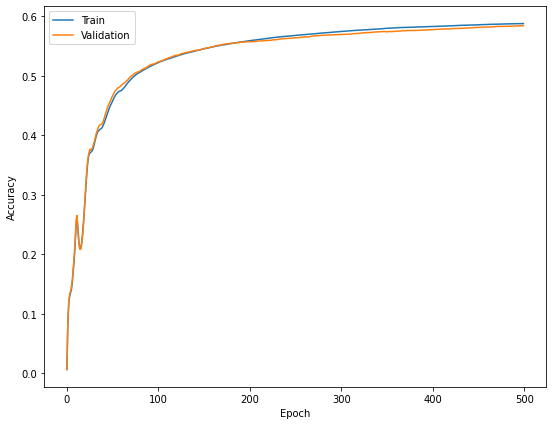

PygNodePropPredDataset-ogbn-arxiv: test_accuracy=0.581±0.004


In [ ]:
num_graff_layers = 1
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

Epoch 0:   train_loss=3.6509 | train_acc=0.1634 | val_acc=0.1647
Epoch 10:  train_loss=2.4728 | train_acc=0.3142 | val_acc=0.3204
Epoch 20:  train_loss=1.9795 | train_acc=0.5049 | val_acc=0.5014
Epoch 30:  train_loss=1.7241 | train_acc=0.5597 | val_acc=0.5568
Epoch 40:  train_loss=1.5695 | train_acc=0.5771 | val_acc=0.5761
Epoch 50:  train_loss=1.4736 | train_acc=0.5923 | val_acc=0.5899
Epoch 60:  train_loss=1.4083 | train_acc=0.6038 | val_acc=0.6020
Epoch 70:  train_loss=1.3611 | train_acc=0.6136 | val_acc=0.6097
Epoch 80:  train_loss=1.3252 | train_acc=0.6209 | val_acc=0.6173
Epoch 90:  train_loss=1.2970 | train_acc=0.6263 | val_acc=0.6231
Epoch 100: train_loss=1.2742 | train_acc=0.6315 | val_acc=0.6271
Epoch 110: train_loss=1.2553 | train_acc=0.6351 | val_acc=0.6315
Epoch 120: train_loss=1.2394 | train_acc=0.6384 | val_acc=0.6352
Epoch 130: train_loss=1.2258 | train_acc=0.6412 | val_acc=0.6384
Epoch 140: train_loss=1.2140 | train_acc=0.6437 | val_acc=0.6406
Epoch 150: train_loss=1.2

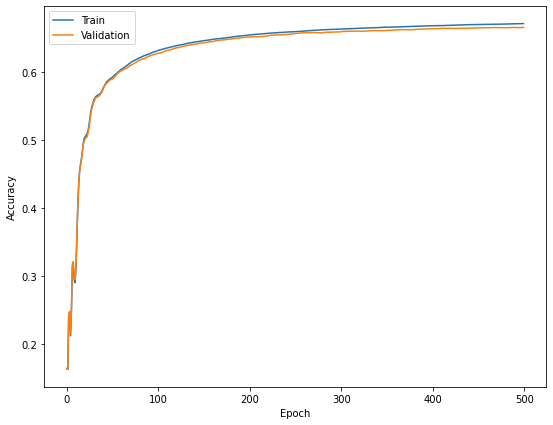

Epoch 0:   train_loss=4.4963 | train_acc=0.0164 | val_acc=0.0180
Epoch 10:  train_loss=2.6185 | train_acc=0.2998 | val_acc=0.2975
Epoch 20:  train_loss=2.1515 | train_acc=0.4424 | val_acc=0.4474
Epoch 30:  train_loss=1.8346 | train_acc=0.5172 | val_acc=0.5200
Epoch 40:  train_loss=1.6538 | train_acc=0.5669 | val_acc=0.5660
Epoch 50:  train_loss=1.5457 | train_acc=0.5820 | val_acc=0.5809
Epoch 60:  train_loss=1.4717 | train_acc=0.5936 | val_acc=0.5942
Epoch 70:  train_loss=1.4173 | train_acc=0.6052 | val_acc=0.6047
Epoch 80:  train_loss=1.3762 | train_acc=0.6124 | val_acc=0.6113
Epoch 90:  train_loss=1.3436 | train_acc=0.6181 | val_acc=0.6178
Epoch 100: train_loss=1.3171 | train_acc=0.6225 | val_acc=0.6227
Epoch 110: train_loss=1.2950 | train_acc=0.6264 | val_acc=0.6270
Epoch 120: train_loss=1.2764 | train_acc=0.6300 | val_acc=0.6305
Epoch 130: train_loss=1.2603 | train_acc=0.6333 | val_acc=0.6337
Epoch 140: train_loss=1.2463 | train_acc=0.6360 | val_acc=0.6372
Epoch 150: train_loss=1.2

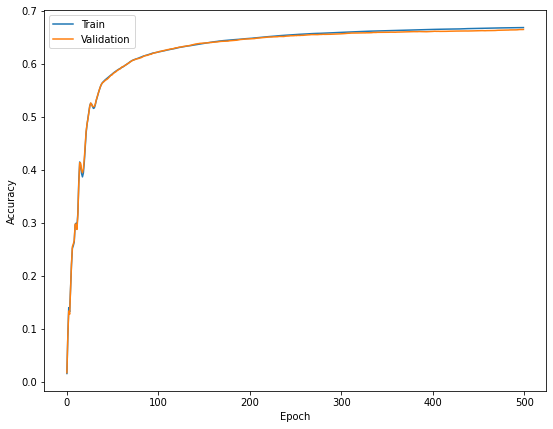

Epoch 0:   train_loss=4.1402 | train_acc=0.0651 | val_acc=0.0696
Epoch 10:  train_loss=2.6023 | train_acc=0.2979 | val_acc=0.3012
Epoch 20:  train_loss=2.1482 | train_acc=0.4149 | val_acc=0.4083
Epoch 30:  train_loss=1.8693 | train_acc=0.5060 | val_acc=0.5042
Epoch 40:  train_loss=1.6998 | train_acc=0.5299 | val_acc=0.5322
Epoch 50:  train_loss=1.5835 | train_acc=0.5635 | val_acc=0.5661
Epoch 60:  train_loss=1.5021 | train_acc=0.5830 | val_acc=0.5820
Epoch 70:  train_loss=1.4429 | train_acc=0.5968 | val_acc=0.5941
Epoch 80:  train_loss=1.3974 | train_acc=0.6059 | val_acc=0.6023
Epoch 90:  train_loss=1.3615 | train_acc=0.6134 | val_acc=0.6085
Epoch 100: train_loss=1.3325 | train_acc=0.6194 | val_acc=0.6140
Epoch 110: train_loss=1.3084 | train_acc=0.6241 | val_acc=0.6188
Epoch 120: train_loss=1.2882 | train_acc=0.6279 | val_acc=0.6239
Epoch 130: train_loss=1.2710 | train_acc=0.6313 | val_acc=0.6276
Epoch 140: train_loss=1.2561 | train_acc=0.6344 | val_acc=0.6319
Epoch 150: train_loss=1.2

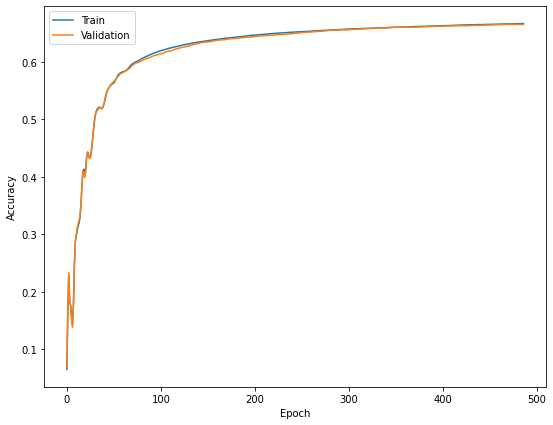

Epoch 0:   train_loss=3.8097 | train_acc=0.0154 | val_acc=0.0149
Epoch 10:  train_loss=2.4138 | train_acc=0.3886 | val_acc=0.3852
Epoch 20:  train_loss=1.9295 | train_acc=0.5150 | val_acc=0.5154
Epoch 30:  train_loss=1.6759 | train_acc=0.5560 | val_acc=0.5563
Epoch 40:  train_loss=1.5294 | train_acc=0.5813 | val_acc=0.5806
Epoch 50:  train_loss=1.4387 | train_acc=0.5988 | val_acc=0.5961
Epoch 60:  train_loss=1.3797 | train_acc=0.6103 | val_acc=0.6072
Epoch 70:  train_loss=1.3367 | train_acc=0.6194 | val_acc=0.6156
Epoch 80:  train_loss=1.3042 | train_acc=0.6264 | val_acc=0.6214
Epoch 90:  train_loss=1.2785 | train_acc=0.6315 | val_acc=0.6260
Epoch 100: train_loss=1.2576 | train_acc=0.6362 | val_acc=0.6294
Epoch 110: train_loss=1.2401 | train_acc=0.6396 | val_acc=0.6338
Epoch 120: train_loss=1.2253 | train_acc=0.6430 | val_acc=0.6368
Epoch 130: train_loss=1.2125 | train_acc=0.6456 | val_acc=0.6394
Epoch 140: train_loss=1.2013 | train_acc=0.6480 | val_acc=0.6420
Epoch 150: train_loss=1.1

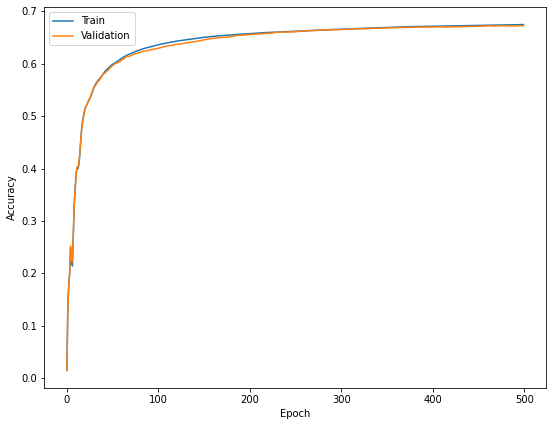

Epoch 0:   train_loss=4.5090 | train_acc=0.0154 | val_acc=0.0151
Epoch 10:  train_loss=2.5231 | train_acc=0.2309 | val_acc=0.2306
Epoch 20:  train_loss=1.9869 | train_acc=0.5010 | val_acc=0.5005
Epoch 30:  train_loss=1.7260 | train_acc=0.5466 | val_acc=0.5468
Epoch 40:  train_loss=1.5694 | train_acc=0.5785 | val_acc=0.5745
Epoch 50:  train_loss=1.4708 | train_acc=0.5954 | val_acc=0.5940
Epoch 60:  train_loss=1.4061 | train_acc=0.6081 | val_acc=0.6047
Epoch 70:  train_loss=1.3596 | train_acc=0.6162 | val_acc=0.6131
Epoch 80:  train_loss=1.3246 | train_acc=0.6231 | val_acc=0.6195
Epoch 90:  train_loss=1.2970 | train_acc=0.6282 | val_acc=0.6250
Epoch 100: train_loss=1.2746 | train_acc=0.6322 | val_acc=0.6301
Epoch 110: train_loss=1.2560 | train_acc=0.6357 | val_acc=0.6339
Epoch 120: train_loss=1.2403 | train_acc=0.6387 | val_acc=0.6368
Epoch 130: train_loss=1.2268 | train_acc=0.6413 | val_acc=0.6400
Epoch 140: train_loss=1.2151 | train_acc=0.6438 | val_acc=0.6418
Epoch 150: train_loss=1.2

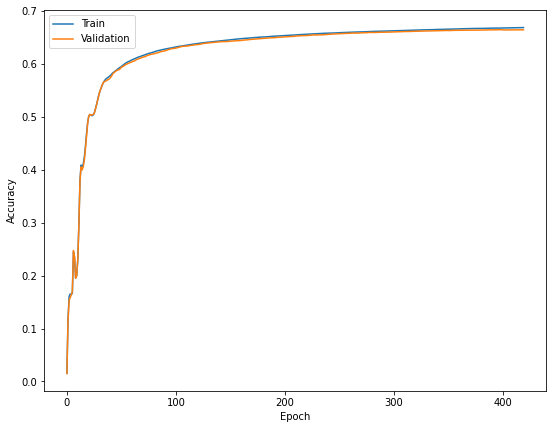

Epoch 0:   train_loss=4.7033 | train_acc=0.0113 | val_acc=0.0126
Epoch 10:  train_loss=2.5923 | train_acc=0.3359 | val_acc=0.3326
Epoch 20:  train_loss=2.0861 | train_acc=0.4629 | val_acc=0.4616
Epoch 30:  train_loss=1.7914 | train_acc=0.5226 | val_acc=0.5252
Epoch 40:  train_loss=1.6199 | train_acc=0.5668 | val_acc=0.5657
Epoch 50:  train_loss=1.5198 | train_acc=0.5906 | val_acc=0.5837
Epoch 60:  train_loss=1.4504 | train_acc=0.6014 | val_acc=0.5955
Epoch 70:  train_loss=1.4003 | train_acc=0.6107 | val_acc=0.6056
Epoch 80:  train_loss=1.3621 | train_acc=0.6176 | val_acc=0.6116
Epoch 90:  train_loss=1.3317 | train_acc=0.6231 | val_acc=0.6185
Epoch 100: train_loss=1.3069 | train_acc=0.6280 | val_acc=0.6231
Epoch 110: train_loss=1.2861 | train_acc=0.6315 | val_acc=0.6281
Epoch 120: train_loss=1.2685 | train_acc=0.6346 | val_acc=0.6316
Epoch 130: train_loss=1.2533 | train_acc=0.6376 | val_acc=0.6342
Epoch 140: train_loss=1.2402 | train_acc=0.6398 | val_acc=0.6366
Epoch 150: train_loss=1.2

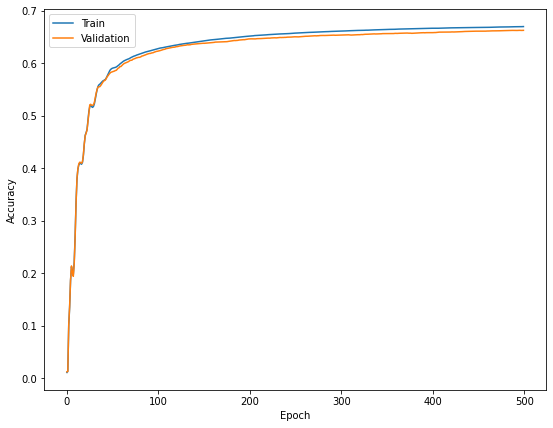

Epoch 0:   train_loss=4.9878 | train_acc=0.0061 | val_acc=0.0067
Epoch 10:  train_loss=2.6078 | train_acc=0.2752 | val_acc=0.2783
Epoch 20:  train_loss=2.0682 | train_acc=0.4554 | val_acc=0.4567
Epoch 30:  train_loss=1.7916 | train_acc=0.5412 | val_acc=0.5405
Epoch 40:  train_loss=1.6277 | train_acc=0.5586 | val_acc=0.5564
Epoch 50:  train_loss=1.5224 | train_acc=0.5871 | val_acc=0.5866
Epoch 60:  train_loss=1.4519 | train_acc=0.5974 | val_acc=0.5953
Epoch 70:  train_loss=1.4013 | train_acc=0.6071 | val_acc=0.6041
Epoch 80:  train_loss=1.3632 | train_acc=0.6138 | val_acc=0.6117
Epoch 90:  train_loss=1.3330 | train_acc=0.6182 | val_acc=0.6172
Epoch 100: train_loss=1.3085 | train_acc=0.6236 | val_acc=0.6226
Epoch 110: train_loss=1.2880 | train_acc=0.6270 | val_acc=0.6257
Epoch 120: train_loss=1.2707 | train_acc=0.6305 | val_acc=0.6296
Epoch 130: train_loss=1.2558 | train_acc=0.6337 | val_acc=0.6320
Epoch 140: train_loss=1.2428 | train_acc=0.6361 | val_acc=0.6351
Epoch 150: train_loss=1.2

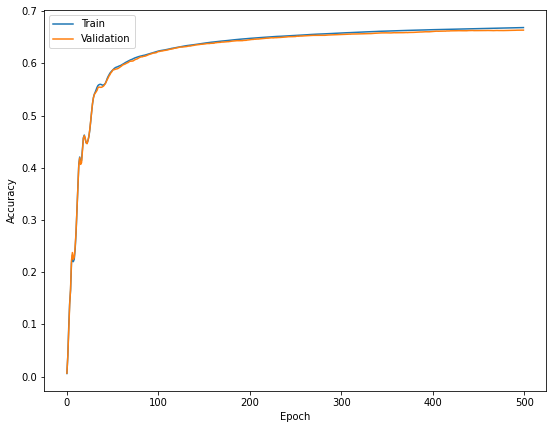

Epoch 0:   train_loss=4.3035 | train_acc=0.0318 | val_acc=0.0330
Epoch 10:  train_loss=2.6527 | train_acc=0.2657 | val_acc=0.2673
Epoch 20:  train_loss=2.1597 | train_acc=0.4469 | val_acc=0.4456
Epoch 30:  train_loss=1.8739 | train_acc=0.5062 | val_acc=0.5051
Epoch 40:  train_loss=1.6999 | train_acc=0.5516 | val_acc=0.5503
Epoch 50:  train_loss=1.5882 | train_acc=0.5739 | val_acc=0.5716
Epoch 60:  train_loss=1.5101 | train_acc=0.5881 | val_acc=0.5855
Epoch 70:  train_loss=1.4529 | train_acc=0.5984 | val_acc=0.5934
Epoch 80:  train_loss=1.4092 | train_acc=0.6072 | val_acc=0.6045
Epoch 90:  train_loss=1.3745 | train_acc=0.6134 | val_acc=0.6100
Epoch 100: train_loss=1.3463 | train_acc=0.6184 | val_acc=0.6146
Epoch 110: train_loss=1.3228 | train_acc=0.6224 | val_acc=0.6186
Epoch 120: train_loss=1.3029 | train_acc=0.6258 | val_acc=0.6223
Epoch 130: train_loss=1.2858 | train_acc=0.6291 | val_acc=0.6257
Epoch 140: train_loss=1.2708 | train_acc=0.6317 | val_acc=0.6283
Epoch 150: train_loss=1.2

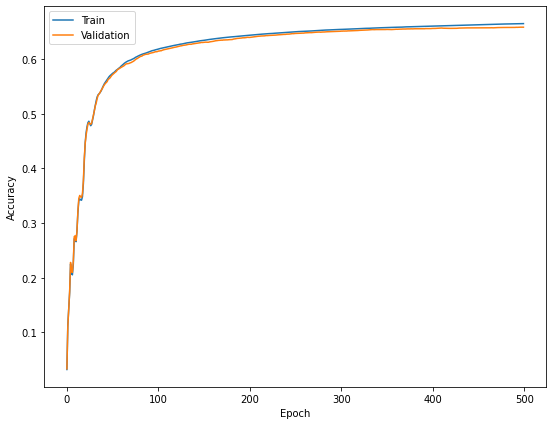

Epoch 0:   train_loss=4.6565 | train_acc=0.0202 | val_acc=0.0214
Epoch 10:  train_loss=2.6920 | train_acc=0.3043 | val_acc=0.3054
Epoch 20:  train_loss=2.2431 | train_acc=0.4103 | val_acc=0.4110
Epoch 30:  train_loss=1.9136 | train_acc=0.5100 | val_acc=0.5064
Epoch 40:  train_loss=1.7332 | train_acc=0.5450 | val_acc=0.5411
Epoch 50:  train_loss=1.6099 | train_acc=0.5672 | val_acc=0.5650
Epoch 60:  train_loss=1.5235 | train_acc=0.5824 | val_acc=0.5795
Epoch 70:  train_loss=1.4610 | train_acc=0.5935 | val_acc=0.5917
Epoch 80:  train_loss=1.4128 | train_acc=0.6035 | val_acc=0.6003
Epoch 90:  train_loss=1.3747 | train_acc=0.6119 | val_acc=0.6072
Epoch 100: train_loss=1.3438 | train_acc=0.6174 | val_acc=0.6123
Epoch 110: train_loss=1.3182 | train_acc=0.6222 | val_acc=0.6178
Epoch 120: train_loss=1.2967 | train_acc=0.6266 | val_acc=0.6227
Epoch 130: train_loss=1.2783 | train_acc=0.6300 | val_acc=0.6260
Epoch 140: train_loss=1.2625 | train_acc=0.6331 | val_acc=0.6297
Epoch 150: train_loss=1.2

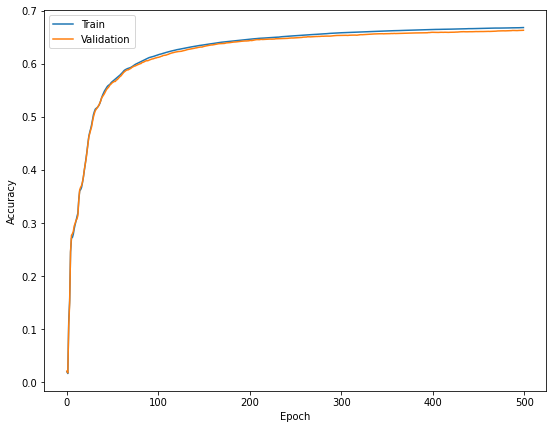

Epoch 0:   train_loss=4.7744 | train_acc=0.0508 | val_acc=0.0495
Epoch 10:  train_loss=2.7285 | train_acc=0.3261 | val_acc=0.3297
Epoch 20:  train_loss=2.1971 | train_acc=0.4419 | val_acc=0.4417
Epoch 30:  train_loss=1.8852 | train_acc=0.5083 | val_acc=0.5073
Epoch 40:  train_loss=1.7008 | train_acc=0.5533 | val_acc=0.5519
Epoch 50:  train_loss=1.5827 | train_acc=0.5768 | val_acc=0.5746
Epoch 60:  train_loss=1.4999 | train_acc=0.5918 | val_acc=0.5905
Epoch 70:  train_loss=1.4402 | train_acc=0.6027 | val_acc=0.6010
Epoch 80:  train_loss=1.3946 | train_acc=0.6107 | val_acc=0.6072
Epoch 90:  train_loss=1.3586 | train_acc=0.6173 | val_acc=0.6139
Epoch 100: train_loss=1.3295 | train_acc=0.6224 | val_acc=0.6195
Epoch 110: train_loss=1.3054 | train_acc=0.6271 | val_acc=0.6237
Epoch 120: train_loss=1.2851 | train_acc=0.6307 | val_acc=0.6275
Epoch 130: train_loss=1.2677 | train_acc=0.6343 | val_acc=0.6306
Epoch 140: train_loss=1.2528 | train_acc=0.6367 | val_acc=0.6331
Epoch 150: train_loss=1.2

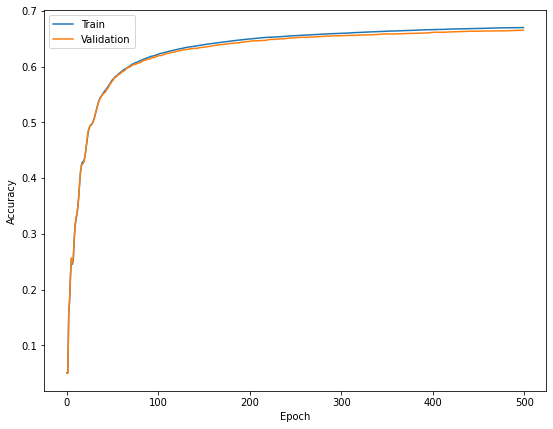

PygNodePropPredDataset-ogbn-arxiv: test_accuracy=0.665±0.002


In [ ]:
num_graff_layers = 2
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)

Epoch 0:   train_loss=17.3510 | train_acc=0.0727 | val_acc=0.0733
Epoch 10:  train_loss=7.4855 | train_acc=0.2935 | val_acc=0.2936
Epoch 20:  train_loss=4.3822 | train_acc=0.3594 | val_acc=0.3580
Epoch 30:  train_loss=2.7895 | train_acc=0.4580 | val_acc=0.4546
Epoch 40:  train_loss=1.9913 | train_acc=0.5225 | val_acc=0.5190
Epoch 50:  train_loss=1.7743 | train_acc=0.5635 | val_acc=0.5634
Epoch 60:  train_loss=1.6327 | train_acc=0.5769 | val_acc=0.5759
Epoch 70:  train_loss=1.5313 | train_acc=0.5873 | val_acc=0.5875
Epoch 80:  train_loss=1.4799 | train_acc=0.5968 | val_acc=0.5947
Epoch 90:  train_loss=1.4420 | train_acc=0.6044 | val_acc=0.6017
Epoch 100: train_loss=1.4111 | train_acc=0.6101 | val_acc=0.6078
Epoch 110: train_loss=1.3861 | train_acc=0.6147 | val_acc=0.6127
Epoch 120: train_loss=1.3647 | train_acc=0.6194 | val_acc=0.6166
Epoch 130: train_loss=1.3460 | train_acc=0.6234 | val_acc=0.6203
Epoch 140: train_loss=1.3295 | train_acc=0.6273 | val_acc=0.6236
Epoch 150: train_loss=1.

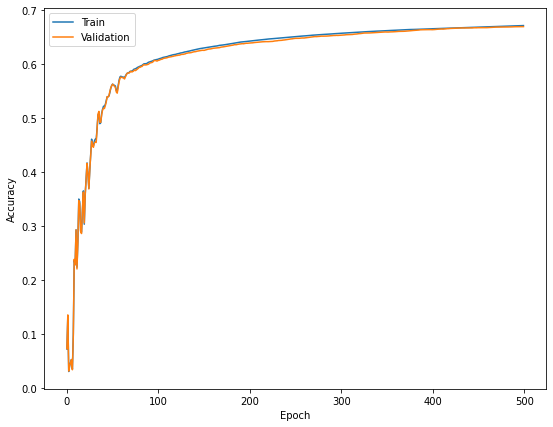

Epoch 0:   train_loss=47.4300 | train_acc=0.0139 | val_acc=0.0146
Epoch 10:  train_loss=17.6586 | train_acc=0.2225 | val_acc=0.2232
Epoch 20:  train_loss=11.2851 | train_acc=0.1602 | val_acc=0.1589
Epoch 30:  train_loss=5.9850 | train_acc=0.3339 | val_acc=0.3349
Epoch 40:  train_loss=4.7565 | train_acc=0.4537 | val_acc=0.4549
Epoch 50:  train_loss=3.2601 | train_acc=0.4981 | val_acc=0.5010
Epoch 60:  train_loss=2.4250 | train_acc=0.5201 | val_acc=0.5192
Epoch 70:  train_loss=1.9948 | train_acc=0.5399 | val_acc=0.5428
Epoch 80:  train_loss=1.7715 | train_acc=0.5387 | val_acc=0.5365
Epoch 90:  train_loss=1.6489 | train_acc=0.5709 | val_acc=0.5709
Epoch 100: train_loss=1.5811 | train_acc=0.5775 | val_acc=0.5777
Epoch 110: train_loss=1.5309 | train_acc=0.5869 | val_acc=0.5880
Epoch 120: train_loss=1.4951 | train_acc=0.5932 | val_acc=0.5960
Epoch 130: train_loss=1.4662 | train_acc=0.5992 | val_acc=0.6022
Epoch 140: train_loss=1.4422 | train_acc=0.6037 | val_acc=0.6074
Epoch 150: train_loss=

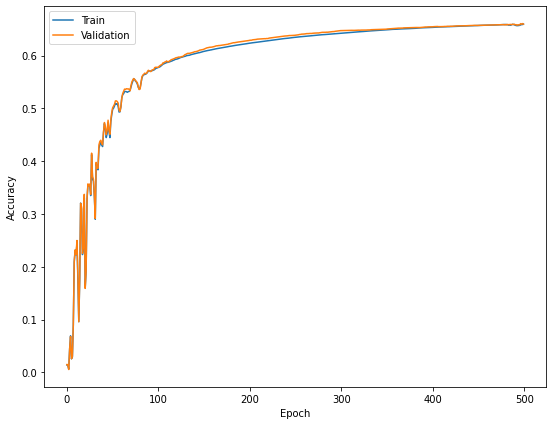

Epoch 0:   train_loss=31.7762 | train_acc=0.0171 | val_acc=0.0174
Epoch 10:  train_loss=18.0033 | train_acc=0.2133 | val_acc=0.2134
Epoch 20:  train_loss=9.6093 | train_acc=0.3178 | val_acc=0.3170
Epoch 30:  train_loss=4.6444 | train_acc=0.3877 | val_acc=0.3888
Epoch 40:  train_loss=2.7233 | train_acc=0.4543 | val_acc=0.4512
Epoch 50:  train_loss=2.2875 | train_acc=0.5212 | val_acc=0.5201
Epoch 60:  train_loss=1.7880 | train_acc=0.5530 | val_acc=0.5537
Epoch 70:  train_loss=1.6644 | train_acc=0.5661 | val_acc=0.5651
Epoch 80:  train_loss=1.5743 | train_acc=0.5843 | val_acc=0.5835
Epoch 90:  train_loss=1.5148 | train_acc=0.5932 | val_acc=0.5923
Epoch 100: train_loss=1.4772 | train_acc=0.5998 | val_acc=0.5987
Epoch 110: train_loss=1.4483 | train_acc=0.6062 | val_acc=0.6054
Epoch 120: train_loss=1.4238 | train_acc=0.6104 | val_acc=0.6107
Epoch 130: train_loss=1.4028 | train_acc=0.6140 | val_acc=0.6149
Epoch 140: train_loss=1.3843 | train_acc=0.6176 | val_acc=0.6177
Epoch 150: train_loss=1

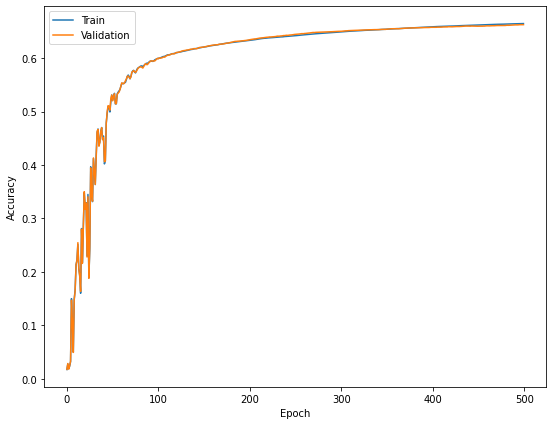

Epoch 0:   train_loss=16.5402 | train_acc=0.0781 | val_acc=0.0772
Epoch 10:  train_loss=6.8670 | train_acc=0.2773 | val_acc=0.2751
Epoch 20:  train_loss=4.0285 | train_acc=0.4365 | val_acc=0.4321
Epoch 30:  train_loss=2.8681 | train_acc=0.5085 | val_acc=0.5096
Epoch 40:  train_loss=2.1839 | train_acc=0.5313 | val_acc=0.5334
Epoch 50:  train_loss=1.8367 | train_acc=0.5540 | val_acc=0.5549
Epoch 60:  train_loss=1.6555 | train_acc=0.5835 | val_acc=0.5883
Epoch 70:  train_loss=1.5401 | train_acc=0.5912 | val_acc=0.5982
Epoch 80:  train_loss=1.4755 | train_acc=0.6014 | val_acc=0.6079
Epoch 90:  train_loss=1.4310 | train_acc=0.6098 | val_acc=0.6173
Epoch 100: train_loss=1.3970 | train_acc=0.6159 | val_acc=0.6221
Epoch 110: train_loss=1.3704 | train_acc=0.6215 | val_acc=0.6278
Epoch 120: train_loss=1.3483 | train_acc=0.6264 | val_acc=0.6325
Epoch 130: train_loss=1.3293 | train_acc=0.6305 | val_acc=0.6363
Epoch 140: train_loss=1.3126 | train_acc=0.6340 | val_acc=0.6404
Epoch 150: train_loss=1.

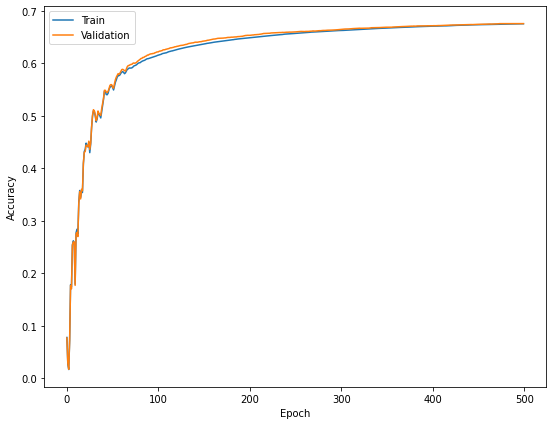

Epoch 0:   train_loss=23.7766 | train_acc=0.0062 | val_acc=0.0063
Epoch 10:  train_loss=11.3506 | train_acc=0.2524 | val_acc=0.2544
Epoch 20:  train_loss=5.6223 | train_acc=0.2482 | val_acc=0.2461
Epoch 30:  train_loss=3.5152 | train_acc=0.3851 | val_acc=0.3834
Epoch 40:  train_loss=2.5311 | train_acc=0.4718 | val_acc=0.4691
Epoch 50:  train_loss=2.1889 | train_acc=0.5010 | val_acc=0.5041
Epoch 60:  train_loss=1.8837 | train_acc=0.5401 | val_acc=0.5435
Epoch 70:  train_loss=1.7393 | train_acc=0.5597 | val_acc=0.5630
Epoch 80:  train_loss=1.6347 | train_acc=0.5724 | val_acc=0.5757
Epoch 90:  train_loss=1.5531 | train_acc=0.5837 | val_acc=0.5874
Epoch 100: train_loss=1.5115 | train_acc=0.5898 | val_acc=0.5930
Epoch 110: train_loss=1.4735 | train_acc=0.5979 | val_acc=0.6000
Epoch 120: train_loss=1.4437 | train_acc=0.6044 | val_acc=0.6063
Epoch 130: train_loss=1.4184 | train_acc=0.6098 | val_acc=0.6117
Epoch 140: train_loss=1.3962 | train_acc=0.6148 | val_acc=0.6160
Epoch 150: train_loss=1

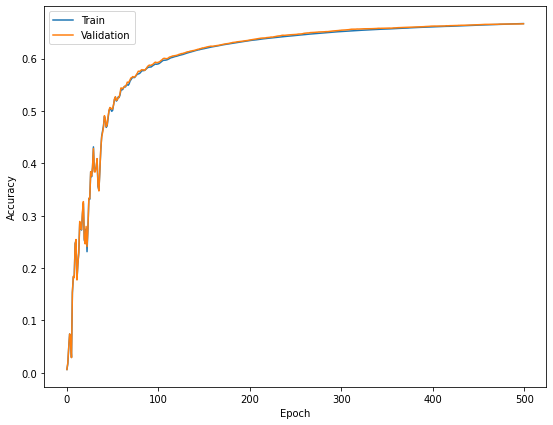

Epoch 0:   train_loss=28.1331 | train_acc=0.0062 | val_acc=0.0060
Epoch 10:  train_loss=8.1697 | train_acc=0.2654 | val_acc=0.2653
Epoch 20:  train_loss=5.5702 | train_acc=0.3862 | val_acc=0.3848
Epoch 30:  train_loss=3.7297 | train_acc=0.4566 | val_acc=0.4594
Epoch 40:  train_loss=2.8902 | train_acc=0.5043 | val_acc=0.5053
Epoch 50:  train_loss=2.4345 | train_acc=0.5416 | val_acc=0.5431
Epoch 60:  train_loss=2.0982 | train_acc=0.5642 | val_acc=0.5675
Epoch 70:  train_loss=1.7774 | train_acc=0.5803 | val_acc=0.5827
Epoch 80:  train_loss=1.6604 | train_acc=0.5896 | val_acc=0.5943
Epoch 90:  train_loss=1.5670 | train_acc=0.5980 | val_acc=0.6015
Epoch 100: train_loss=1.4848 | train_acc=0.6035 | val_acc=0.6072
Epoch 110: train_loss=1.4175 | train_acc=0.6061 | val_acc=0.6097
Epoch 120: train_loss=1.3934 | train_acc=0.6129 | val_acc=0.6152
Epoch 130: train_loss=1.3739 | train_acc=0.6174 | val_acc=0.6183
Epoch 140: train_loss=1.3549 | train_acc=0.6207 | val_acc=0.6211
Epoch 150: train_loss=1.

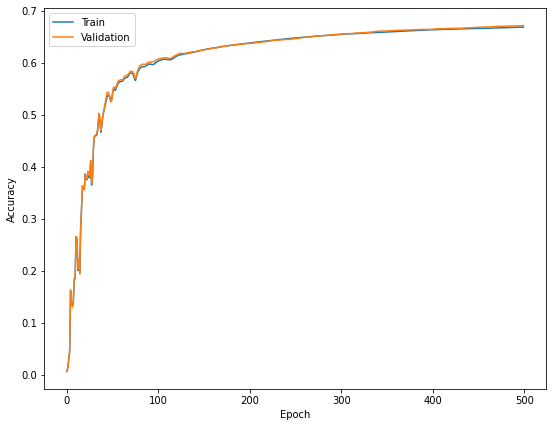

Epoch 0:   train_loss=37.1780 | train_acc=0.0288 | val_acc=0.0272
Epoch 10:  train_loss=9.0612 | train_acc=0.3025 | val_acc=0.3034
Epoch 20:  train_loss=6.3017 | train_acc=0.3584 | val_acc=0.3572
Epoch 30:  train_loss=3.4594 | train_acc=0.4258 | val_acc=0.4251
Epoch 40:  train_loss=2.6115 | train_acc=0.5012 | val_acc=0.5021
Epoch 50:  train_loss=2.0875 | train_acc=0.4997 | val_acc=0.4989
Epoch 60:  train_loss=1.7870 | train_acc=0.5543 | val_acc=0.5557
Epoch 70:  train_loss=1.6638 | train_acc=0.5747 | val_acc=0.5777
Epoch 80:  train_loss=1.5880 | train_acc=0.5873 | val_acc=0.5869
Epoch 90:  train_loss=1.5340 | train_acc=0.5972 | val_acc=0.5977
Epoch 100: train_loss=1.4927 | train_acc=0.6042 | val_acc=0.6059
Epoch 110: train_loss=1.4587 | train_acc=0.6100 | val_acc=0.6111
Epoch 120: train_loss=1.4286 | train_acc=0.6156 | val_acc=0.6178
Epoch 130: train_loss=1.4017 | train_acc=0.6200 | val_acc=0.6218
Epoch 140: train_loss=1.3768 | train_acc=0.6239 | val_acc=0.6255
Epoch 150: train_loss=1.

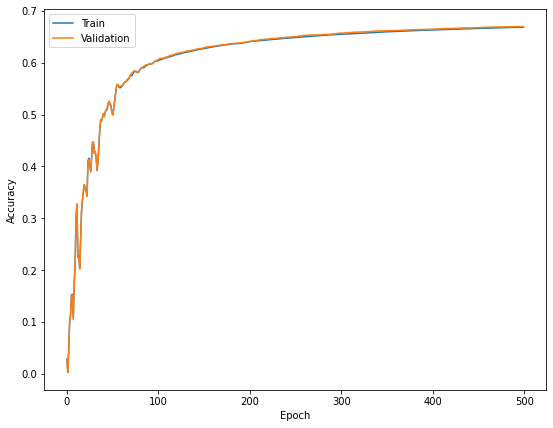

Epoch 0:   train_loss=23.8465 | train_acc=0.0371 | val_acc=0.0368
Epoch 10:  train_loss=13.2661 | train_acc=0.0783 | val_acc=0.0751
Epoch 20:  train_loss=7.1752 | train_acc=0.3011 | val_acc=0.3019
Epoch 30:  train_loss=4.4807 | train_acc=0.3801 | val_acc=0.3818
Epoch 40:  train_loss=3.4919 | train_acc=0.4317 | val_acc=0.4304
Epoch 50:  train_loss=2.5033 | train_acc=0.5020 | val_acc=0.5053
Epoch 60:  train_loss=2.0271 | train_acc=0.5273 | val_acc=0.5306
Epoch 70:  train_loss=1.7294 | train_acc=0.5550 | val_acc=0.5589
Epoch 80:  train_loss=1.6606 | train_acc=0.5653 | val_acc=0.5696
Epoch 90:  train_loss=1.5857 | train_acc=0.5731 | val_acc=0.5788
Epoch 100: train_loss=1.5359 | train_acc=0.5841 | val_acc=0.5915
Epoch 110: train_loss=1.4965 | train_acc=0.5926 | val_acc=0.5999
Epoch 120: train_loss=1.4663 | train_acc=0.5997 | val_acc=0.6063
Epoch 130: train_loss=1.4397 | train_acc=0.6050 | val_acc=0.6108
Epoch 140: train_loss=1.4168 | train_acc=0.6094 | val_acc=0.6146
Epoch 150: train_loss=1

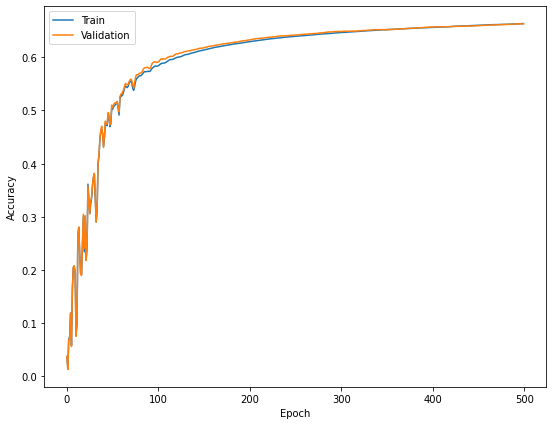

Epoch 0:   train_loss=27.0938 | train_acc=0.0215 | val_acc=0.0220
Epoch 10:  train_loss=13.2435 | train_acc=0.2078 | val_acc=0.2089
Epoch 20:  train_loss=5.8648 | train_acc=0.2354 | val_acc=0.2341
Epoch 30:  train_loss=3.8038 | train_acc=0.3536 | val_acc=0.3583
Epoch 40:  train_loss=2.5914 | train_acc=0.4853 | val_acc=0.4854
Epoch 50:  train_loss=2.1274 | train_acc=0.5166 | val_acc=0.5183
Epoch 60:  train_loss=1.9152 | train_acc=0.5388 | val_acc=0.5394
Epoch 70:  train_loss=1.7701 | train_acc=0.5556 | val_acc=0.5564
Epoch 80:  train_loss=1.6528 | train_acc=0.5731 | val_acc=0.5761
Epoch 90:  train_loss=1.5842 | train_acc=0.5807 | val_acc=0.5828
Epoch 100: train_loss=1.5231 | train_acc=0.5899 | val_acc=0.5915
Epoch 110: train_loss=1.4734 | train_acc=0.5963 | val_acc=0.5983
Epoch 120: train_loss=1.4378 | train_acc=0.6007 | val_acc=0.6017
Epoch 130: train_loss=1.4117 | train_acc=0.6076 | val_acc=0.6087
Epoch 140: train_loss=1.3897 | train_acc=0.6118 | val_acc=0.6131
Epoch 150: train_loss=1

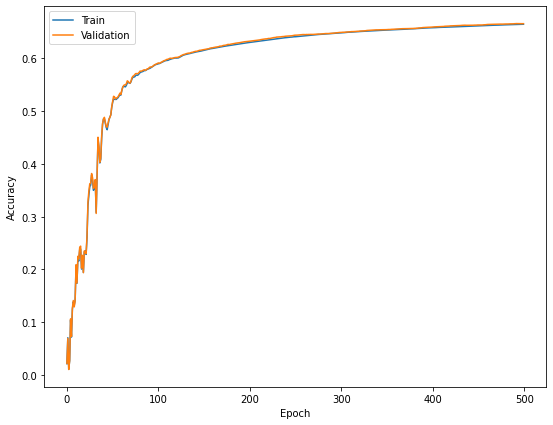

Epoch 0:   train_loss=17.1802 | train_acc=0.0088 | val_acc=0.0080
Epoch 10:  train_loss=6.3918 | train_acc=0.2470 | val_acc=0.2521
Epoch 20:  train_loss=3.8368 | train_acc=0.3713 | val_acc=0.3756
Epoch 30:  train_loss=2.8618 | train_acc=0.5127 | val_acc=0.5134
Epoch 40:  train_loss=2.0826 | train_acc=0.5498 | val_acc=0.5544
Epoch 50:  train_loss=1.8588 | train_acc=0.5788 | val_acc=0.5839
Epoch 60:  train_loss=1.6726 | train_acc=0.5954 | val_acc=0.6002
Epoch 70:  train_loss=1.5310 | train_acc=0.6064 | val_acc=0.6120
Epoch 80:  train_loss=1.4190 | train_acc=0.6155 | val_acc=0.6198
Epoch 90:  train_loss=1.3709 | train_acc=0.6201 | val_acc=0.6248
Epoch 100: train_loss=1.3328 | train_acc=0.6273 | val_acc=0.6308
Epoch 110: train_loss=1.3059 | train_acc=0.6299 | val_acc=0.6330
Epoch 120: train_loss=1.2868 | train_acc=0.6343 | val_acc=0.6371
Epoch 130: train_loss=1.2716 | train_acc=0.6376 | val_acc=0.6417
Epoch 140: train_loss=1.2583 | train_acc=0.6402 | val_acc=0.6446
Epoch 150: train_loss=1.

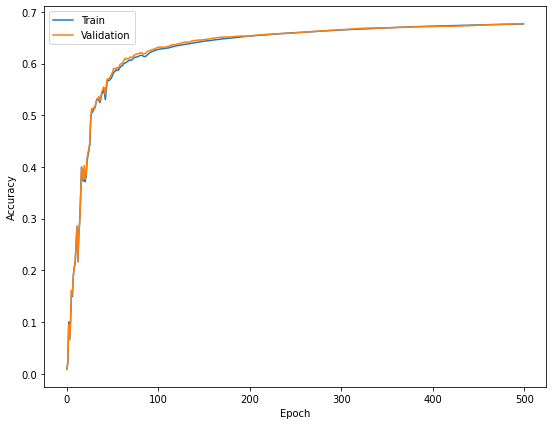

PygNodePropPredDataset-ogbn-arxiv: test_accuracy=0.667±0.005


In [ ]:
num_graff_layers = 4
run_experiment(dataset, learning_rate, model_func_graff, diffusion_ops)